<a href="https://colab.research.google.com/github/BKover99/Pseudovisium/blob/main/Paper%20figures/Fig2-5_Pseudovisium_across_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script performs various analyses on spatial transcriptomics datasets from different technologies.
It includes functions for loading data, processing, clustering, calculating spatial autocorrelation,
and comparing results between full resolution and pseudovisium data.

In [ ]:
!wget https://github.com/BKover99/Pseudovisium/raw/main/Datasets_all.xlsx
!pip3 install Pseudovisium -q --upgrade
!pip3 install pympler -q --upgrade
!pip3 install spatialAUC -q --upgrade
!pip3 install scikit-misc -q --upgrade

--2024-06-13 11:23:42--  https://github.com/BKover99/Pseudovisium/raw/main/Datasets_all.xlsx
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BKover99/Pseudovisium/main/Datasets_all.xlsx [following]
--2024-06-13 11:23:42--  https://raw.githubusercontent.com/BKover99/Pseudovisium/main/Datasets_all.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39803 (39K) [application/octet-stream]
Saving to: ‘Datasets_all.xlsx.2’

Datasets_all.xlsx.2 100%[===================>]  38.87K  --.-KB/s    in 0.01s   

2024-06-13 11:23:42 (3.46 MB/s) - ‘Datasets_all.xlsx.2’ saved [39803/39803]

ERROR: Exception:
Tra

Importing the required packages


In [ ]:
import pandas as pd
from os import system
import os
import time
import squidpy as sq
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from pympler import asizeof
import seaborn as sns
import scipy.stats as stats
import sklearn.metrics as metrics
import shutil
import subprocess
import concurrent.futures
np.random.seed(42)

Here are two utility functions to find specific files within a given folder:

In [ ]:
def find_csv_with_transcript(folder_path):
    """
    Find a CSV file that contains 'transcript' or 'tx' in its name within a given folder.

    Args:
        folder_path (str): The path to the folder to search for the CSV file.

    Returns:
        str: The path to the found CSV file, or None if no such file is found.
    """
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if ((file.endswith('.csv') or file.endswith('.csv.gz')) and (('transcript' in file.lower() or 'tx' in file.lower()))) and '._' not in file.lower() and 'macosx' not in root.lower():
                return os.path.join(root, file)
    return None

def find_any_file_within_folder(folder_path,end):
    """
    Find any file with a specific extension within a given folder.

    Args:
        folder_path (str): The path to the folder to search for the file.
        end (str): The file extension to search for.

    Returns:
        str: The path to the found file, or None if no such file is found.
    """
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            #if (file.endswith(end) or file.endswith(end+"") and 'macosx' not in root.lower():
            if (file.endswith(end) or file.endswith(end+".gz")) and 'macosx' not in root.lower() and '._' not in file.lower():
                return os.path.join(root, file)
    return None

The following cell reads an Excel file named "Datasets_all.xlsx" using pandas and performs data filtering and manipulation to only keep datasets to be used in this notebook.

In [ ]:
datasets = pd.read_excel("/content/Datasets_all.xlsx")
datasets_to_use = datasets[datasets["PV_workflow_comparison"] == 1]

# Remove rows with missing Onedrive_link
datasets_to_use = datasets_to_use[~datasets_to_use["Onedrive_link"].isna()]

# Reset the index of the DataFrame
datasets_to_use.reset_index(drop=True, inplace=True)

# Display the first 5 rows of the resulting DataFrame
datasets_to_use.head(5)

,Author,Year,Paper_DOI,Link_to_dataset,Onedrive_link,Name,Technology,Tissue,Species,Visium_xenium_notebook,Allen_Brain_Merfish,PV_workflow_comparison,Comparing_all_tech,Pulmonary Xenium,Cosmx_lung,Dataset_merge_visium,Brain case study,Just Visium example
0,Nanostring,2023.0,NaN,https://nanostring.com/products/cosmx-spatial-...,https://dg1oqa.bl.files.1drv.com/y4m2CulsqPOHi...,CosMx_Pancreas,CosMx,Pancreas,Human,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN
1,Nanostring,2023.0,NaN,https://nanostring.com/products/cosmx-spatial-...,https://ywobqw.bl.files.1drv.com/y4mnkgdMt9PQD...,CosMx_mouse_brain,CosMx,Brain,Mouse,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN
2,Nanostring,2023.0,NaN,https://nanostring.com/products/cosmx-spatial-...,https://lyhnuq.bl.files.1drv.com/y4m5IUS_t41bN...,CosMx_human_brain,CosMx,Brain,Human,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN
3,Nanostring,2022.0,DOI: 10.1038/s41587-022-01483-z,NaN,https://vgocqw.bl.files.1drv.com/y4mNw37uF9wd_...,CosMx_nsclc_5_1,CosMx_prototype,Lung_NSCLC,Human,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,NaN
4,Nanostring,2022.0,DOI: 10.1038/s41587-022-01483-z,NaN,https://kd26iq.bl.files.1drv.com/y4mtWoQzs3BK6...,CosMx_nsclc_9_1,CosMx_prototype,Lung_NSCLC,Human,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,NaN


In [ ]:
# Display the last 5 rows of the resulting DataFrame
datasets_to_use.tail(5)

,Author,Year,Paper_DOI,Link_to_dataset,Onedrive_link,Name,Technology,Tissue,Species,Visium_xenium_notebook,Allen_Brain_Merfish,PV_workflow_comparison,Comparing_all_tech,Pulmonary Xenium,Cosmx_lung,Dataset_merge_visium,Brain case study,Just Visium example
49,Vizgen,NaN,NaN,https://console.cloud.google.com/storage/brows...,https://kt29iq.bl.files.1drv.com/y4mCpagDU-VBS...,Vizgen_liver_2,Vizgen,Liver,NaN,NaN,NaN,1.0,1.0,NaN,0.0,0.0,NaN,NaN
50,Vizgen,2023.0,NaN,https://download.brainimagelibrary.org/aa/79/a...,https://ael2ng.bl.files.1drv.com/y4mY5Lk4ZFIdf...,Vizgen_brain_allen_0,Vizgen,Brain,Mouse,NaN,NaN,1.0,1.0,NaN,NaN,0.0,NaN,NaN
51,Allen Institute,NaN,NaN,https://download.brainimagelibrary.org/aa/79/a...,https://jsgq5w.bl.files.1drv.com/y4mqXEaeQKEPa...,Vizgen_brain_allen_4,Vizgen,Brain,Mouse,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN
52,Vizgen,NaN,NaN,https://download.brainimagelibrary.org/aa/79/a...,https://wnqboq.bl.files.1drv.com/y4mkeW11yB1rx...,Vizgen_brain_allen_12,Vizgen,Brain,Mouse,NaN,NaN,1.0,1.0,NaN,NaN,0.0,NaN,NaN
53,Vizgen,NaN,NaN,https://download.brainimagelibrary.org/aa/79/a...,https://kt24iq.bl.files.1drv.com/y4mAEAL932He-...,Vizgen_brain_allen_13,Vizgen,Brain,Mouse,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN


In [ ]:
import os
def download_and_unzip(dataset):
    """
    Download and extract a dataset from a given download link.

    Args:
        dataset (dict): A dictionary containing the dataset information.

    Returns:
        None
    """
    try:
        download_link = dataset["Onedrive_link"]
        name = dataset["Name"]
        print(f"Processing dataset: {name}")
        print(f"Download link: {download_link}")

        command = "wget {}".format(download_link)
        subprocess.run(command, shell=True, check=True)

        filename = download_link.split("com/")[-1]
        archive_name = filename.split("/")[-1]

        if name == "Xenium_whole_mouse_pup":
            filename = "Xenium_V1_mouse_pup_outs.zip"

        try:
            command_unzip = "unzip -d /content/{} /content/{}".format(name, filename)
            print(command_unzip)
            subprocess.run(command_unzip, shell=True, check=True)
            print("Successfully unzipped {}.".format(archive_name))
            os.remove("/content/{}".format(filename))  # Remove the zip file
        except subprocess.CalledProcessError:
            print("Failed to unzip {}. Attempting other methods.".format(archive_name))

            try:
                command_gunzip = "gunzip -d /content/{} /content/{}".format(name, filename)
                subprocess.run(command_gunzip, shell=True, check=True)
                print("Successfully gunzipped {}.".format(archive_name))
                os.remove("/content/{}".format(filename))   # Remove the zip file
            except subprocess.CalledProcessError:
                print("Failed to gunzip {}. Attempting other methods.".format(archive_name))

                try:
                    os.makedirs("/content/{}".format(name), exist_ok=True)
                    command_untar = "tar -xvf /content/{} -C /content/{}".format(filename, name)
                    subprocess.run(command_untar, shell=True, check=True)
                    print("Successfully untarred {}.".format(archive_name))
                    os.remove("/content/{}".format(filename))   # Remove the zip file
                except subprocess.CalledProcessError:
                    try:

                      command_untar = "tar -xvzf /content/{} -C /content/{}".format(filename, name)
                      subprocess.run(command_untar, shell=True, check=True)
                      print("Successfully untarred {}.".format(archive_name))
                      os.remove("/content/{}".format(filename))   # Remove the zip file
                    except:
                      print("All methods failed to extract {}.".format(archive_name))

    except KeyError as e:
        print(f"Error: Missing required column in dataset: {str(e)}")
    except subprocess.CalledProcessError as e:
        print(f"Error: Command failed: {str(e)}")
    except Exception as e:
        print(f"Error: An unexpected error occurred: {str(e)}")


This codeblock downloads and unzips in parallel the datasets specified in the pandas dataframe using the above defined function.

In [ ]:

# Create a thread pool with a maximum of 10 threads
with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
    # Submit download and unzip tasks to the thread pool
    futures = [executor.submit(download_and_unzip, row.to_dict()) for _, row in datasets_to_use.reset_index(drop=True).iterrows()]

    # Wait for all tasks to complete
    concurrent.futures.wait(futures)

Processing dataset: Xenium_lymph_node
Processing dataset: Xenium_lymph_node_2
Download link: https://cf.10xgenomics.com/samples/xenium/1.5.0/Xenium_V1_hLymphNode_nondiseased_section/Xenium_V1_hLymphNode_nondiseased_section_outs.zip
Download link: https://s3-us-west-2.amazonaws.com/10x.files/samples/xenium/3.0.0/Xenium_Prime_Human_Lymph_Node_Reactive_FFPE/Xenium_Prime_Human_Lymph_Node_Reactive_FFPE_outs.zip
unzip -d /content/Xenium_lymph_node_2 /content/samples/xenium/1.5.0/Xenium_V1_hLymphNode_nondiseased_section/Xenium_V1_hLymphNode_nondiseased_section_outs.zip
Failed to unzip Xenium_V1_hLymphNode_nondiseased_section_outs.zip. Attempting other methods.
Failed to gunzip Xenium_V1_hLymphNode_nondiseased_section_outs.zip. Attempting other methods.
All methods failed to extract Xenium_V1_hLymphNode_nondiseased_section_outs.zip.
unzip -d /content/Xenium_lymph_node /content/10x.files/samples/xenium/3.0.0/Xenium_Prime_Human_Lymph_Node_Reactive_FFPE/Xenium_Prime_Human_Lymph_Node_Reactive_FFPE

Some datasets had an annoying URL format and we separately unzip them here.

In [ ]:
!unzip /content/Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_outs.zip -d /content/Xenium_melanoma
!unzip /content/Xenium_V1_FFPE_wildtype_13_4_months_outs.zip -d /content/Xenium_brain_1
!unzip /content/Xenium_V1_Human_Brain_GBM_FFPE_outs.zip -d /content/Xenium_brain_2
!unzip /content/Xenium_V1_hLymphNode_nondiseased_section_outs.zip -d /content/Xenium_lymph_node_2
!unzip /content/Xenium_V1_hTonsil_reactive_follicular_hyperplasia_section_FFPE_outs.zip -d /content/Xenium_tonsil
!unzip /content/Xenium_V1_mouse_Colon_FF_outs.zip -d /content/Xenium_colon
!unzip /content/Xenium_V1_hSkin_nondiseased_section_2_FFPE_outs.zip -d /content/Xenium_skin
!unzip /content/Xenium_V1_Human_Colorectal_Cancer_Addon_FFPE_outs.zip -d /content/Xenium_colorectal
!unzip /content/Xenium_V1_Human_Ovarian_Cancer_Addon_FFPE_outs.zip -d /content/Xenium_ovarian
!unzip /content/y4mGuOVENeMKSLWoeNU-jtUaqTmPxNQnYCTaMvGEk8U4zh6YAbknEooPdN41eIEuGSwoXNWLK-JHV4QD_mGACQ_9du_aYmmzQ_e2_-d8BLkaqhVVEBjOAGOv3giZ_3qNWhVvJ_PpAK3F6M9VN9dcsxuqX59MkGyPl0KRQZEvmA2zwjqPvQQ9UkLpuyfQAlERE5PohCf4l3U3Dlii-pLEWkujw -d /content/Visium_HD_brain_8um
!unzip /content/Xenium_Prime_Human_Lymph_Node_Reactive_FFPE_outs.zip -d /content/Xenium_lymph_node

Archive:  /content/Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_outs.zip
  inflating: /content/Xenium_melanoma/analysis_summary.html  
 extracting: /content/Xenium_melanoma/analysis.zarr.zip  
  inflating: /content/Xenium_melanoma/cell_boundaries.csv.gz  
  inflating: /content/Xenium_melanoma/cell_boundaries.parquet  
  inflating: /content/Xenium_melanoma/cell_feature_matrix.h5  
 extracting: /content/Xenium_melanoma/cell_feature_matrix.zarr.zip  
  inflating: /content/Xenium_melanoma/cells.csv.gz  
  inflating: /content/Xenium_melanoma/cells.parquet  
 extracting: /content/Xenium_melanoma/cells.zarr.zip  
  inflating: /content/Xenium_melanoma/experiment.xenium  
  inflating: /content/Xenium_melanoma/gene_panel.json  
  inflating: /content/Xenium_melanoma/metrics_summary.csv  
  inflating: /content/Xenium_melanoma/morphology_focus.ome.tif  
  inflating: /content/Xenium_melanoma/morphology_mip.ome.tif  
  inflating: /content/Xenium_melanoma/morphology.ome.tif  
  inflating: /content/Xeniu

We remove the Visium HD 8um versions here because we don't need to perform hexagonal binning on them. All we need them for is later speed comparisons.

In [ ]:
datasets_to_use = datasets_to_use[~datasets_to_use["Name"].str.endswith("8um")]
datasets_to_use.reset_index(inplace=True,drop=True)
datasets_to_use.tail(5)

,Author,Year,Paper_DOI,Link_to_dataset,Onedrive_link,Name,Technology,Tissue,Species,Visium_xenium_notebook,Allen_Brain_Merfish,PV_workflow_comparison,Comparing_all_tech,Pulmonary Xenium,Cosmx_lung,Dataset_merge_visium,Brain case study,Just Visium example
42,Vizgen,NaN,NaN,https://console.cloud.google.com/storage/brows...,https://kt29iq.bl.files.1drv.com/y4mCpagDU-VBS...,Vizgen_liver_2,Vizgen,Liver,NaN,NaN,NaN,1.0,1.0,NaN,0.0,0.0,NaN,NaN
43,Vizgen,2023.0,NaN,https://download.brainimagelibrary.org/aa/79/a...,https://ael2ng.bl.files.1drv.com/y4mY5Lk4ZFIdf...,Vizgen_brain_allen_0,Vizgen,Brain,Mouse,NaN,NaN,1.0,1.0,NaN,NaN,0.0,NaN,NaN
44,Allen Institute,NaN,NaN,https://download.brainimagelibrary.org/aa/79/a...,https://jsgq5w.bl.files.1drv.com/y4mqXEaeQKEPa...,Vizgen_brain_allen_4,Vizgen,Brain,Mouse,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN
45,Vizgen,NaN,NaN,https://download.brainimagelibrary.org/aa/79/a...,https://wnqboq.bl.files.1drv.com/y4mkeW11yB1rx...,Vizgen_brain_allen_12,Vizgen,Brain,Mouse,NaN,NaN,1.0,1.0,NaN,NaN,0.0,NaN,NaN
46,Vizgen,NaN,NaN,https://download.brainimagelibrary.org/aa/79/a...,https://kt24iq.bl.files.1drv.com/y4mAEAL932He-...,Vizgen_brain_allen_13,Vizgen,Brain,Mouse,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN


We perform hexagonal binning on all datasets using Pseudovisium_generate. The following ugly code block makes sure all datasets can be properly processed. Additionally, runtime and input file size and saved into the results dictionary.

In [ ]:
results = {}
from Pseudovisium.pseudovisium_generate import generate_pv
output_path="/content/"
hexagon_size=50
max_workers=16
errors=[]
for i in range(len(datasets_to_use)):
    try:
      start_pv = time.time()
      technology = datasets_to_use["Technology"].values[i]
      name=datasets_to_use["Name"].values[i]
      tissue = datasets_to_use["Tissue"].values[i]
      h5_x_colname="Raw_Slideseq_X"
      h5_y_colname="Raw_Slideseq_Y"
      if technology != "Visium_HD" and technology != "Curio":
        csv_file = find_csv_with_transcript("/content/"+name+"/")
        print(csv_file)
        visium_hd_folder=None
      elif technology == "Visium_HD":
        csv_file = None
        visium_hd_folder = find_any_file_within_folder("/content/"+name+"/","filtered_feature_bc_matrix.h5").split("filtered_feature_bc_matrix.h5")[0]
      elif technology == "Curio":
        csv_file = None
        visium_hd_folder = find_any_file_within_folder("/content/"+name+"/","h5ad").split("Puck")[0]
        if tissue == "Ovary":
          visium_hd_folder = find_any_file_within_folder("/content/"+name+"/","h5ad").split("GSM")[0]
          h5_x_colname="x"
          h5_y_colname="y"



      if technology == "CosMx":
        ctu= 0.12028
      elif technology == "CosMx_prototype":
        ctu=0.18
        technology = "CosMx"
      else:
        ctu=1

      print("CTU: ", ctu)

      if technology == "CosMx":
      #getting unique cell names for old SMI data
        df = pd.read_csv(csv_file)
        if 'cell' not in df.columns:
          # Create a new column called 'cell' by concatenating 'fov' and 'cell_ID' columns
          df['cell'] = df['fov'].astype(str) + '_' + df['cell_ID'].astype(str)

          # Save the updated DataFrame back to the original CSV file
          df.to_csv(csv_file, index=False)
          print("cell column added!")

      print(technology)
      print(visium_hd_folder)

      quality_filter = True if technology=="Xenium" else False

      generate_pv(csv_file=csv_file,
                  visium_hd_folder=visium_hd_folder,
                  hexagon_size=hexagon_size,
                  output_path=output_path,
                  batch_size=10000000,
                  technology=technology,
                  max_workers=max_workers,
                  quality_filter=quality_filter,
                  project_name=name,

                  coord_to_um_conversion=ctu,
                  h5_x_colname=h5_x_colname, #this is just here for the Curio samples
                  h5_y_colname=h5_y_colname) #this is just here for the Curio samples


      end_pv = time.time()
      time_pv = end_pv-start_pv
      csv_file = find_csv_with_transcript("/content/"+name+"/")
      results[name]={}
      results[name]["time_pv"]=time_pv
      results[name]["csv_size"] = os.path.getsize(csv_file)
      print(results)
    except:
      errors.append(name)
      print(errors)


/content/CosMx_Pancreas/pancreas/Pancreas_tx_file.csv
CTU:  0.12028


<ipython-input-18-748311204404>:44: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


CosMx
None
You are using version:  ['Pseudovisium==0.0.38']
Date:  2024-06-13
Technology is Nanostring. Going forward with default column names.
Quality filter is set to False
Quality counting per hexagon is set to False
Quality counting per probe is set to False
Created temporary directory /tmp/tmp_hexazd7ijrp3
Now creating batches
Created batch 1
Created batch 2
Created batch 3
Created batch 4
Created batch 5
Created batch 6
Created batch 7
Finished preprocessing. Total batches created: 7
Processing batches using 16 processes


Processing batches: 100%|██████████| 7/7 [01:25<00:00, 12.20s/batch]


Creating pseudovisium folder in output path:/content//pseudovisium/CosMx_Pancreas
Using already existing folder: /content//pseudovisium/
Creating scalefactors_json.json file in spatial folder.
Creating barcodes.tsv.gz file in spatial folder.
Creating tissue_positions_list.csv file in spatial folder.
Creating pv_cell_hex.csv file in spatial folder.


/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_generate.py:770: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hexagon_cell_counts["hexagon_id"] = hexagon_cell_counts["hexagon_id"] + 1


No quality information provided. Skipping quality information files.
No quality information provided. Skipping quality information files.
Creating features.tsv.gz file in spatial folder.
Putting together the matrix.mtx file
Total matrix count: 65794237.0
Number of unique hexagons: 618
Creating matrix.mtx.gz file in spatial folder.
Putting together the filtered_feature_bc_matrix.h5 file
No image file provided. Drawing tissue positions on a white background.
Creating arguments.json file in output path.
Time taken: 606.169025182724 seconds
Searching for temporary batch files in: /tmp
No remaining temporary batch files found.
{'CosMx_Pancreas': {'time_pv': 691.5375225543976, 'csv_size': 5190178246}}
/content/CosMx_mouse_brain/mouse brain parts/Brain_files/Run1000_S1_Half_tx_file.csv
CTU:  0.12028


<ipython-input-18-748311204404>:44: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


cell column added!
CosMx
None
You are using version:  ['Pseudovisium==0.0.38']
Date:  2024-06-13
Technology is Nanostring. Going forward with default column names.
Quality filter is set to False
Quality counting per hexagon is set to False
Quality counting per probe is set to False
Created temporary directory /tmp/tmp_hexaicmt_k9n
Now creating batches
Created batch 1
Created batch 2
Created batch 3
Created batch 4
Created batch 5
Created batch 6
Created batch 7
Created batch 8
Created batch 9
Created batch 10
Created batch 11
Created batch 12
Finished preprocessing. Total batches created: 12
Processing batches using 16 processes


Processing batches: 100%|██████████| 12/12 [01:51<00:00,  9.27s/batch]


Creating pseudovisium folder in output path:/content//pseudovisium/CosMx_mouse_brain
Using already existing folder: /content//pseudovisium/
Creating scalefactors_json.json file in spatial folder.
Creating barcodes.tsv.gz file in spatial folder.
Creating tissue_positions_list.csv file in spatial folder.
Creating pv_cell_hex.csv file in spatial folder.
No quality information provided. Skipping quality information files.
No quality information provided. Skipping quality information files.
Creating features.tsv.gz file in spatial folder.
Putting together the matrix.mtx file
Total matrix count: 116159827.0
Number of unique hexagons: 4062
Creating matrix.mtx.gz file in spatial folder.


/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_generate.py:770: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hexagon_cell_counts["hexagon_id"] = hexagon_cell_counts["hexagon_id"] + 1


Putting together the filtered_feature_bc_matrix.h5 file
No image file provided. Drawing tissue positions on a white background.
Searching for temporary batch files in: /tmp
No remaining temporary batch files found.
['CosMx_mouse_brain']
/content/CosMx_human_brain/human_frontal/S3_tx_file.csv
CTU:  0.12028
CosMx
None
You are using version:  ['Pseudovisium==0.0.38']
Date:  2024-06-13
Technology is Nanostring. Going forward with default column names.
Quality filter is set to False
Quality counting per hexagon is set to False
Quality counting per probe is set to False
Created temporary directory /tmp/tmp_hexa5arjq6i3
Now creating batches
Created batch 1
Created batch 2
Created batch 3
Created batch 4
Created batch 5
Created batch 6
Searching for temporary batch files in: /tmp
Found 1 remaining temporary directories.
Do you want to delete these temporary directories and their contents? (y/n): y
Deleted: /tmp/tmp_hexa5arjq6i3
Temporary directories deleted.
['CosMx_mouse_brain', 'CosMx_human_

In [ ]:
results

As a checkpoint, we explicitly recall the results dictionary here, so if we have to restart the notebook, we can continue from this point.

In [ ]:
#results = {'CosMx_mouse_brain': {'time_pv': 1005.3779184818268, 'loading_time_fr': 27.277514457702637, 'loading_time_pv': 14.527709722518921, 'moransi_r': 0.87192086814384, 'moransi_p': 3.0326225841216483e-296, 'fullres_time_to_leiden': 139.1150987148285, 'pv_time_to_leiden': 3.2736799716949463, 'fullres_size': 1166.0308303833008, 'pv_size': 75.12500762939453, 'moransi_time_fr': 100.95349788665771, 'moransi_time_pv': 7.15795373916626, 'ari': 0.4727301346011118, 'intercept_corr': -0.033130246786531405, 'slope_corr': 1.2700927047294461, 'intercept_coexp': -0.007518699099183536, 'slope_coexp': 1.1057218445019004}, 'Curio_brain_1': {'time_pv': 1087.9188041687012, 'loading_time_fr': 22.896090269088745, 'loading_time_pv': 1.0662550926208496, 'moransi_r': 0.8377270017122994, 'moransi_p': 0.0, 'fullres_time_to_leiden': 587.9078810214996, 'pv_time_to_leiden': 14.942017078399658, 'fullres_size': 15045.736404418945, 'pv_size': 849.9422760009766, 'moransi_time_fr': 1659.3210027217865, 'moransi_time_pv': 142.27102184295654, 'ari': 0.5496569552593115, 'intercept_corr': 0.047972293731679466, 'slope_corr': 0.7165818330757842, 'intercept_coexp': 0.04248086109926536, 'slope_coexp': 0.43352282242877554}, 'Curio_brain_4': {'time_pv': 757.558336019516, 'loading_time_fr': 6.274931907653809, 'loading_time_pv': 1.1987056732177734, 'moransi_r': 0.7869280942249353, 'moransi_p': 0.0, 'fullres_time_to_leiden': 531.2123327255249, 'pv_time_to_leiden': 9.129149675369263, 'fullres_size': 14963.179977416992, 'pv_size': 600.387321472168, 'moransi_time_fr': 1627.8542988300323, 'moransi_time_pv': 98.25523972511292, 'ari': 0.3016800499003654, 'intercept_corr': -0.00030490434394071336, 'slope_corr': 1.9256980927255176, 'intercept_coexp': 0.056493220326242995, 'slope_coexp': 0.708696328278878}, 'Visium_HD_brain_2um': {'time_pv': 2222.6892704963684}, 'Visium_HD_lung_cancer_2um': {'time_pv': 7852.3738322258}, 'Visium_HD_intestine_2um': {'time_pv': 3111.9323065280914}, 'Vizgen_brain_2_1': {'time_pv': 437.1527853012085, 'loading_time_fr': 10.114099502563477, 'loading_time_pv': 0.16131830215454102, 'moransi_r': 0.9065267795038257, 'moransi_p': 8.948188864068913e-172, 'fullres_time_to_leiden': 219.28693509101868, 'pv_time_to_leiden': 4.5187036991119385, 'fullres_size': 2497.1396102905273, 'pv_size': 56.81373596191406, 'moransi_time_fr': 91.15010619163513, 'moransi_time_pv': 5.686720132827759, 'ari': 0.387010750982818, 'intercept_corr': -0.03925800385249339, 'slope_corr': 1.2766790272280575, 'intercept_coexp': 0.037862393610056236, 'slope_coexp': 0.6344462568367453}, 'Vizgen_liver_1': {'time_pv': 3720.688860177994, 'loading_time_fr': 36.073946952819824, 'loading_time_pv': 0.25627660751342773, 'moransi_r': 0.44638804433801155, 'moransi_p': 2.1388721062323714e-18, 'fullres_time_to_leiden': 3106.4886577129364, 'pv_time_to_leiden': 13.594524145126343, 'fullres_size': 4818.342269897461, 'pv_size': 78.51695251464844, 'moransi_time_fr': 399.41324377059937, 'moransi_time_pv': 6.841025352478027, 'ari': 0.03443971952254106, 'intercept_corr': -0.01573016033154188, 'slope_corr': 1.482003196646845, 'intercept_coexp': 0.033600497352606125, 'slope_coexp': 0.809988423957627}}
results = {'CosMx_Pancreas': {'time_pv': 17010.84799194336}, 'CosMx_mouse_brain': {'time_pv': 1370.1213505268097}, 'CosMx_human_brain': {'time_pv': 2571.056463956833}, 'CosMx_nsclc_5_1': {'time_pv': 937.5441875457764}, 'Xenium_tonsil': {'time_pv': 1334.0119099617004}, 'Xenium_melanoma': {'time_pv': 334.2069857120514}, 'Xenium_brain_1': {'time_pv': 421.491681098938}, 'Xenium_brain_2': {'time_pv': 2927.0914475917816}, 'Xenium_pancreas': {'time_pv': 217.30241799354553}, 'Xenium_lymph_node': {'time_pv': 507.4783809185028}, 'Xenium_colon': {'time_pv': 1200.0228202342987}, 'Xenium_skin': {'time_pv': 125.19975543022156}, 'Xenium_breast_Sample_1_rep1': {'time_pv': 605.0963182449341}, 'Xenium_breast_Sample_2': {'time_pv': 316.95022654533386}, 'Xenium_pulmonary_GSM7990536': {'time_pv': 218.40548586845398}, 'Xenium_pulmonary_GSM7990553': {'time_pv': 156.53798270225525}, 'Xenium_whole_mouse_pup': {'time_pv': 3568.072344303131}, 'Curio_brain_2': {'time_pv': 1559.121818780899}, 'Visium_HD_brain_2um': {'time_pv': 1880.1445479393005}, 'Visium_HD_lung_cancer_2um': {'time_pv': 4868.7825882434845}, 'Visium_HD_intestine_2um': {'time_pv': 2468.5689554214478}, 'Vizgen_brain_2_1': {'time_pv': 536.8748135566711}, 'Vizgen_colon_pt2': {'time_pv': 5772.796056270599}, 'Vizgen_liver_cancer_pt1': {'time_pv': 3169.5093858242035}, 'Vizgen_ovarian_cancer_pt1': {'time_pv': 2277.9668633937836}, 'Vizgen_liver_1': {'time_pv': 4490.660914182663}, 'Vizgen_liver_2': {'time_pv': 3044.0684535503387}, 'Vizgen_brain_allen_0': {'time_pv': 414.7714202404022}, 'Vizgen_brain_allen_4': {'time_pv': 701.9726061820984}, 'Vizgen_brain_allen_12': {'time_pv': 940.1364035606384}, 'Vizgen_brain_allen_13': {'time_pv': 1104.7370467185974}}

Importing further packages which are required for loading in the datasets for analysis.

In [ ]:
from squidpy._constants._pkg_constants import Key
from squidpy.datasets._utils import PathLike
from squidpy.read._utils import _load_image, _read_counts
import json
import gzip

We define a function that can load in full resolution datasets from any of the expected technologies.

In [ ]:
def load_in_fullres(folder, technology, x_col, y_col,ctu=0.12028):
    """
    Load full resolution data based on the technology.

    Args:
        folder (str): The path to the folder containing the data.
        technology (str): The technology used for the data (e.g., "Xenium", "Vizgen", "Visium_HD", "Curio", "Nanostring", "CosMx").
        x_col (str): The column name for the x-coordinate (only used for Curio technology).
        y_col (str): The column name for the y-coordinate (only used for Curio technology).
        ctu (float, optional): The coordinate to micron conversion factor (only used for CosMx technology). Default is 0.12028.

    Returns:
        AnnData: The loaded full resolution data.
    """
    if technology == "Xenium":
        cell_matrix_file = find_any_file_within_folder(folder, "cell_feature_matrix.h5")

        if cell_matrix_file:
            adata_fullres = sc.read_10x_h5(filename=cell_matrix_file)
        else:
            matrix_folder = None
            for root, dirs, files in os.walk(folder):
                if "matrix.mtx.gz" in files:
                    matrix_folder = root
                    break

            if matrix_folder:
                adata_fullres = sc.read_10x_mtx(matrix_folder)
        cells_file = find_any_file_within_folder(folder,"cells.csv.gz")



        df = pd.read_csv(cells_file)
        df.set_index(adata_fullres.obs_names, inplace=True)
        adata_fullres.obs = df.copy()
        adata_fullres.obsm["spatial"] = adata_fullres.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

    elif technology == "Vizgen":
        counts_file = find_any_file_within_folder(folder,"gene.csv")
        meta_file = find_any_file_within_folder(folder,"metadata.csv")
        transformation_file = find_any_file_within_folder(folder,"pixel_transform.csv")
        folder = transformation_file.split("images")[0]
        adata_fullres = sq.read.vizgen(
            path=folder,
            counts_file=counts_file.split(folder)[1],
            meta_file=meta_file.split(folder)[1]
        )


    elif technology == "Visium_HD":
        # Load Visium HD data
        old_folder= folder
        folder = folder[:-4] + "8um/"
        raw_h5_file = find_any_file_within_folder(folder,'filtered_feature_bc_matrix.h5')
        if not raw_h5_file:
          folder= old_folder[:-3] + "8um/"
          raw_h5_file = find_any_file_within_folder(folder,'filtered_feature_bc_matrix.h5')

        adata_fullres = sc.read_10x_h5(raw_h5_file)
        source_image_path= find_any_file_within_folder(old_folder,"tissue_hires_image.png")
        json_path= find_any_file_within_folder(folder,"scalefactors_json.json")
        # Load the Spatial Coordinates
        tissue_position_file = find_any_file_within_folder(folder,"tissue_positions.parquet")
        coords=pd.read_parquet(tissue_position_file)
        #set barcode column as index
        coords.set_index("barcode",inplace=True)
        library_id="library_id"
        adata_fullres.uns["spatial"]={}
        #Set the index of the dataframe to the barcodes
        coords.columns = ["in_tissue", "array_row", "array_col", "pxl_col_in_fullres", "pxl_row_in_fullres"]
            # https://github.com/scverse/squidpy/issues/657
        coords.set_index(coords.index.astype(adata_fullres.obs.index.dtype), inplace=True)

        adata_fullres.uns[Key.uns.spatial][Key.uns.image_key] = {
                res: _load_image(source_image_path) for res in ["hires"]
            }
        adata_fullres.uns[Key.uns.spatial]["scalefactors"] = json.load(open(json_path))

        adata_fullres.obs = pd.merge(adata_fullres.obs, coords, how="left", left_index=True, right_index=True)
        scaling = adata_fullres.uns[Key.uns.spatial]["scalefactors"]["microns_per_pixel"]/adata_fullres.uns[Key.uns.spatial]["scalefactors"]["tissue_hires_scalef"]
        adata_fullres.obsm[Key.obsm.spatial] = adata_fullres.obs[["pxl_row_in_fullres", "pxl_col_in_fullres"]].values*adata_fullres.uns[Key.uns.spatial]["scalefactors"]["microns_per_pixel"]/scaling
        adata_fullres.obs.drop(columns=["pxl_row_in_fullres", "pxl_col_in_fullres"], inplace=True)


    elif technology == "Curio":
        #look for h5ad in folder
        h5ad_file_name = find_any_file_within_folder(folder,".h5ad")
        adata_fullres = sc.read(h5ad_file_name)
        #spatial coordinates are stored in obs x_centroid and y_centroid
        adata_fullres.uns["spatial"] = {}
        adata_fullres.obsm["spatial"] = adata_fullres.obs[[x_col,y_col]].copy().to_numpy()
        genes = (
            adata_fullres.var.index
            if (adata_fullres.var.index[0] != 0) and (adata_fullres.var.index[0] != "0")
            else adata_fullres.var[adata_fullres.var.columns[0]]
        )
        adata_fullres.var.index = genes

    elif technology == "Nanostring" or technology == "CosMx":
        #try:
      print(folder)
      for root, dirs, files in os.walk(folder):
        for file in files:
            if "._" not in file and file.endswith(".gz"):
                gz_file_path = os.path.join(root, file)
                decompressed_file_path = gz_file_path[:-3]  # Remove ".gz" extension

                with gzip.open(gz_file_path, 'rb') as f_in:
                    with open(decompressed_file_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)

                os.remove(gz_file_path)

      counts_file = find_any_file_within_folder(folder,"exprMat_file.csv")
      meta_file =  find_any_file_within_folder(folder,"metadata_file.csv")
      for filepath in [counts_file,meta_file]:
        print(filepath)
        df = pd.read_csv(filepath)
        if 'cell' in df.columns:
          df = df.drop('cell', axis=1)
          df.to_csv(filepath, index=False)

      #first command -> locate to folder folder
      fov_file = find_any_file_within_folder(folder,"fov_positions_file.csv")
      # extract the third column from the CSV file
      df = pd.read_csv(fov_file)
      #create a column fov which is same as FOV
      if "fov" not in df.columns:
        df["fov"]=df["FOV"]
        #make it the index
        df.set_index("fov", inplace=True)

        df.to_csv(fov_file, index=True)

      adata_fullres = sq.read.nanostring(
              path="",
              counts_file=counts_file,
              meta_file=meta_file,
              #fov_file=fov_file,
      )


      adata_fullres.obsm["spatial"] = adata_fullres.obs[["CenterX_global_px","CenterY_global_px"]].to_numpy()

      adata_fullres.obsm["spatial"]=adata_fullres.obsm["spatial"]*ctu
        #except:
        #  print("cosmx error")

    x_min = min(adata_fullres.obsm["spatial"][:,0])
    y_min = min(adata_fullres.obsm["spatial"][:,1])
    if x_min<0:
      adata_fullres.obsm["spatial"][:,0] = adata_fullres.obsm["spatial"][:,0] - x_min
    if y_min<0:
      adata_fullres.obsm["spatial"][:,1] = adata_fullres.obsm["spatial"][:,1] - y_min


    sc.pp.calculate_qc_metrics(adata_fullres, percent_top=(50, 100), inplace=True)
    adata_fullres.obs["sum"]= np.array(np.sum(adata_fullres.X,axis=1)).flatten()

    return adata_fullres

In [ ]:
folder="/content/Visium_HD_pancreas_2um/"
folder = folder[:-4] + "8um"
print(folder)
raw_h5_file = find_any_file_within_folder(folder,'filtered_feature_bc_matrix.h5')
print(raw_h5_file)

/content/Visium_HD_pancreas_8um
/content/Visium_HD_pancreas_8um/square_008um_human_panc/filtered_feature_bc_matrix.h5


We define a function that loads in the pseuodovisium dataset and performs some simple operations on it.

In [ ]:
def load_in_pv(folder):
    adata_pv = sq.read.visium(folder,library_id="library_id")
    adata_pv = adata_pv[adata_pv.obs["in_tissue"]==1,]
    adata_pv.obs["sum"]= np.array(np.sum(adata_pv.X,axis=1)).flatten()
    sc.pp.calculate_qc_metrics(adata_pv, percent_top=(50, 100), inplace=True)
    return adata_pv

We define a function that creates basic QC plots for the high-res and PV datasets. These are just very simple diagnostics to check when the analysis loop is running.

In [ ]:
def qc_plot(adata_fullres ,adata_pseudov,technology="Xenium"):
        fig, axs = plt.subplots(1, 2, figsize=(6, 4))
        axs[0].set_title("Total transcripts per cell")
        sns.histplot(
            adata_fullres.obs["sum"],
            kde=False,
            ax=axs[0],
            #add log x scale
            log_scale=True,
        )
        axs[1].set_title("PV transcripts per hexagon")
        sns.histplot(
            adata_pseudov.obs["sum"],
            kde=False,
            ax=axs[1],
            #add log x scale
            log_scale=True,
        )
        if technology == "Xenium":
            axs[0].axvline(50, color="red", linestyle="--")
            axs[1].axvline(500, color="red", linestyle="--")
        elif technology == "Vizgen":
            axs[0].axvline(50, color="red", linestyle="--")
            axs[1].axvline(500, color="red", linestyle="--")
        elif technology == "Visium_HD":
            axs[0].axvline(50, color="red", linestyle="--")
            axs[1].axvline(500, color="red", linestyle="--")
        elif technology == "Curio":
            axs[0].axvline(50, color="red", linestyle="--")
            axs[1].axvline(500, color="red", linestyle="--")
        elif technology == "Nanostring" or technology == "CosMx":
            axs[0].axvline(50, color="red", linestyle="--")
            axs[1].axvline(500, color="red", linestyle="--")
        plt.show()

We define a function that filters both the high-res and PV datasets, removing low quality cells and lowly expressed genes.

In [ ]:
def filter_datasets(adata_fullres ,adata_pseudov, technology="Xenium"):
    #filtering the full resolution data
    adata_fullres.var.index = adata_fullres.var.index.str.upper()
    adata_pseudov.var.index = adata_pseudov.var.index.str.upper()
    adata_fullres.var_names_make_unique()
    adata_pseudov.var_names_make_unique()

    if technology == "Xenium":

        sc.pp.filter_genes(adata_fullres , min_cells=200)
        sc.pp.filter_cells(adata_fullres , min_counts=50)
    elif technology == "Vizgen":

        sc.pp.filter_genes(adata_fullres , min_cells=200)
        sc.pp.filter_cells(adata_fullres , min_counts=50)
    elif technology == "Visium_HD":

        sc.pp.filter_genes(adata_fullres , min_cells=200)
        sc.pp.filter_cells(adata_fullres , min_counts=50)
    elif technology == "Curio":

        sc.pp.filter_genes(adata_fullres , min_cells=200)
        sc.pp.filter_cells(adata_fullres , min_counts=50)
    elif technology == "Nanostring" or technology == "CosMx":

        sc.pp.filter_genes(adata_fullres , min_cells=200)
        sc.pp.filter_cells(adata_fullres , min_counts=50)

    sc.pp.filter_genes(adata_pseudov, min_cells=50)
    sc.pp.filter_cells(adata_pseudov, min_counts=400)

    #only retain gene_expression features
    keep_genes_pv = adata_pseudov.var.index[~adata_pseudov.var.index.str.contains("control|ctrl|code|Code|assign|Assign|pos|NegPrb|neg|Ctrl|blank|Control|Blank|BLANK")].values
    keep_genes_fr = adata_fullres.var.index[~adata_fullres.var.index.str.contains("control|ctrl|code|Code|assign|Assign|pos|NegPrb|neg|Ctrl|blank|Control|Blank|BLANK")].values
    keep_genes = np.intersect1d(keep_genes_pv,keep_genes_fr)
    adata_pseudov=adata_pseudov[:,keep_genes]
    adata_fullres=adata_fullres[:,keep_genes]

    sc.pp.filter_cells(adata_fullres , min_counts=50)
    sc.pp.filter_cells(adata_pseudov, min_counts=400)

    return adata_fullres ,adata_pseudov

Here we define one of the most important functions, which will perform processing (norm,log1p,scale,pca) and clustering (leiden). For both the high-res and PV data while also timing the speed of these processes.

In [ ]:
def process_to_leiden(adata_fullres, adata_pseudov):
    ram_usage_fr = []
    ram_usage_pv = []

    print("Processing fullres data")
    start_time_fr = time.time()

    sc.pp.normalize_total(adata_fullres, target_sum=1e6)
    adata_fullres.raw = adata_fullres.copy()
    sc.pp.log1p(adata_fullres)
    sc.pp.scale(adata_fullres)

    print("Starting PCA")
    sc.pp.pca(adata_fullres)
    sc.pp.neighbors(adata_fullres, n_neighbors=30, n_pcs=20)

    print("Starting leiden clustering")


    sc.tl.leiden(adata_fullres, resolution=0.3, key_added="leiden",flavor='igraph')
    n_clusters = adata_fullres.obs["leiden"].nunique()


    end_time_fr = time.time()
    time_fr = end_time_fr - start_time_fr

    print("Processing pseudovisium data")
    start_time_pv = time.time()


    sc.pp.normalize_total(adata_pseudov, target_sum=1e6)
    adata_pseudov.raw = adata_pseudov.copy()
    sc.pp.log1p(adata_pseudov)

    sc.pp.scale(adata_pseudov)

    print("Starting PCA")
    sc.pp.pca(adata_pseudov)
    sc.pp.neighbors(adata_pseudov, n_neighbors=30, n_pcs=20)

    print("Starting leiden clustering")


    sc.tl.leiden(adata_pseudov, key_added="leiden",flavor='igraph')


    end_time_pv = time.time()
    time_pv = end_time_pv - start_time_pv

    n_clust_pv = 0
    resolution = 0.01
    best_resolution = 0.5
    n_clust_diff_best = np.abs(n_clust_pv - n_clusters)

    while resolution < 10:
        print("Trying resolution:", resolution)
        sc.tl.leiden(adata_pseudov, resolution=resolution, key_added="leiden",flavor='igraph')
        n_clust_pv = adata_pseudov.obs["leiden"].nunique()
        print("Difference in number of clusters:", np.abs(n_clust_pv - n_clusters))
        n_clust_diff = np.abs(n_clust_pv - n_clusters)
        if n_clust_diff < n_clust_diff_best:
            n_clust_diff_best = n_clust_diff
            best_resolution = resolution
        resolution = resolution * 1.2

    print("Best resolution:", best_resolution)
    sc.tl.leiden(adata_pseudov, resolution=best_resolution, key_added="leiden",flavor='igraph')
    n_clust_pv = adata_pseudov.obs["leiden"].nunique()
    print("Difference in number of clusters:", np.abs(n_clust_pv - n_clusters))

    return adata_fullres, adata_pseudov, time_fr, time_pv



Here we define a function that calculates Moran's I for genes in both the high-res and PV data.

In [ ]:
def compare_morans(adata_fullres, adata_pseudov):
    ram_usage_fr = []
    ram_usage_pv = []

    start_time_fr = time.time()

    sq.gr.spatial_neighbors(adata_fullres, radius=250, coord_type="generic", delaunay=True)
    sq.gr.spatial_autocorr(adata_fullres, mode="moran", n_perms=100, n_jobs=4)
    morans_table_fr = adata_fullres.uns["moranI"]

    end_time_fr = time.time()
    time_fr = end_time_fr - start_time_fr

    # Second calculation for pseudovisium
    start_time_pv = time.time()

    sq.gr.spatial_neighbors(adata_pseudov, radius=250, coord_type="generic", delaunay=True)
    sq.gr.spatial_autocorr(adata_pseudov, mode="moran", n_perms=100, n_jobs=4)
    morans_table_pv = adata_pseudov.uns["moranI"]

    end_time_pv = time.time()
    time_pv = end_time_pv - start_time_pv

    print(f"Fullres calculation - Time: {time_fr:.2f}")
    print(f"Pseudovisium calculation - Time: {time_pv:.2f}")


    return adata_fullres, adata_pseudov, morans_table_fr, morans_table_pv, time_fr, time_pv



The function below plots the Moran's I results.

In [ ]:
def plot_moransi_comparison(morans_table_fr, morans_table_pv,name):
    morans_table_fr["data"] = "fullres"
    morans_table_pv["data"] = "pseudovisium"

    morans_table_pv["gene"] = morans_table_pv.index
    morans_table_fr["gene"] = morans_table_fr.index

    # For both dfs, add a column called sig, which is True if pval_norm_fdr_bh is less than 0.05
    morans_table_fr["sig"] = morans_table_fr["pval_norm_fdr_bh"] < 0.05
    morans_table_pv["sig"] = morans_table_pv["pval_norm_fdr_bh"] < 0.05

    #plot df with columns: gene, moranI_fr, moranI_pv, color based on sig
    plot_df = pd.DataFrame()
    #iterate through unique genes in both datasets
    all_genes = np.unique(np.concatenate([morans_table_fr["gene"], morans_table_pv["gene"]]))
    for gene in all_genes:
        #get the moranI values for the gene in both datasets
        moranI_fr = morans_table_fr[morans_table_fr["gene"] == gene]["I"].values
        moranI_pv = morans_table_pv[morans_table_pv["gene"] == gene]["I"].values
        #get the sig values for the gene in both datasets
        sig_fr = morans_table_fr[morans_table_fr["gene"] == gene]["sig"].values
        sig_pv = morans_table_pv[morans_table_pv["gene"] == gene]["sig"].values
        #if the gene is in the fullres dataset but not in the pseudovisium dataset, add a row with the gene, moranI_fr, 0, sig_fr, False
        if len(moranI_pv) == 0:
            row = pd.DataFrame({"gene": gene, "moranI_fr": moranI_fr[0], "moranI_pv": 0, "sig_fr": sig_fr[0], "sig_pv": False}, index=[0])
        #if the gene is in the pseudovisium dataset but not in the fullres dataset, add a row with the gene, 0, moranI_pv, False, sig_pv
        elif len(moranI_fr) == 0:
            row = pd.DataFrame({"gene": gene, "moranI_fr": 0, "moranI_pv": moranI_pv[0], "sig_fr": False, "sig_pv": sig_pv[0]}, index=[0])
        #if the gene is in both datasets, add a row with the gene, moranI_fr, moranI_pv, sig_fr, sig_pv
        else:
            row = pd.DataFrame({"gene": gene, "moranI_fr": moranI_fr[0], "moranI_pv": moranI_pv[0], "sig_fr": sig_fr[0], "sig_pv": sig_pv[0]}, index=[0])
        #add the row to the plot_df
        plot_df = pd.concat([plot_df, row])

    #blue if both, red if only fullres, green if only pseudovisium
    plot_df["color"]=["blue" if (sig_fr and sig_pv) else "red" if sig_fr else "green" if sig_pv else "black" for sig_fr, sig_pv in zip(plot_df["sig_fr"], plot_df["sig_pv"])]
    #scatter plot of moranI_fr vs moranI_pv, color based on sig
    fig, ax = plt.subplots()
    ax.scatter(plot_df["moranI_fr"], plot_df["moranI_pv"], c=plot_df["color"], alpha=0.3)
    ax.set_xlabel("Moran's I Full-res", fontsize=16)
    ax.set_ylabel("Moran's I PV", fontsize=16)
    ax.xaxis.set_tick_params(size=14)
    ax.yaxis.set_tick_params(size=14)

    # add diagonal line
    # xlim from 0 to 1 and ylim
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    line = np.linspace(0, 1, 100)
    ax.plot(line, line, color="black", linestyle="--")

    # make plot square
    ax.set_aspect("equal")

    # add as title the spearman correlation and p value to 3 decimals in scientific notation
    r, p = stats.spearmanr(plot_df["moranI_fr"], plot_df["moranI_pv"])
    ax.set_title(f"Spearman r: {r:.3e}, p: {p:.3e}", fontsize=16)

    i = 1
    while True:
        plot_filename = f"{name}_morans_plot{i}.png"
        if not os.path.exists(plot_filename):
            break
        i += 1

    fig.savefig(plot_filename)
    fig.savefig(f"{name}_morans_plot{i}.svg")
    plt.close(fig)
    return r,p

Repeating the spatial autocorrelation calculations with Geary's C as a statistic rather than Moran's I.

In [ ]:
def compare_gearyc(adata_fullres, adata_pseudov):
    ram_usage_fr = []
    ram_usage_pv = []

    start_time_fr = time.time()

    sq.gr.spatial_neighbors(adata_fullres, radius=250, coord_type="generic", delaunay=True)
    sq.gr.spatial_autocorr(adata_fullres, mode="geary", n_perms=100, n_jobs=4)
    gearys_table_fr = adata_fullres.uns["gearyC"]

    end_time_fr = time.time()
    time_fr = end_time_fr - start_time_fr

    # Second calculation for pseudovisium
    start_time_pv = time.time()

    sq.gr.spatial_neighbors(adata_pseudov, radius=250, coord_type="generic", delaunay=True)
    sq.gr.spatial_autocorr(adata_pseudov, mode="geary", n_perms=100, n_jobs=4)
    gearys_table_pv = adata_pseudov.uns["gearyC"]

    end_time_pv = time.time()
    time_pv = end_time_pv - start_time_pv

    print(f"Fullres calculation - Time: {time_fr:.2f}")
    print(f"Pseudovisium calculation - Time: {time_pv:.2f}")

    return adata_fullres, adata_pseudov, gearys_table_fr, gearys_table_pv, time_fr, time_pv



Function to plot the Geary's C results.

In [ ]:
def plot_gearyc_comparison(gearys_table_fr, gearys_table_pv, name):
    gearys_table_fr["data"] = "fullres"
    gearys_table_pv["data"] = "pseudovisium"

    gearys_table_pv["gene"] = gearys_table_pv.index
    gearys_table_fr["gene"] = gearys_table_fr.index

    # For both dfs, add a column called sig, which is True if pval_norm_fdr_bh is less than 0.05
    gearys_table_fr["sig"] = gearys_table_fr["pval_norm_fdr_bh"] < 0.05
    gearys_table_pv["sig"] = gearys_table_pv["pval_norm_fdr_bh"] < 0.05

    # plot df with columns: gene, gearyC_fr, gearyC_pv, color based on sig
    plot_df = pd.DataFrame()
    # iterate through unique genes in both datasets
    all_genes = np.unique(np.concatenate([gearys_table_fr["gene"], gearys_table_pv["gene"]]))
    for gene in all_genes:
        # get the gearyC values for the gene in both datasets
        gearyC_fr = gearys_table_fr[gearys_table_fr["gene"] == gene]["C"].values
        gearyC_pv = gearys_table_pv[gearys_table_pv["gene"] == gene]["C"].values
        # get the sig values for the gene in both datasets
        sig_fr = gearys_table_fr[gearys_table_fr["gene"] == gene]["sig"].values
        sig_pv = gearys_table_pv[gearys_table_pv["gene"] == gene]["sig"].values
        # if the gene is in the fullres dataset but not in the pseudovisium dataset, add a row with the gene, gearyC_fr, 0, sig_fr, False
        if len(gearyC_pv) == 0:
            row = pd.DataFrame({"gene": gene, "gearyC_fr": gearyC_fr[0], "gearyC_pv": 0, "sig_fr": sig_fr[0], "sig_pv": False}, index=[0])
        # if the gene is in the pseudovisium dataset but not in the fullres dataset, add a row with the gene, 0, gearyC_pv, False, sig_pv
        elif len(gearyC_fr) == 0:
            row = pd.DataFrame({"gene": gene, "gearyC_fr": 0, "gearyC_pv": gearyC_pv[0], "sig_fr": False, "sig_pv": sig_pv[0]}, index=[0])
        # if the gene is in both datasets, add a row with the gene, gearyC_fr, gearyC_pv, sig_fr, sig_pv
        else:
            row = pd.DataFrame({"gene": gene, "gearyC_fr": gearyC_fr[0], "gearyC_pv": gearyC_pv[0], "sig_fr": sig_fr[0], "sig_pv": sig_pv[0]}, index=[0])
        # add the row to the plot_df
        plot_df = pd.concat([plot_df, row])

    # blue if both, red if only fullres, green if only pseudovisium
    plot_df["color"] = ["blue" if (sig_fr and sig_pv) else "red" if sig_fr else "green" if sig_pv else "black" for sig_fr, sig_pv in zip(plot_df["sig_fr"], plot_df["sig_pv"])]
    # scatter plot of gearyC_fr vs gearyC_pv, color based on sig
    fig, ax = plt.subplots()
    ax.scatter(plot_df["gearyC_fr"], plot_df["gearyC_pv"], c=plot_df["color"], alpha=0.3)
    ax.set_xlabel("Geary's C Full-res", fontsize=16)
    ax.set_ylabel("Geary's C PV", fontsize=16)
    ax.xaxis.set_tick_params(size=14)
    ax.yaxis.set_tick_params(size=14)


    # add diagonal line
    # xlim from 0 to 1 and ylim
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    line = np.linspace(0, 1, 100)
    ax.plot(line, line, color="black", linestyle="--")

    # make plot square
    ax.set_aspect("equal")

    # add as title the spearman correlation and p value to 3 decimals in scientific notation
    r, p = stats.spearmanr(plot_df["gearyC_fr"], plot_df["gearyC_pv"])
    ax.set_title(f"Spearman r: {r:.3e}, p: {p:.3e}", fontsize=16)

    i = 1
    while True:
        plot_filename = f"{name}_gearys_plot{i}.png"
        if not os.path.exists(plot_filename):
            break
        i += 1

    fig.savefig(plot_filename)
    fig.savefig(f"{name}_gearys_plot{i}.svg")
    plt.close(fig)
    return r, p

Given that we already have cluster labels assigned to both the high-res and PV datasets, this function measures the Adjusted Rand Index between the two sets of labels. Importantly for all cells falling within the same PV hexagon, the most common label is used.

In [ ]:
def calc_ari_between_clusterings(adata_fullres, adata_pseudov, col1,col2):
  closest_hex_leiden = []
  closest_hexagons = []
  for x,y in zip(adata_fullres.obsm["spatial"][:,0],adata_fullres.obsm["spatial"][:,1]):

      closest_hex = np.argmin(np.sqrt((x-adata_pseudov.obsm["spatial"][:,0])**2+(y-adata_pseudov.obsm["spatial"][:,1])**2))
      closest_hex_leiden.append(adata_pseudov.obs[col2][closest_hex])
      closest_hexagons.append(closest_hex)
  consensus_colname="consensus_" + col1
  adata_fullres .obs["closest_hex_leiden"] = closest_hex_leiden
  adata_fullres .obs["closest_hex"] = closest_hexagons
  adata_fullres .obs[consensus_colname] = adata_fullres .obs[col1]
  #iterate through those cells that share the same hexagon and get the most common leiden and reassign to consensus_leiden
  for hexagon in np.unique(adata_fullres .obs["closest_hex"]):
      cells = adata_fullres .obs[adata_fullres .obs["closest_hex"]==hexagon]
      consensus_value = cells[col1].value_counts().index[0]
      adata_fullres .obs.loc[adata_fullres .obs["closest_hex"]==hexagon,consensus_colname] = consensus_value
  ari = metrics.adjusted_rand_score(adata_fullres .obs[consensus_colname], adata_fullres .obs["closest_hex_leiden"])
  return ari,adata_fullres ,adata_pseudov


The below functions find the frequency of any two genes (from top 100 most spatially variabe) to be highly expressed (above 75th percentile) in the same cell/spot. This is then compared between the high-res and PV data and plotted. The relationship is quantified by measuring the sum of squared distances.

In [ ]:
def find_freq_above_75pct_both_genes(adata, gene1, gene2, percentiles):
    gene1_expressed = adata[:, gene1].X > percentiles[gene1]
    gene2_expressed = adata[:, gene2].X > percentiles[gene2]
    both_genes_expressed = np.sum(gene1_expressed & gene2_expressed)
    return both_genes_expressed / len(adata)

def plot_and_fit_model_to_marker_coexp(adata_fullres, adata_pv, morans_table_fr, name):
    # compare gene expression pairs between pv and fullres data
    # first all_genes is defined by the intersection in the two objects
    all_genes = np.intersect1d(adata_fullres.var_names, adata_pv.var_names)
    all_genes = np.intersect1d(all_genes, morans_table_fr[:100].index.values)

    # precompute percentiles for each gene
    percentiles = {gene: np.quantile(adata_fullres[:, gene].X, 0.75) for gene in all_genes}
    percentiles_pv = {gene: np.quantile(adata_pv[:, gene].X, 0.75) for gene in all_genes}

    # get all unique pairs
    all_pairs = []
    for i in range(len(all_genes)):
        for j in range(i+1, len(all_genes)):
            all_pairs.append((all_genes[i], all_genes[j]))

    # get values for all_pairs in both adata_fullres and adata_pv and then create a scatterplot of values
    adata_fullres_paired_freqs = [find_freq_above_75pct_both_genes(adata_fullres, gene1, gene2, percentiles) for gene1, gene2 in all_pairs]
    adata_pv_paired_freqs = [find_freq_above_75pct_both_genes(adata_pv, gene1, gene2, percentiles_pv) for gene1, gene2 in all_pairs]

    fig, ax = plt.subplots()
    ax.scatter(adata_fullres_paired_freqs, adata_pv_paired_freqs, alpha=0.05)

    # also show diagonal dotted black line
    ax.plot(np.array([0, 0.25]), np.array([0, 0.25]), color="black", linestyle="--")

    ax.set_xlabel("Full-res freq. coexp", fontsize=16)
    ax.set_ylabel("PV freq. coexp", fontsize=16)
    ax.xaxis.set_tick_params(size=14)
    ax.yaxis.set_tick_params(size=14)

    i = 1
    while True:
        plot_filename = f"{name}_plot_coexp{i}.png"
        if not os.path.exists(plot_filename):
            break
        i += 1

    fig.savefig(plot_filename)
    fig.savefig(f"{name}_plot_coexp{i}.svg")
    plt.close(fig)

    sum_squared_deviation = np.sum((np.array(adata_fullres_paired_freqs) - np.array(adata_pv_paired_freqs))**2)

    print("Sum of Squared Deviation:", sum_squared_deviation)
    return sum_squared_deviation



The below functions calculate the Spearman correlation coefficient for and pair of two genes (from the top 100 msot spatially variable) and compare these values between the high-res and PV data. The data is plotted and also a linear model is fit, whose coefficients are returned.

In [ ]:
def find_spearman_both_genes(gene1_expr, gene2_expr):
    spearman_r, p = stats.spearmanr(gene1_expr, gene2_expr)
    return spearman_r

def plot_and_fit_model_to_marker_corr(adata_fullres, adata_pv, morans_table_fr, name):
    # compare gene expression pairs between pv and fullres data
    # first all_genes is defined by the intersection in the two objects
    all_genes = np.intersect1d(adata_fullres.var_names, adata_pv.var_names)
    # only retain those in morans_table_fr[:100].index.values
    all_genes = np.intersect1d(all_genes, morans_table_fr[:100].index.values)

    # precompute gene expressions for each gene in adata_fullres and adata_pv
    gene_expr_fullres = {gene: adata_fullres[:, gene].X for gene in all_genes}
    gene_expr_pv = {gene: adata_pv[:, gene].X for gene in all_genes}

    # get all unique pairs
    all_pairs = []
    for i in range(len(all_genes)):
        for j in range(i+1, len(all_genes)):
            all_pairs.append((all_genes[i], all_genes[j]))

    # get values for all_pairs in both adata_fullres and adata_pv and then create a scatterplot of values
    adata_fullres_r = [find_spearman_both_genes(gene_expr_fullres[gene1], gene_expr_fullres[gene2]) for gene1, gene2 in all_pairs]
    adata_pv_r = [find_spearman_both_genes(gene_expr_pv[gene1], gene_expr_pv[gene2]) for gene1, gene2 in all_pairs]

    fig, ax = plt.subplots()
    ax.scatter(adata_fullres_r, adata_pv_r, alpha=0.05)

    # calculate slope of linear model
    slope, intercept = np.polyfit(adata_fullres_r, adata_pv_r, 1)
    ax.plot(np.array([-1, 1]), slope * np.array([-1, 1]) + intercept, color="red")

    # also show diagonal dotted black line
    ax.plot(np.array([-1, 1]), np.array([-1, 1]), color="black", linestyle="--")

    ax.set_xlabel("Full-res corr. coefs", fontsize=16)
    ax.set_ylabel("PV corr. coefs", fontsize=16)
    ax.xaxis.set_tick_params(size=14)
    ax.yaxis.set_tick_params(size=14)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    i = 1
    while True:
        plot_filename = f"{name}_plot_corr{i}.png"
        if not os.path.exists(plot_filename):
            break
        i += 1

    fig.savefig(plot_filename)
    fig.savefig(f"{name}_plot_corr{i}.svg")
    plt.close(fig)

    return intercept, slope

The below codeblock defines a function that calls spatialAUC to find spatially enriched gene sets.

In [ ]:
from spatialAUC.spatialAUC import get_df_from_gmt, get_auc
import time

def process_data_gsea(adata_fullres, adata_pv, species):
    genes = list(set(adata_fullres.var_names) & set(adata_pv.var_names))

    if species == "Human":
        gene_sets = ['c5.all', 'c2.all']
        version = '2023.1.Hs'
    elif species == "Mouse":
        gene_sets = ['m5.all', 'm2.all']
        version = '2023.1.Mm'
    else:
        raise ValueError("Invalid species. Supported options are 'Human' and 'Mouse'.")

    df = get_df_from_gmt(gene_sets, version, genes)

    start_time_fullres = time.time()
    new_adata_fullres = get_auc(adata_fullres, df, axis=0)
    end_time_fullres = time.time()
    gsea1_time_fullres = end_time_fullres - start_time_fullres

    start_time_pv = time.time()
    new_adata_pv = get_auc(adata_pv, df, axis=0)
    end_time_pv = time.time()
    gsea1_time_pv = end_time_pv - start_time_pv

    return new_adata_fullres, new_adata_pv, gsea1_time_fullres, gsea1_time_pv

The below function produces paired spatial plots for high-res and PV input.

In [ ]:
import os
import matplotlib.pyplot as plt

def spatial_plot(adata_pv, adata_fullres, col1, col2, name):
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    sq.pl.spatial_scatter(
        adata_pv, library_id="spatial", shape=None, color=[col1],
        img=True, alpha=0.5, wspace=0.8, ax=axs[0]
    )
    sq.pl.spatial_scatter(
        adata_fullres, library_id="spatial", shape=None, color=[col2],
        img=True, alpha=0.5, wspace=0.8, ax=axs[1]
    )

    i = 1
    while True:
        png_filename = f"{name}_plot{i}.png"
        svg_filename = f"{name}_plot{i}.svg"
        if not os.path.exists(png_filename) and not os.path.exists(svg_filename):
            break
        i += 1

    fig.savefig(png_filename)
    fig.savefig(svg_filename)
    plt.close(fig)

In [ ]:
results = {'CosMx_Pancreas': {'time_pv': 17010.84799194336}, 'CosMx_mouse_brain': {'time_pv': 1370.1213505268097, 'loading_time_fr': 8.637412309646606, 'loading_time_pv': 0.8414599895477295, 'moransi_r': 0.8726520156814405, 'moransi_p': 1.854845946562056e-300, 'fullres_time_to_leiden': 153.8662714958191, 'pv_time_to_leiden': 15.019734621047974, 'fullres_size': 1173.34912109375, 'pv_size': 75.1938705444336, 'moransi_time_fr': 120.14428544044495, 'moransi_time_pv': 15.017682313919067, 'ari': 0.43140008914562233, 'intercept_corr': -0.033134967269575225, 'slope_corr': 1.2701203197777378, 'intercept_coexp': -0.007505930688266847, 'slope_coexp': 1.1055665880525263, 'ram_leiden_pv_mean': 2.059406280517578, 'ram_leiden_pv_max': 2.059406280517578, 'ram_leiden_fr_mean': 1.8612442016601562, 'ram_leiden_fr_max': 2.2560348510742188, 'ram_mi_pv_mean': 2.309600830078125, 'ram_mi_pv_max': 2.309600830078125, 'ram_mi_fr_mean': 2.626250743865967, 'ram_mi_fr_max': 2.998859405517578}, 'CosMx_human_brain': {'time_pv': 2571.056463956833}, 'CosMx_nsclc_5_1': {'time_pv': 937.5441875457764}, 'Xenium_tonsil': {'time_pv': 1334.0119099617004}, 'Xenium_melanoma': {'time_pv': 334.2069857120514}, 'Xenium_brain_1': {'time_pv': 421.491681098938}, 'Xenium_brain_2': {'time_pv': 2927.0914475917816}, 'Xenium_pancreas': {'time_pv': 217.30241799354553}, 'Xenium_lymph_node': {'time_pv': 507.4783809185028}, 'Xenium_colon': {'time_pv': 1200.0228202342987}, 'Xenium_skin': {'time_pv': 125.19975543022156}, 'Xenium_breast_Sample_1_rep1': {'time_pv': 605.0963182449341}, 'Xenium_breast_Sample_2': {'time_pv': 316.95022654533386}, 'Xenium_pulmonary_GSM7990536': {'time_pv': 218.40548586845398}, 'Xenium_pulmonary_GSM7990553': {'time_pv': 156.53798270225525}, 'Xenium_whole_mouse_pup': {'time_pv': 3568.072344303131}, 'Curio_brain_2': {'time_pv': 1559.121818780899}, 'Visium_HD_brain_2um': {'time_pv': 1880.1445479393005}, 'Visium_HD_lung_cancer_2um': {'time_pv': 4868.7825882434845}, 'Visium_HD_intestine_2um': {'time_pv': 2468.5689554214478}, 'Vizgen_brain_2_1': {'time_pv': 536.8748135566711}, 'Vizgen_colon_pt2': {'time_pv': 5772.796056270599}, 'Vizgen_liver_cancer_pt1': {'time_pv': 3169.5093858242035}, 'Vizgen_ovarian_cancer_pt1': {'time_pv': 2277.9668633937836}, 'Vizgen_liver_1': {'time_pv': 4490.660914182663}, 'Vizgen_liver_2': {'time_pv': 3044.0684535503387}, 'Vizgen_brain_allen_0': {'time_pv': 414.7714202404022}, 'Vizgen_brain_allen_4': {'time_pv': 701.9726061820984}, 'Vizgen_brain_allen_12': {'time_pv': 940.1364035606384}, 'Vizgen_brain_allen_13': {'time_pv': 1104.7370467185974}}


The below function wraps all the previous functions into a single workflow and processes each dataset through the same steps.

In [ ]:
def all_processing(results_dict,technology,species,name):
    names.append(name)

    ctu= 0.12028
    if technology == "CosMx_prototype":
      ctu=0.18
      technology = "CosMx"

    x_col="Raw_Slideseq_X"
    y_col="Raw_Slideseq_Y"
    if "ovary" in name:
      x_col="x"
      y_col="y"

    folder = "/content/"+name + "/"
    print(folder)

    #loading in
    print("Loading in")
    start_fr = time.time()
    adata_fullres=load_in_fullres(folder, technology, x_col=x_col, y_col=y_col, ctu=ctu)
    end_fr = time.time()
    loading_time_fr = end_fr-start_fr

    start_pv = time.time()
    folder_pv = "/content/pseudovisium/"+name + "/"
    adata_pv = load_in_pv(folder_pv)
    end_pv = time.time()

    loading_time_pv = end_pv-start_pv

    adata_fullres_size = asizeof.asizeof(adata_fullres)/ (1024 * 1024)
    adata_pv_size = asizeof.asizeof(adata_pv)/ (1024 * 1024)

    dense_fr = adata_fullres.X.todense()
    dense_fr_size = dense_fr.nbytes / (1024 * 1024)
    del dense_fr

    dense_pv = adata_pv.X.todense()
    dense_pv_size = dense_pv.nbytes / (1024 * 1024)
    del dense_pv

    #processing
    print("Processing")
    qc_plot(adata_fullres, adata_pv, technology=technology)

    n_cells_before_filt = adata_fullres.shape[0]
    n_hex_before_filt = adata_pv.shape[0]

    adata_fullres, adata_pv = filter_datasets(adata_fullres ,adata_pv, technology=technology)

    cells_remaining_pct = adata_fullres.shape[0]/n_cells_before_filt
    hex_remaining_pct = adata_pv.shape[0]/n_hex_before_filt

    if cells_remaining_pct<0.5 or hex_remaining_pct<0.5 or adata_pv.shape[0] < 750:
      print("""Skipping sample.
      cells_remaining_pct, hex_remaining_pct, remaining hexagons
      """)
      print(cells_remaining_pct, hex_remaining_pct, adata_pv.shape[0])
      if name not in results_dict.keys():
        results_dict[name] = {}

      results_dict[name]["keep"] = False

    else:
      if name not in results_dict.keys():
        results_dict[name] = {}
      results_dict[name]["keep"] = True

    if adata_fullres.var.shape[0]>2000:
      sc.pp.highly_variable_genes(adata_fullres, n_top_genes=2000,flavor='seurat_v3')
      adata_fullres=adata_fullres[:,adata_fullres.var["highly_variable"]]
      keep_genes_pv = adata_pv.var.index[~adata_pv.var.index.str.contains("control|ctrl|code|Code|assign|Assign|pos|NegPrb|neg|Ctrl|blank|Control|Blank|BLANK")].values
      keep_genes_fr = adata_fullres.var.index[~adata_fullres.var.index.str.contains("control|ctrl|code|Code|assign|Assign|pos|NegPrb|neg|Ctrl|blank|Control|Blank|BLANK")].values
      keep_genes = np.intersect1d(keep_genes_pv,keep_genes_fr)
      adata_pv=adata_pv[:,keep_genes]
      adata_fullres=adata_fullres[:,keep_genes]


    adata_fullres, adata_pv, time_fr, time_pv = process_to_leiden(adata_fullres, adata_pv)


    print(f"Fullres processing time: {time_fr:.2f}")
    print(f"Pseudovisium processing time: {time_pv:.2f}")

    #moransi
    print("Moran's I")
    adata_fullres , adata_pv, morans_table_fr, morans_table_pv, time_mi_fr, time_mi_pv = compare_morans(adata_fullres , adata_pv)
    r,p = plot_moransi_comparison(morans_table_fr, morans_table_pv,name)

    #gearyC
    print("Geary's C")
    adata_fullres , adata_pv, gearyc_table_fr, gearyc_table_pv, time_gc_fr, time_gc_pv = compare_gearyc(adata_fullres , adata_pv)
    gc_r,gc_p = plot_gearyc_comparison(gearyc_table_fr, gearyc_table_pv,name)

    #gsea
    print("GSEA")
    new_adata_fullres, new_adata_pv, gsea1_time_fullres, gsea1_time_pv = process_data_gsea(adata_fullres, adata_pv, species="Human")
    if new_adata_pv.shape[1]>10:
      new_adata_fullres , new_adata_pv, gsea_morans_table_fr, gsea_morans_table_pv,gsea2_time_fullres, gsea2_time_pv = compare_morans(new_adata_fullres, new_adata_pv)
      gsea_r,gsea_p = plot_moransi_comparison(gsea_morans_table_fr, gsea_morans_table_pv,name+"_gsea_")

    #ARI Leiden
    ari, adata_fullres, adata_pv = calc_ari_between_clusterings(adata_fullres, adata_pv, "leiden", "leiden")
    print(f"ARI: {ari}")
    spatial_plot(adata_pv,adata_fullres ,"leiden","leiden",name)
    spatial_plot(adata_pv,adata_fullres ,"leiden","consensus_leiden",name)

    #markers
    print("Markers")
    sum_squared_deviation = plot_and_fit_model_to_marker_coexp(adata_fullres,adata_pv,morans_table_fr,name)


    #corrs
    print("Corrs")
    intercept_corr,slope_corr = plot_and_fit_model_to_marker_corr(adata_fullres,adata_pv,morans_table_fr,name)
    print(f"Intercept: {intercept_corr}")
    print(f"Slope: {slope_corr}")


    results_dict[name]["loading_time_fr"] = loading_time_fr
    results_dict[name]["loading_time_pv"] = loading_time_pv

    results_dict[name]["fullres_time_to_leiden"] = time_fr
    results_dict[name]["pv_time_to_leiden"] = time_pv

    results_dict[name]["fullres_size"] = adata_fullres_size
    results_dict[name]["pv_size"] = adata_pv_size
    results_dict[name]["fullres_size_dense"] = dense_fr_size
    results_dict[name]["pv_size_dense"] = dense_pv_size

    results_dict[name]["moransi_r"] = r
    results_dict[name]["moransi_p"] = p
    results_dict[name]["moransi_time_fr"] = time_mi_fr
    results_dict[name]["moransi_time_pv"] = time_mi_pv

    results_dict[name]["gearyc_r"] = gc_r
    results_dict[name]["gearyc_p"] = gc_p
    results_dict[name]["gearyc_time_fr"] = time_gc_fr
    results_dict[name]["gearyc_time_pv"] = time_gc_pv

    if new_adata_pv.shape[1]>10:
      results_dict[name]["gsea_r"] =  gsea_r
      results_dict[name]["gsea_p"] = gsea_p
      results_dict[name]["gsea_time_fr"] = gsea1_time_fullres+gsea2_time_fullres
      results_dict[name]["gsea_time_pv"] = gsea1_time_pv+gsea2_time_pv
    else:
      print("Not enough enriched gene sets, shape: ",new_adata_pv.shape)

    results_dict[name]["ari"] = ari

    results_dict[name]["intercept_corr"] = intercept_corr
    results_dict[name]["slope_corr"] = slope_corr

    results_dict[name]["ssd_coexp"] = sum_squared_deviation

    with open(f"{name}.json", "w") as json_file:
      json.dump(results_dict[name], json_file)
    print(results_dict)
    return results_dict

As a checkpoint we explicitly save the results as a codeblock

In [ ]:
results = {'CosMx_Pancreas': {'time_pv': 598.4020304679871, 'csv_size': 5190178246, 'keep': False, 'loading_time_fr': 454.41038179397583, 'loading_time_pv': 0.4177536964416504, 'fullres_time_to_leiden': 34.37382388114929, 'pv_time_to_leiden': 0.337507963180542, 'fullres_size': 852.3890609741211, 'pv_size': 175.25865936279297, 'fullres_size_dense': 8114.6397705078125, 'pv_size_dense': 51.14756393432617, 'moransi_r': 0.34459136764784193, 'moransi_p': 7.414128279424333e-57, 'moransi_time_fr': 126.88709259033203, 'moransi_time_pv': 3.365706205368042, 'gearyc_r': 0.31805392501348123, 'gearyc_p': 2.9971489771508154e-48, 'gearyc_time_fr': 128.3307957649231, 'gearyc_time_pv': 2.2060129642486572, 'ari': 0.08973504939914827, 'intercept_corr': 0.0494550352022754, 'slope_corr': 1.5894785023635811, 'ssd_coexp': 21.43886044513738}, 'CosMx_mouse_brain': {'time_pv': 1497.2922303676605, 'csv_size': 7149608009, 'keep': True, 'loading_time_fr': 4.934450626373291, 'loading_time_pv': 0.16774845123291016, 'fullres_time_to_leiden': 19.56331491470337, 'pv_time_to_leiden': 0.5216062068939209, 'fullres_size': 554.7889633178711, 'pv_size': 64.79703521728516, 'fullres_size_dense': 355.634765625, 'pv_size_dense': 13.992919921875, 'moransi_r': 0.8737635213362861, 'moransi_p': 3.694392078952911e-302, 'moransi_time_fr': 59.76289200782776, 'moransi_time_pv': 4.796814203262329, 'gearyc_r': 0.848040742231708, 'gearyc_p': 1.926151943625017e-266, 'gearyc_time_fr': 54.013734340667725, 'gearyc_time_pv': 4.77383279800415, 'gsea_r': 0.811348844311263, 'gsea_p': 4.885297182858336e-17, 'gsea_time_fr': 44.72668480873108, 'gsea_time_pv': 4.337223768234253, 'ari': 0.43911207501477484, 'intercept_corr': -0.036962955088849093, 'slope_corr': 1.3410129290313033, 'ssd_coexp': 1.8365141196606907}, 'CosMx_human_brain': {'time_pv': 1776.212112903595, 'csv_size': 12233001203, 'keep': True, 'loading_time_fr': 238.89089608192444, 'loading_time_pv': 1.1652169227600098, 'fullres_time_to_leiden': 117.36574697494507, 'pv_time_to_leiden': 6.889338970184326, 'fullres_size': 4703.455749511719, 'pv_size': 740.8886795043945, 'fullres_size_dense': 9532.765899658203, 'pv_size_dense': 291.4100341796875, 'moransi_r': 0.9095960363990091, 'moransi_p': 0.0, 'moransi_time_fr': 486.9379851818085, 'moransi_time_pv': 28.083782196044922, 'gearyc_r': 0.8998625609656402, 'gearyc_p': 0.0, 'gearyc_time_fr': 480.96227383613586, 'gearyc_time_pv': 27.392163038253784, 'gsea_r': 0.5069551117938215, 'gsea_p': 3.598501674164022e-11, 'gsea_time_fr': 638.0187389850616, 'gsea_time_pv': 78.69729232788086, 'ari': 0.2667922018623088, 'intercept_corr': -0.09831956024438152, 'slope_corr': 1.6973521612133304, 'ssd_coexp': 2.7315467836004936}, 'CosMx_nsclc_5_1': {'time_pv': 597.799174785614, 'csv_size': 3510896268, 'keep': True, 'loading_time_fr': 10.675934791564941, 'loading_time_pv': 0.23865413665771484, 'fullres_time_to_leiden': 47.3672251701355, 'pv_time_to_leiden': 0.2657136917114258, 'fullres_size': 581.1800155639648, 'pv_size': 29.204261779785156, 'fullres_size_dense': 749.8638916015625, 'pv_size_dense': 3.985137939453125, 'moransi_r': 0.7865212016153744, 'moransi_p': 6.268250250568387e-207, 'moransi_time_fr': 118.58692502975464, 'moransi_time_pv': 2.4327213764190674, 'gearyc_r': 0.7304687713658805, 'gearyc_p': 3.7376502212911225e-164, 'gearyc_time_fr': 106.29171204566956, 'gearyc_time_pv': 2.400330066680908, 'gsea_r': 0.7115255335634288, 'gsea_p': 2.9417905866735214e-35, 'gsea_time_fr': 349.7183129787445, 'gsea_time_pv': 5.877567768096924, 'ari': 0.5331643933864577, 'intercept_corr': -0.12498684870290871, 'slope_corr': 2.191450622072028, 'ssd_coexp': 20.233406630764453}, 'CosMx_nsclc_9_1': {'time_pv': 389.3098282814026, 'csv_size': 2476633050, 'keep': False, 'loading_time_fr': 7.926555871963501, 'loading_time_pv': 0.19854426383972168, 'fullres_time_to_leiden': 40.39754867553711, 'pv_time_to_leiden': 0.2155296802520752, 'fullres_size': 531.2694320678711, 'pv_size': 20.600074768066406, 'fullres_size_dense': 687.6568603515625, 'pv_size_dense': 2.624359130859375, 'moransi_r': 0.5423158882242628, 'moransi_p': 5.0676158058332934e-76, 'moransi_time_fr': 99.26706504821777, 'moransi_time_pv': 2.0244529247283936, 'gearyc_r': 0.5620419497840087, 'gearyc_p': 1.0768679066260356e-82, 'gearyc_time_fr': 90.15417981147766, 'gearyc_time_pv': 2.0424861907958984, 'gsea_r': 0.6402947101500317, 'gsea_p': 8.865979181098277e-27, 'gsea_time_fr': 281.5556914806366, 'gsea_time_pv': 3.916965961456299, 'ari': 0.05027365154783657, 'intercept_corr': 0.01902155660068445, 'slope_corr': 2.2273459387910575, 'ssd_coexp': 7.358100753876439}, 'CosMx_nsclc_13': {'time_pv': 498.4276237487793, 'csv_size': 2827123688, 'keep': False, 'loading_time_fr': 8.616891145706177, 'loading_time_pv': 0.1664583683013916, 'fullres_time_to_leiden': 42.46300292015076, 'pv_time_to_leiden': 0.21874094009399414, 'fullres_size': 499.02320098876953, 'pv_size': 14.093658447265625, 'fullres_size_dense': 619.4010925292969, 'pv_size_dense': 2.609405517578125, 'moransi_r': 0.6148389601082254, 'moransi_p': 5.90839545687352e-103, 'moransi_time_fr': 97.2167296409607, 'moransi_time_pv': 2.0384907722473145, 'gearyc_r': 0.621749863274301, 'gearyc_p': 6.736475779262531e-106, 'gearyc_time_fr': 87.11043620109558, 'gearyc_time_pv': 2.0492899417877197, 'gsea_r': 0.6538423610621963, 'gsea_p': 3.2422858902067165e-28, 'gsea_time_fr': 278.61944222450256, 'gsea_time_pv': 3.91306471824646, 'ari': 0.07004874756876789, 'intercept_corr': -0.09936268718959969, 'slope_corr': 2.2182871238741027, 'ssd_coexp': 4.661209003120039}, 'CosMx_glioma': {'time_pv': 53.18399500846863, 'csv_size': 214120380, 'keep': False, 'loading_time_fr': 1.2665512561798096, 'loading_time_pv': 0.13323068618774414, 'fullres_time_to_leiden': 5.716404676437378, 'pv_time_to_leiden': 0.20659208297729492, 'fullres_size': 66.7140121459961, 'pv_size': 7.729560852050781, 'fullres_size_dense': 97.8686294555664, 'pv_size_dense': 1.0904998779296875, 'moransi_r': 0.4575806114955063, 'moransi_p': 3.6866721165641916e-49, 'moransi_time_fr': 22.963463068008423, 'moransi_time_pv': 1.5915300846099854, 'gearyc_r': 0.3812006154338588, 'gearyc_p': 1.974487002300467e-33, 'gearyc_time_fr': 11.823830604553223, 'gearyc_time_pv': 1.5884809494018555, 'gsea_r': 0.6469362268141219, 'gsea_p': 1.1320613852793802e-23, 'gsea_time_fr': 28.40917944908142, 'gsea_time_pv': 2.118429183959961, 'ari': 0.5509801298027529, 'intercept_corr': 0.01983766307818254, 'slope_corr': 1.3964209907255427, 'ssd_coexp': 13.894254495861954}, 'Xenium_glioma': {'time_pv': 487.9493281841278, 'csv_size': 5260342487, 'keep': True, 'loading_time_fr': 19.865713119506836, 'loading_time_pv': 0.4400649070739746, 'fullres_time_to_leiden': 44.60473346710205, 'pv_time_to_leiden': 0.6848292350769043, 'fullres_size': 534.4017486572266, 'pv_size': 51.57965087890625, 'fullres_size_dense': 206.15008163452148, 'pv_size_dense': 17.01150131225586, 'moransi_r': 0.6677491094759354, 'moransi_p': 9.867659135446372e-45, 'moransi_time_fr': 67.62787985801697, 'moransi_time_pv': 4.1855549812316895, 'gearyc_r': 0.6546221836978735, 'gearyc_p': 1.7374891725678116e-42, 'gearyc_time_fr': 68.60144400596619, 'gearyc_time_pv': 4.138826131820679, 'ari': 0.15010465561058253, 'intercept_corr': 0.0055171566143950995, 'slope_corr': 1.5726197359541805, 'ssd_coexp': 6.490905790732861}, 'Xenium_tonsil': {'time_pv': 818.1156165599823, 'csv_size': 3650937059, 'keep': True, 'loading_time_fr': 6.547095775604248, 'loading_time_pv': 0.3989980220794678, 'fullres_time_to_leiden': 309.98157811164856, 'pv_time_to_leiden': 0.789257287979126, 'fullres_size': 3107.638084411621, 'pv_size': 62.935211181640625, 'fullres_size_dense': 1940.9436798095703, 'pv_size_dense': 17.430442810058594, 'moransi_r': 0.8419813454663051, 'moransi_p': 1.5404880681862924e-102, 'moransi_time_fr': 433.20651507377625, 'moransi_time_pv': 4.8789894580841064, 'gearyc_r': 0.8466770044172832, 'gearyc_p': 8.632423840034727e-105, 'gearyc_time_fr': 420.73177576065063, 'gearyc_time_pv': 4.838161945343018, 'ari': 0.2597576766638356, 'intercept_corr': 0.02960891676863853, 'slope_corr': 2.154504084455202, 'ssd_coexp': 20.14469508134032}, 'Xenium_melanoma': {'time_pv': 185.86349034309387, 'csv_size': 646155329, 'keep': True, 'loading_time_fr': 0.6888484954833984, 'loading_time_pv': 0.10469555854797363, 'fullres_time_to_leiden': 23.184837579727173, 'pv_time_to_leiden': 0.25123071670532227, 'fullres_size': 268.5066680908203, 'pv_size': 11.00164794921875, 'fullres_size_dense': 127.50479888916016, 'pv_size_dense': 3.0481605529785156, 'moransi_r': 0.6081490857719763, 'moransi_p': 1.6789141229081802e-39, 'moransi_time_fr': 52.20443105697632, 'moransi_time_pv': 1.8462669849395752, 'gearyc_r': 0.6167222970231041, 'gearyc_p': 7.089612882870141e-41, 'gearyc_time_fr': 40.92964792251587, 'gearyc_time_pv': 1.8627173900604248, 'ari': 0.47665444471256896, 'intercept_corr': -0.014288234116741034, 'slope_corr': 1.534600036383437, 'ssd_coexp': 18.181629924722085}, 'Xenium_ovarian': {'time_pv': 271.79760122299194, 'csv_size': 822695611, 'keep': True, 'loading_time_fr': 1.4621491432189941, 'loading_time_pv': 0.27938413619995117, 'fullres_time_to_leiden': 55.98999333381653, 'pv_time_to_leiden': 0.4708864688873291, 'fullres_size': 731.3738632202148, 'pv_size': 31.11919403076172, 'fullres_size_dense': 453.43505859375, 'pv_size_dense': 7.786533355712891, 'moransi_r': 0.6964396992299784, 'moransi_p': 1.3289699000342273e-70, 'moransi_time_fr': 96.2850124835968, 'moransi_time_pv': 3.1198782920837402, 'gearyc_r': 0.6833951023923719, 'gearyc_p': 4.8159683336973486e-67, 'gearyc_time_fr': 82.64368748664856, 'gearyc_time_pv': 3.0179524421691895, 'gsea_r': 0.21960569550931006, 'gsea_p': 0.26150594963898977, 'gsea_time_fr': 51.48086071014404, 'gsea_time_pv': 2.462082624435425, 'ari': 0.14063826498946208, 'intercept_corr': -1.6005381986897252e-05, 'slope_corr': 2.8605792154732343, 'ssd_coexp': 19.100930627952863}, 'Xenium_colorectal': {'time_pv': 465.35712146759033, 'csv_size': 2127423275, 'keep': True, 'loading_time_fr': 2.7941737174987793, 'loading_time_pv': 0.4177210330963135, 'fullres_time_to_leiden': 161.12326741218567, 'pv_time_to_leiden': 0.5442039966583252, 'fullres_size': 1118.834846496582, 'pv_size': 35.853416442871094, 'fullres_size_dense': 710.7696533203125, 'pv_size_dense': 9.633590698242188, 'moransi_r': 0.8600955299285153, 'moransi_p': 7.93979535030714e-142, 'moransi_time_fr': 191.02979230880737, 'moransi_time_pv': 2.5484042167663574, 'gearyc_r': 0.8550848745003232, 'gearyc_p': 1.8826978128922988e-138, 'gearyc_time_fr': 172.35447931289673, 'gearyc_time_pv': 2.374093770980835, 'gsea_r': 0.19934282584885, 'gsea_p': 0.3091607124166761, 'gsea_time_fr': 108.22337245941162, 'gsea_time_pv': 1.7560007572174072, 'ari': 0.6748609029317421, 'intercept_corr': 0.03531346394417165, 'slope_corr': 2.2235558063406002, 'ssd_coexp': 19.0041234966168}, 'Xenium_brain_1': {'time_pv': 228.49912476539612, 'csv_size': 685435082, 'keep': True, 'loading_time_fr': 0.5861771106719971, 'loading_time_pv': 0.22051262855529785, 'fullres_time_to_leiden': 16.385951280593872, 'pv_time_to_leiden': 0.3758692741394043, 'fullres_size': 197.2718276977539, 'pv_size': 22.504058837890625, 'fullres_size_dense': 79.33595657348633, 'pv_size_dense': 7.018817901611328, 'moransi_r': 0.8481247332556341, 'moransi_p': 3.322243693040112e-97, 'moransi_time_fr': 37.220014572143555, 'moransi_time_pv': 1.4296159744262695, 'gearyc_r': 0.8471450670027383, 'gearyc_p': 9.202311823224532e-97, 'gearyc_time_fr': 26.15378761291504, 'gearyc_time_pv': 1.3574514389038086, 'ari': 0.4740394511248239, 'intercept_corr': -0.0044960782446634, 'slope_corr': 1.6477814896188048, 'ssd_coexp': 6.556171022961834}, 'Xenium_pancreas': {'time_pv': 129.08570981025696, 'csv_size': 341663580, 'keep': False, 'loading_time_fr': 0.7673864364624023, 'loading_time_pv': 0.25102949142456055, 'fullres_time_to_leiden': 12.954906940460205, 'pv_time_to_leiden': 0.3156092166900635, 'fullres_size': 361.126220703125, 'pv_size': 15.321517944335938, 'fullres_size_dense': 202.34929656982422, 'pv_size_dense': 4.736309051513672, 'moransi_r': 0.8431871250776378, 'moransi_p': 4.977391988353233e-102, 'moransi_time_fr': 20.159202575683594, 'moransi_time_pv': 1.3023347854614258, 'gearyc_r': 0.8166600455722453, 'gearyc_p': 1.3608178356840272e-90, 'gearyc_time_fr': 19.62073254585266, 'gearyc_time_pv': 1.3512556552886963, 'ari': 0.49188721070933955, 'intercept_corr': -0.005222280062697817, 'slope_corr': 1.8140844368291669, 'ssd_coexp': 17.04717208170675}, 'Xenium_lymph_node': {'time_pv': 2842.520786046982, 'csv_size': 26952590127, 'keep': True, 'loading_time_fr': 13.957890033721924, 'loading_time_pv': 1.201859712600708, 'fullres_time_to_leiden': 362.5488314628601, 'pv_time_to_leiden': 1.1409356594085693, 'fullres_size': 4374.654121398926, 'pv_size': 243.36505889892578, 'fullres_size_dense': 12505.864685058594, 'pv_size_dense': 209.44292449951172, 'moransi_r': 0.6767049836762459, 'moransi_p': 5.527660543547443e-268, 'moransi_time_fr': 2142.889190673828, 'moransi_time_pv': 10.443681955337524, 'gearyc_r': 0.6459109584777396, 'gearyc_p': 1.564648286111064e-236, 'gearyc_time_fr': 2053.3420734405518, 'gearyc_time_pv': 9.156971454620361, 'gsea_r': 0.24314714602701196, 'gsea_p': 3.4452691489744176e-05, 'gsea_time_fr': 6189.925233364105, 'gsea_time_pv': 41.94078087806702, 'ari': 0.15462126737925244, 'intercept_corr': 0.12195732028585644, 'slope_corr': 1.6708151642280458, 'ssd_coexp': 26.527302748154813}, 'Xenium_lymph_node_2': {'time_pv': 352.3315849304199, 'csv_size': 905543902, 'keep': False, 'loading_time_fr': 2.5132803916931152, 'loading_time_pv': 0.3081834316253662, 'fullres_time_to_leiden': 64.48547434806824, 'pv_time_to_leiden': 0.33704686164855957, 'fullres_size': 980.7755661010742, 'pv_size': 18.169570922851562, 'fullres_size_dense': 543.5956764221191, 'pv_size_dense': 4.641376495361328, 'moransi_r': 0.7457685992168751, 'moransi_p': 3.927277237334187e-68, 'moransi_time_fr': 89.80308771133423, 'moransi_time_pv': 1.2247021198272705, 'gearyc_r': 0.727369149966362, 'gearyc_p': 2.70327323433902e-63, 'gearyc_time_fr': 77.31957221031189, 'gearyc_time_pv': 1.19075608253479, 'ari': 0.23509954207715503, 'intercept_corr': 0.06390020195837717, 'slope_corr': 2.4445102619321335, 'ssd_coexp': 17.61877597764004}, 'Xenium_colon': {'time_pv': 756.5497851371765, 'csv_size': 3343519889, 'keep': True, 'loading_time_fr': 1.5856585502624512, 'loading_time_pv': 0.2803990840911865, 'fullres_time_to_leiden': 85.15819954872131, 'pv_time_to_leiden': 0.6185464859008789, 'fullres_size': 699.4212188720703, 'pv_size': 26.579620361328125, 'fullres_size_dense': 317.7759666442871, 'pv_size_dense': 8.321044921875, 'moransi_r': 0.8243588746342079, 'moransi_p': 2.975386662358764e-89, 'moransi_time_fr': 132.6830370426178, 'moransi_time_pv': 1.7272284030914307, 'gearyc_r': 0.8220314842779779, 'gearyc_p': 2.4319514482278247e-88, 'gearyc_time_fr': 98.68711972236633, 'gearyc_time_pv': 1.702211856842041, 'ari': 0.3091244719065139, 'intercept_corr': 0.018177097852808237, 'slope_corr': 2.015993692253524, 'ssd_coexp': 14.2019882853554}, 'Xenium_skin': {'time_pv': 37.3089075088501, 'csv_size': 82021531, 'keep': False, 'loading_time_fr': 0.5633361339569092, 'loading_time_pv': 0.1892099380493164, 'fullres_time_to_leiden': 0.5377118587493896, 'pv_time_to_leiden': 0.301011323928833, 'fullres_size': 212.22695922851562, 'pv_size': 18.03081512451172, 'fullres_size_dense': 129.58512115478516, 'pv_size_dense': 6.624641418457031, 'moransi_r': 0.7311508737128406, 'moransi_p': 6.372730515736652e-58, 'moransi_time_fr': 12.919090509414673, 'moransi_time_pv': 1.4697587490081787, 'gearyc_r': 0.6748740947916056, 'gearyc_p': 2.1318017562962735e-46, 'gearyc_time_fr': 2.1916933059692383, 'gearyc_time_pv': 0.8772182464599609, 'ari': 0.4785784228263564, 'intercept_corr': 0.08386564637596977, 'slope_corr': 1.8188197069362257, 'ssd_coexp': 21.215950145844666}, 'Xenium_breast_Sample_1_rep1': {'time_pv': 331.0174198150635, 'csv_size': 2909373287, 'keep': True, 'loading_time_fr': 1.3891422748565674, 'loading_time_pv': 0.3390474319458008, 'fullres_time_to_leiden': 50.098053216934204, 'pv_time_to_leiden': 0.5013010501861572, 'fullres_size': 453.4254913330078, 'pv_size': 32.09247589111328, 'fullres_size_dense': 200.32936096191406, 'pv_size_dense': 9.883304595947266, 'moransi_r': 0.8290568876589444, 'moransi_p': 2.9779049201999785e-80, 'moransi_time_fr': 66.39181351661682, 'moransi_time_pv': 2.2647063732147217, 'gearyc_r': 0.8349460551467887, 'gearyc_p': 2.1245913623227648e-82, 'gearyc_time_fr': 65.2302360534668, 'gearyc_time_pv': 2.1946702003479004, 'ari': 0.4452374358043649, 'intercept_corr': -0.011305245396634689, 'slope_corr': 1.7623421818012388, 'ssd_coexp': 6.325214513342958}, 'Xenium_breast_Sample_2': {'time_pv': 239.2218029499054, 'csv_size': 1373786637, 'keep': True, 'loading_time_fr': 1.0208044052124023, 'loading_time_pv': 0.24142909049987793, 'fullres_time_to_leiden': 28.775803565979004, 'pv_time_to_leiden': 0.4298558235168457, 'fullres_size': 396.03184509277344, 'pv_size': 23.57476043701172, 'fullres_size_dense': 156.3046875, 'pv_size_dense': 7.951633453369141, 'moransi_r': 0.668541950496124, 'moransi_p': 1.1531809373862813e-38, 'moransi_time_fr': 46.94880414009094, 'moransi_time_pv': 1.529935359954834, 'gearyc_r': 0.6681681998480884, 'gearyc_p': 1.3128427615355347e-38, 'gearyc_time_fr': 35.97748112678528, 'gearyc_time_pv': 1.474494457244873, 'ari': 0.2818511033794623, 'intercept_corr': -0.018368546069250948, 'slope_corr': 1.7709233900333763, 'ssd_coexp': 9.538927852476101}, 'Xenium_pulmonary_GSM7990536': {'time_pv': 136.53816485404968, 'csv_size': 667066875}, 'Xenium_pulmonary_GSM7990553': {'time_pv': 70.89125680923462, 'csv_size': 390314301}, 'Xenium_whole_mouse_pup': {'time_pv': 2084.27845621109, 'csv_size': 9620877344, 'keep': True, 'loading_time_fr': 7.9732911586761475, 'loading_time_pv': 0.6480791568756104, 'fullres_time_to_leiden': 540.5164995193481, 'pv_time_to_leiden': 5.711766242980957, 'fullres_size': 3295.122528076172, 'pv_size': 129.54949951171875, 'fullres_size_dense': 1960.246166229248, 'pv_size_dense': 42.36674880981445, 'moransi_r': 0.6925731214579985, 'moransi_p': 1.9602424628257724e-55, 'moransi_time_fr': 926.7968332767487, 'moransi_time_pv': 9.67383360862732, 'gearyc_r': 0.6993298990660468, 'gearyc_p': 6.236879063197098e-57, 'gearyc_time_fr': 929.1906545162201, 'gearyc_time_pv': 9.185430765151978, 'ari': 0.5110802353390718, 'intercept_corr': 0.0206080696697525, 'slope_corr': 0.9561724513205105, 'ssd_coexp': 16.916114183130535}, 'Curio_brain_1': {'time_pv': 1075.477995634079, 'csv_size': 1932771047, 'keep': True, 'loading_time_fr': 7.619421005249023, 'loading_time_pv': 1.6380894184112549, 'fullres_time_to_leiden': 38.74161648750305, 'pv_time_to_leiden': 1.3528258800506592, 'fullres_size': 2164.7666091918945, 'pv_size': 329.0713348388672, 'fullres_size_dense': 29212.984268188477, 'pv_size_dense': 779.4062576293945, 'moransi_r': 0.7725557951389488, 'moransi_p': 0.0, 'moransi_time_fr': 164.49474215507507, 'moransi_time_pv': 12.931762456893921, 'gearyc_r': 0.7520616635154159, 'gearyc_p': 0.0, 'gearyc_time_fr': 156.5759415626526, 'gearyc_time_pv': 12.487776279449463, 'gsea_r': 0.6671229126745142, 'gsea_p': 0.0001056044640629811, 'gsea_time_fr': 55.10129523277283, 'gsea_time_pv': 5.0138702392578125, 'ari': 0.4416346445240238, 'intercept_corr': 0.1770167653576424, 'slope_corr': 0.4556817040305431, 'ssd_coexp': 9.702884814932707}, 'Curio_brain_2': {'time_pv': 877.498416185379, 'csv_size': 1341055089, 'keep': True, 'loading_time_fr': 5.447421550750732, 'loading_time_pv': 0.7685072422027588, 'fullres_time_to_leiden': 42.810709714889526, 'pv_time_to_leiden': 0.4977998733520508, 'fullres_size': 1686.985336303711, 'pv_size': 180.36146545410156, 'fullres_size_dense': 24656.473251342773, 'pv_size_dense': 212.78162384033203, 'moransi_r': 0.6760521910130478, 'moransi_p': 2.8130188961737446e-267, 'moransi_time_fr': 188.45218110084534, 'moransi_time_pv': 7.069162130355835, 'gearyc_r': 0.6287502656875664, 'gearyc_p': 1.5556386449384867e-220, 'gearyc_time_fr': 214.41629934310913, 'gearyc_time_pv': 3.9892687797546387, 'gsea_r': 0.3862788003604067, 'gsea_p': 0.01996440038289378, 'gsea_time_fr': 76.03254199028015, 'gsea_time_pv': 2.1268999576568604, 'ari': 0.2771330282869302, 'intercept_corr': 0.1909343430778515, 'slope_corr': 0.7133414425431178, 'ssd_coexp': 18.405559877992104}, 'Curio_brain_3': {'time_pv': 969.1980862617493, 'csv_size': 1616397999, 'keep': True, 'loading_time_fr': 6.3597092628479, 'loading_time_pv': 1.4503154754638672, 'fullres_time_to_leiden': 42.62235951423645, 'pv_time_to_leiden': 0.9616901874542236, 'fullres_size': 1889.156234741211, 'pv_size': 314.7191619873047, 'fullres_size_dense': 25574.240608215332, 'pv_size_dense': 692.6659965515137, 'moransi_r': 0.8382196465549115, 'moransi_p': 0.0, 'moransi_time_fr': 186.06679940223694, 'moransi_time_pv': 9.50344705581665, 'gearyc_r': 0.7935164628791156, 'gearyc_p': 0.0, 'gearyc_time_fr': 176.6680986881256, 'gearyc_time_pv': 9.353441715240479, 'gsea_r': 0.844774446623704, 'gsea_p': 1.76505405672254e-10, 'gsea_time_fr': 72.03050422668457, 'gsea_time_pv': 4.455654859542847, 'ari': 0.2338768423364544, 'intercept_corr': 0.04425788938472276, 'slope_corr': 1.2775769734245295, 'ssd_coexp': 15.98466393984026}, 'Visium_HD_brain_2um': {'time_pv': 1102.227653503418, 'csv_size': 6040603211, 'keep': True, 'loading_time_fr': 10.586282730102539, 'loading_time_pv': 1.9967589378356934, 'fullres_time_to_leiden': 176.96511697769165, 'pv_time_to_leiden': 0.6229033470153809, 'fullres_size': 1851.5090637207031, 'pv_size': 353.3362350463867, 'fullres_size_dense': 28612.274311065674, 'pv_size_dense': 220.74234008789062, 'moransi_r': 0.619189603797401, 'moransi_p': 4.7414613891218967e-212, 'moransi_time_fr': 925.1461365222931, 'moransi_time_pv': 6.942827224731445, 'gearyc_r': 0.6064309861077465, 'gearyc_p': 3.5524036306436246e-201, 'gearyc_time_fr': 890.8902013301849, 'gearyc_time_pv': 6.468797922134399, 'gsea_r': 0.4575684428177135, 'gsea_p': 9.150917221897703e-08, 'gsea_time_fr': 1314.907218694687, 'gsea_time_pv': 11.310611963272095, 'ari': 0.3477006062449458, 'intercept_corr': -0.04277338148541211, 'slope_corr': 3.1887738813902504, 'ssd_coexp': 9.11698444025544}, 'Visium_HD_lung_cancer_2um': {'time_pv': 3103.8449368476868, 'csv_size': 15680103973, 'keep': True, 'loading_time_fr': 17.893431425094604, 'loading_time_pv': 3.995858907699585, 'fullres_time_to_leiden': 315.37657618522644, 'pv_time_to_leiden': 1.0492899417877197, 'fullres_size': 4094.6938095092773, 'pv_size': 692.5698318481445, 'fullres_size_dense': 41770.717754364014, 'pv_size_dense': 318.5869140625, 'moransi_r': 0.4968301092075273, 'moransi_p': 3.672728756312835e-125, 'moransi_time_fr': 1725.5104598999023, 'moransi_time_pv': 10.243307113647461, 'gearyc_r': 0.49177081794270444, 'gearyc_p': 2.761155420002091e-122, 'gearyc_time_fr': 1780.5718619823456, 'gearyc_time_pv': 9.747917652130127, 'gsea_r': 0.6268417502220038, 'gsea_p': 2.2637121782465474e-21, 'gsea_time_fr': 3280.9471821784973, 'gsea_time_pv': 26.09092402458191, 'ari': 0.3048670142927552, 'intercept_corr': -0.026317881310235495, 'slope_corr': 3.3226575499142474, 'ssd_coexp': 22.495403660758065}, 'Visium_HD_kidney_2um': {'time_pv': 2978.162041425705, 'csv_size': 14842226993, 'keep': True, 'loading_time_fr': 17.398704290390015, 'loading_time_pv': 3.108513355255127, 'fullres_time_to_leiden': 300.28035378456116, 'pv_time_to_leiden': 0.8152875900268555, 'fullres_size': 3567.354316711426, 'pv_size': 544.0541229248047, 'fullres_size_dense': 36498.2205619812, 'pv_size_dense': 286.10848236083984, 'moransi_r': 0.5572012618003154, 'moransi_p': 1.650689666287706e-163, 'moransi_time_fr': 1472.9780311584473, 'moransi_time_pv': 8.678398132324219, 'gearyc_r': 0.5532990573247643, 'gearyc_p': 8.685862920881604e-161, 'gearyc_time_fr': 1458.3827538490295, 'gearyc_time_pv': 8.07913064956665, 'gsea_r': 0.565508967299351, 'gsea_p': 3.737400599695733e-06, 'gsea_time_fr': 755.9116752147675, 'gsea_time_pv': 6.1198883056640625, 'ari': 0.44930042094756495, 'intercept_corr': 6.306825229107311e-05, 'slope_corr': 2.0021878019279487, 'ssd_coexp': 18.77834333246485}, 'Visium_HD_embryo_2um': {'time_pv': 2905.0574901103973, 'csv_size': 16417493182, 'keep': True, 'loading_time_fr': 20.123828887939453, 'loading_time_pv': 2.533421039581299, 'fullres_time_to_leiden': 186.0506353378296, 'pv_time_to_leiden': 0.6088874340057373, 'fullres_size': 3721.536064147949, 'pv_size': 446.2425231933594, 'fullres_size_dense': 25011.81121444702, 'pv_size_dense': 219.7146759033203, 'moransi_r': 0.4675555513888878, 'moransi_p': 3.6055049356195483e-109, 'moransi_time_fr': 821.8960444927216, 'moransi_time_pv': 7.054233551025391, 'gearyc_r': 0.4657082349270587, 'gearyc_p': 3.2724719352919803e-108, 'gearyc_time_fr': 788.7464551925659, 'gearyc_time_pv': 6.104778528213501, 'gsea_r': 0.5472802373273398, 'gsea_p': 4.1637149223389553e-22, 'gsea_time_fr': 2672.5047821998596, 'gsea_time_pv': 23.77212357521057, 'ari': 0.38652474811452664, 'intercept_corr': 0.0008906272476900927, 'slope_corr': 1.1932895667579588, 'ssd_coexp': 15.695635446636578}, 'Visium_HD_pancreas_2um': {'time_pv': 1402.9847276210785, 'csv_size': 7556767060, 'keep': True, 'loading_time_fr': 8.211594104766846, 'loading_time_pv': 1.5814025402069092, 'fullres_time_to_leiden': 194.0693700313568, 'pv_time_to_leiden': 0.8398952484130859, 'fullres_size': 1633.4308242797852, 'pv_size': 296.4087448120117, 'fullres_size_dense': 29077.054500579834, 'pv_size_dense': 231.79721450805664, 'moransi_r': 0.5899373554843388, 'moransi_p': 7.877118119991439e-188, 'moransi_time_fr': 755.8275430202484, 'moransi_time_pv': 7.232260704040527, 'gearyc_r': 0.5747264126816032, 'gearyc_p': 3.46207658434279e-176, 'gearyc_time_fr': 758.2189333438873, 'gearyc_time_pv': 6.763472080230713, 'gsea_r': 0.7747252747252747, 'gsea_p': 0.0018713615028719075, 'gsea_time_fr': 131.28522109985352, 'gsea_time_pv': 1.9649968147277832, 'ari': 0.12142392751672745, 'intercept_corr': 0.0835675790842366, 'slope_corr': 1.807893086589296, 'ssd_coexp': 12.854268502932559}, 'Visium_HD_intestine_2um': {'time_pv': 1586.5061428546906, 'csv_size': 8828274031, 'keep': True, 'loading_time_fr': 11.37710165977478, 'loading_time_pv': 2.087690830230713, 'fullres_time_to_leiden': 143.00889205932617, 'pv_time_to_leiden': 0.6482326984405518, 'fullres_size': 2244.537498474121, 'pv_size': 388.3689498901367, 'fullres_size_dense': 25578.614055633545, 'pv_size_dense': 225.82846069335938, 'moransi_r': 0.6362690355672589, 'moransi_p': 2.0322617937316882e-227, 'moransi_time_fr': 757.2913837432861, 'moransi_time_pv': 6.917621612548828, 'gearyc_r': 0.6338650104662527, 'gearyc_p': 3.387017858931204e-225, 'gearyc_time_fr': 733.2756326198578, 'gearyc_time_pv': 6.444072008132935, 'gsea_r': 0.3689477764465431, 'gsea_p': 0.013720234116294926, 'gsea_time_fr': 378.12403655052185, 'gsea_time_pv': 4.081669807434082, 'ari': 0.22240656805091782, 'intercept_corr': 0.014619516436763107, 'slope_corr': 2.157965117770371, 'ssd_coexp': 13.425837893901928}, 'Visium_HD_colorectal_2um': {'time_pv': 3465.335380077362, 'csv_size': 17386498847, 'keep': True, 'loading_time_fr': 19.390307426452637, 'loading_time_pv': 2.229217052459717, 'fullres_time_to_leiden': 212.53158569335938, 'pv_time_to_leiden': 0.8081369400024414, 'fullres_size': 4148.3357009887695, 'pv_size': 585.9342575073242, 'fullres_size_dense': 37661.88280105591, 'pv_size_dense': 292.52943420410156, 'moransi_r': 0.5064751251187812, 'moransi_p': 8.833723891982571e-131, 'moransi_time_fr': 1228.667326450348, 'moransi_time_pv': 9.041400909423828, 'gearyc_r': 0.49771274842818714, 'gearyc_p': 1.1435460014196153e-125, 'gearyc_time_fr': 1183.690182209015, 'gearyc_time_pv': 8.572423696517944, 'gsea_r': 0.6227543816720293, 'gsea_p': 5.101450577471248e-14, 'gsea_time_fr': 1812.775961637497, 'gsea_time_pv': 16.290109634399414, 'ari': 0.18957304632622596, 'intercept_corr': -0.014466160266789726, 'slope_corr': 2.560253700418578, 'ssd_coexp': 18.925219715009334}, 'Vizgen_brain_2_1': {'time_pv': 426.2421679496765, 'csv_size': 3202956365, 'keep': True, 'loading_time_fr': 7.768420934677124, 'loading_time_pv': 0.5333964824676514, 'fullres_time_to_leiden': 24.584887742996216, 'pv_time_to_leiden': 0.6128976345062256, 'fullres_size': 2032.7235565185547, 'pv_size': 43.85491943359375, 'fullres_size_dense': 153.93340301513672, 'pv_size_dense': 13.990398406982422, 'moransi_r': 0.9065267795038257, 'moransi_p': 8.948188864068913e-172, 'moransi_time_fr': 58.79860997200012, 'moransi_time_pv': 3.4965038299560547, 'gearyc_r': 0.8932141009929092, 'gearyc_p': 2.3259124182763593e-159, 'gearyc_time_fr': 46.50024700164795, 'gearyc_time_pv': 3.2615816593170166, 'gsea_r': 0.6387383632068918, 'gsea_p': 3.987421365787354e-08, 'gsea_time_fr': 74.97148013114929, 'gsea_time_pv': 5.411635160446167, 'ari': 0.37398566849521475, 'intercept_corr': -0.04164806904366125, 'slope_corr': 1.3912035336619395, 'ssd_coexp': 9.575096669079285}, 'Vizgen_colon_pt2': {'time_pv': 4011.0856223106384, 'csv_size': 40383757935, 'keep': True, 'loading_time_fr': 60.72903037071228, 'loading_time_pv': 0.6002583503723145, 'fullres_time_to_leiden': 321.1836636066437, 'pv_time_to_leiden': 3.9865095615386963, 'fullres_size': 7406.1447830200195, 'pv_size': 118.78319549560547, 'fullres_size_dense': 1559.4253540039062, 'pv_size_dense': 23.389434814453125, 'moransi_r': 0.7542282649130596, 'moransi_p': 4.95268414445261e-93, 'moransi_time_fr': 659.0566682815552, 'moransi_time_pv': 7.037145137786865, 'gearyc_r': 0.7536720386881547, 'gearyc_p': 8.041318980955785e-93, 'gearyc_time_fr': 627.5094289779663, 'gearyc_time_pv': 12.2645902633667, 'gsea_r': 0.40706495969653866, 'gsea_p': 0.0124039364633348, 'gsea_time_fr': 371.55391693115234, 'gsea_time_pv': 5.683778524398804, 'ari': 0.18033490220014067, 'intercept_corr': 0.009854910068480114, 'slope_corr': 2.2130833424878027, 'ssd_coexp': 10.0635414124799}, 'Vizgen_liver_cancer_pt1': {'time_pv': 2157.0689265727997, 'csv_size': 21724251080, 'keep': True, 'loading_time_fr': 44.7129864692688, 'loading_time_pv': 0.6053824424743652, 'fullres_time_to_leiden': 185.10860991477966, 'pv_time_to_leiden': 4.189783573150635, 'fullres_size': 4627.474822998047, 'pv_size': 117.63015747070312, 'fullres_size_dense': 1084.0511322021484, 'pv_size_dense': 24.967193603515625, 'moransi_r': 0.8701236724946899, 'moransi_p': 3.783813161451772e-155, 'moransi_time_fr': 360.5570418834686, 'moransi_time_pv': 7.229090929031372, 'gearyc_r': 0.8487491869967478, 'gearyc_p': 6.627415832720912e-140, 'gearyc_time_fr': 437.6210849285126, 'gearyc_time_pv': 7.018122434616089, 'gsea_r': 0.21242294926505448, 'gsea_p': 0.2068646889692657, 'gsea_time_fr': 233.9828851222992, 'gsea_time_pv': 5.887251853942871, 'ari': 0.2300157199214953, 'intercept_corr': -0.11097697655788735, 'slope_corr': 2.421041565122912, 'ssd_coexp': 7.443227748126168}, 'Vizgen_uterine_tumor': {'time_pv': 3748.9563508033752, 'csv_size': 40243418993, 'keep': True, 'loading_time_fr': 57.72133755683899, 'loading_time_pv': 0.4940638542175293, 'fullres_time_to_leiden': 339.7067494392395, 'pv_time_to_leiden': 0.8120119571685791, 'fullres_size': 8308.89966583252, 'pv_size': 95.18290710449219, 'fullres_size_dense': 1446.7353820800781, 'pv_size_dense': 16.8182373046875, 'moransi_r': 0.8837281749126995, 'moransi_p': 2.4503801292890362e-166, 'moransi_time_fr': 669.0329105854034, 'moransi_time_pv': 4.9274773597717285, 'gearyc_r': 0.882250921003684, 'gearyc_p': 4.681580944974492e-165, 'gearyc_time_fr': 642.7595629692078, 'gearyc_time_pv': 7.485514879226685, 'gsea_r': 0.3466097676623992, 'gsea_p': 0.03558628623349916, 'gsea_time_fr': 385.7357475757599, 'gsea_time_pv': 4.146059513092041, 'ari': 0.5565926771652892, 'intercept_corr': -0.00035811660889836013, 'slope_corr': 2.165719250805868, 'ssd_coexp': 8.843407164952211}, 'Vizgen_ovarian_cancer_pt1': {'time_pv': 1622.7961180210114, 'csv_size': 15619263304, 'keep': True, 'loading_time_fr': 28.718998193740845, 'loading_time_pv': 0.605532169342041, 'fullres_time_to_leiden': 179.10122346878052, 'pv_time_to_leiden': 0.9647524356842041, 'fullres_size': 2915.2825775146484, 'pv_size': 87.98147583007812, 'fullres_size_dense': 683.7558746337891, 'pv_size_dense': 18.65825653076172, 'moransi_r': 0.8429137076548305, 'moransi_p': 3.7683409192621774e-136, 'moransi_time_fr': 245.1510672569275, 'moransi_time_pv': 4.571391582489014, 'gearyc_r': 0.8443271213084852, 'gearyc_p': 4.796493800635892e-137, 'gearyc_time_fr': 223.5597927570343, 'gearyc_time_pv': 4.33885383605957, 'gsea_r': 0.27477477477477474, 'gsea_p': 0.09978904571205968, 'gsea_time_fr': 168.31362509727478, 'gsea_time_pv': 3.832808017730713, 'ari': 0.10417553620624265, 'intercept_corr': -0.0016173762027372346, 'slope_corr': 1.7482903871468436, 'ssd_coexp': 5.583247427226326}, 'Vizgen_liver_1': {'time_pv': 3291.0057203769684, 'csv_size': 34105668493, 'keep': True, 'loading_time_fr': 25.624071836471558, 'loading_time_pv': 0.4339308738708496, 'fullres_time_to_leiden': 146.2955243587494, 'pv_time_to_leiden': 3.545809030532837, 'fullres_size': 3423.5093994140625, 'pv_size': 73.70723724365234, 'fullres_size_dense': 523.1460762023926, 'pv_size_dense': 12.382259368896484, 'moransi_r': 0.44638804433801155, 'moransi_p': 2.1388721062323714e-18, 'moransi_time_fr': 219.79530143737793, 'moransi_time_pv': 4.104843616485596, 'gearyc_r': 0.4085943526878929, 'gearyc_p': 2.1439039334436154e-15, 'gearyc_time_fr': 182.6689305305481, 'gearyc_time_pv': 3.816573143005371, 'ari': 0.1805238461715914, 'intercept_corr': -0.003756633198094012, 'slope_corr': 1.2369041065540316, 'ssd_coexp': 9.476922367105688}, 'Vizgen_liver_2': {'time_pv': 2193.1941797733307, 'csv_size': 22153642550, 'keep': True, 'loading_time_fr': 16.894890308380127, 'loading_time_pv': 0.4051699638366699, 'fullres_time_to_leiden': 107.03842639923096, 'pv_time_to_leiden': 0.6456460952758789, 'fullres_size': 2777.2128295898438, 'pv_size': 55.20579528808594, 'fullres_size_dense': 421.8141975402832, 'pv_size_dense': 9.120368957519531, 'moransi_r': 0.3378895042159252, 'moransi_p': 1.0297159104571338e-10, 'moransi_time_fr': 151.7148847579956, 'moransi_time_pv': 3.0095293521881104, 'gearyc_r': 0.4168837479945706, 'gearyc_p': 5.068230111659542e-16, 'gearyc_time_fr': 135.81298828125, 'gearyc_time_pv': 2.908039093017578, 'ari': 0.27677581124692424, 'intercept_corr': -0.01623078892402169, 'slope_corr': 1.4574520838076122, 'ssd_coexp': 11.594879641746706}, 'Vizgen_brain_allen_0': {'time_pv': 391.7009642124176, 'csv_size': 2856561807, 'keep': True, 'loading_time_fr': 3.386561632156372, 'loading_time_pv': 0.1958456039428711, 'fullres_time_to_leiden': 7.198974609375, 'pv_time_to_leiden': 0.25308799743652344, 'fullres_size': 408.3945541381836, 'pv_size': 16.681251525878906, 'fullres_size_dense': 92.60940551757812, 'pv_size_dense': 2.81982421875, 'moransi_r': 0.8446548666194664, 'moransi_p': 2.965245794945381e-137, 'moransi_time_fr': 16.99273991584778, 'moransi_time_pv': 0.9919009208679199, 'gearyc_r': 0.8406662426649707, 'gearyc_p': 9.584125415203858e-135, 'gearyc_time_fr': 16.582839012145996, 'gearyc_time_pv': 0.9639689922332764, 'ari': 0.44101077485490026, 'intercept_corr': 0.0037756430492336887, 'slope_corr': 1.4506650155240894, 'ssd_coexp': 4.6566172314879895}, 'Vizgen_brain_allen_4': {'time_pv': 463.31441712379456, 'csv_size': 5283002449, 'keep': True, 'loading_time_fr': 4.803062915802002, 'loading_time_pv': 0.4094233512878418, 'fullres_time_to_leiden': 14.702051877975464, 'pv_time_to_leiden': 0.392833948135376, 'fullres_size': 603.2470016479492, 'pv_size': 31.466514587402344, 'fullres_size_dense': 121.60301208496094, 'pv_size_dense': 6.069755554199219, 'moransi_r': 0.8148979155916624, 'moransi_p': 4.7993247002430914e-120, 'moransi_time_fr': 43.38084006309509, 'moransi_time_pv': 1.9186079502105713, 'gearyc_r': 0.8114647498589994, 'gearyc_p': 2.9213131876489363e-118, 'gearyc_time_fr': 32.83727669715881, 'gearyc_time_pv': 1.821486234664917, 'ari': 0.42574848307857344, 'intercept_corr': -0.013681241226692164, 'slope_corr': 1.7412798873395459, 'ssd_coexp': 8.905565537910311}, 'Vizgen_brain_allen_12': {'time_pv': 697.9589517116547, 'csv_size': 7671064265, 'keep': True, 'loading_time_fr': 11.837154626846313, 'loading_time_pv': 0.360215425491333, 'fullres_time_to_leiden': 31.52992534637451, 'pv_time_to_leiden': 0.44835734367370605, 'fullres_size': 1372.4540939331055, 'pv_size': 45.32377624511719, 'fullres_size_dense': 303.0281066894531, 'pv_size_dense': 8.749008178710938, 'moransi_r': 0.8356196944787778, 'moransi_p': 1.1460792569749397e-131, 'moransi_time_fr': 80.09329319000244, 'moransi_time_pv': 3.7094287872314453, 'gearyc_r': 0.8327233628934515, 'gearyc_p': 6.0081740899376685e-130, 'gearyc_time_fr': 80.13668489456177, 'gearyc_time_pv': 2.486093521118164, 'ari': 0.39005695832597287, 'intercept_corr': -0.007116519378544138, 'slope_corr': 1.4375319747529034, 'ssd_coexp': 8.492519195939698}, 'Vizgen_brain_allen_13': {'time_pv': 883.4111397266388, 'csv_size': 8811157422, 'keep': True, 'loading_time_fr': 11.479031801223755, 'loading_time_pv': 0.5580668449401855, 'fullres_time_to_leiden': 25.508479595184326, 'pv_time_to_leiden': 0.5112581253051758, 'fullres_size': 1248.2256469726562, 'pv_size': 48.7689208984375, 'fullres_size_dense': 265.03753662109375, 'pv_size_dense': 9.204292297363281, 'moransi_r': 0.8445985143940575, 'moransi_p': 3.221119897143818e-137, 'moransi_time_fr': 66.68657612800598, 'moransi_time_pv': 2.832122325897217, 'gearyc_r': 0.8451053004212016, 'gearyc_p': 1.5283408619980626e-137, 'gearyc_time_fr': 54.74146103858948, 'gearyc_time_pv': 2.603834390640259, 'ari': 0.49022025899947874, 'intercept_corr': -0.011431993379493584, 'slope_corr': 1.5876986470174563, 'ssd_coexp': 6.425413001919198}, 'Curio_ovary_1hr': {'keep': False, 'loading_time_fr': 1.9890120029449463, 'loading_time_pv': 0.8206520080566406, 'fullres_time_to_leiden': 57.757818937301636, 'pv_time_to_leiden': 0.6748137474060059, 'fullres_size': 420.8233337402344, 'pv_size': 142.28431701660156, 'fullres_size_dense': 9145.17862701416, 'pv_size_dense': 187.09604263305664, 'moransi_r': 0.7184991251247812, 'moransi_p': 2.18471e-317, 'moransi_time_fr': 81.42701435089111, 'moransi_time_pv': 3.8096954822540283, 'gearyc_r': 0.6813485453371363, 'gearyc_p': 4.5988857714682074e-273, 'gearyc_time_fr': 68.16952848434448, 'gearyc_time_pv': 3.358873128890991, 'ari': 0.2685354332597023, 'intercept_corr': -0.026956869340478314, 'slope_corr': 1.6829674482855062, 'ssd_coexp': 6.121762803237694}, 'Curio_ovary_11hr': {'keep': False, 'loading_time_fr': 1.5211255550384521, 'loading_time_pv': 0.6036229133605957, 'fullres_time_to_leiden': 15.39826488494873, 'pv_time_to_leiden': 0.552922248840332, 'fullres_size': 376.18243408203125, 'pv_size': 129.1271209716797, 'fullres_size_dense': 9219.096290588379, 'pv_size_dense': 188.31124877929688, 'moransi_r': 0.739304688326172, 'moransi_p': 0.0, 'moransi_time_fr': 67.52683711051941, 'moransi_time_pv': 4.534921646118164, 'gearyc_r': 0.6971970722992681, 'gearyc_p': 3.885569008541478e-291, 'gearyc_time_fr': 54.263697147369385, 'gearyc_time_pv': 4.231026649475098, 'ari': 0.2672723146828609, 'intercept_corr': -0.0394596442115309, 'slope_corr': 1.4952096707118523, 'ssd_coexp': 9.306983271527706}, 'Curio_ovary_6hr': {'keep': False, 'loading_time_fr': 1.8271427154541016, 'loading_time_pv': 0.7611739635467529, 'fullres_time_to_leiden': 20.63702416419983, 'pv_time_to_leiden': 0.6138052940368652, 'fullres_size': 473.8554000854492, 'pv_size': 154.70257568359375, 'fullres_size_dense': 8967.61039352417, 'pv_size_dense': 193.17022705078125, 'moransi_r': 0.6847817326954332, 'moransi_p': 7.009026388674929e-277, 'moransi_time_fr': 58.30540943145752, 'moransi_time_pv': 4.104096412658691, 'gearyc_r': 0.6677825779456444, 'gearyc_p': 1.7577548978113827e-258, 'gearyc_time_fr': 55.59276270866394, 'gearyc_time_pv': 3.931657075881958, 'ari': 0.43552502550744454, 'intercept_corr': -0.026833618368702628, 'slope_corr': 1.4484396726287296, 'ssd_coexp': 15.277662451123156}}





Here we run a loop through all datasets and save the outputs to the results dictionary.

46
45
44
43
42
41
40
39
38
37
36
35
34
33
/content/Visium_HD_pancreas_2um/
Loading in


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
<ipython-input-121-9b375f7d2363>:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_pv.obs["sum"]= np.array(np.sum(adata_pv.X,axis=1)).flatten()


Processing


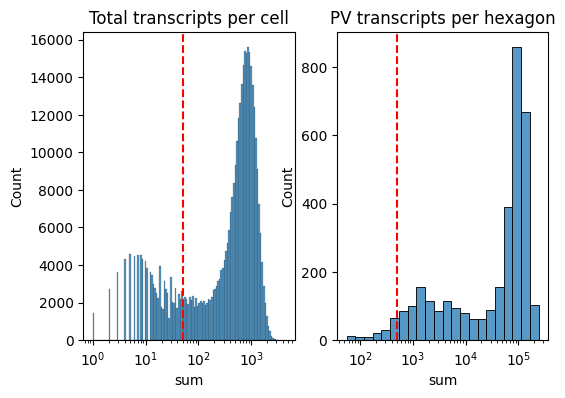

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


Processing fullres data


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Starting PCA
Starting leiden clustering
Processing pseudovisium data
Starting PCA


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Starting leiden clustering
Trying resolution: 0.01
Difference in number of clusters: 9
Trying resolution: 0.012
Difference in number of clusters: 9
Trying resolution: 0.0144
Difference in number of clusters: 9
Trying resolution: 0.01728
Difference in number of clusters: 9
Trying resolution: 0.020736
Difference in number of clusters: 9
Trying resolution: 0.0248832
Difference in number of clusters: 9
Trying resolution: 0.02985984
Difference in number of clusters: 8
Trying resolution: 0.035831808
Difference in number of clusters: 8
Trying resolution: 0.0429981696
Difference in number of clusters: 8
Trying resolution: 0.05159780351999999
Difference in number of clusters: 8
Trying resolution: 0.06191736422399999
Difference in number of clusters: 8
Trying resolution: 0.07430083706879999
Difference in number of clusters: 7
Trying resolution: 0.08916100448255998
Difference in number of clusters: 8
Trying resolution: 0.10699320537907198
Difference in number of clusters: 7
Trying resolution: 0.1

  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Fullres calculation - Time: 785.94
Pseudovisium calculation - Time: 7.17
Geary's C


  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Fullres calculation - Time: 787.26
Pseudovisium calculation - Time: 6.67
GSEA


/usr/local/lib/python3.10/dist-packages/gseapy/msigdb.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(resp.text)[0]
/usr/local/lib/python3.10/dist-packages/gseapy/msigdb.py:72: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(resp.text)[0]


  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Fullres calculation - Time: 51.37
Pseudovisium calculation - Time: 1.02


<ipython-input-129-87c2c2693c59>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  closest_hex_leiden.append(adata_pseudov.obs[col2][closest_hex])


ARI: 0.12142392751672745


/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


Markers
Sum of Squared Deviation: 12.854268502932559
Corrs
Intercept: 0.0835675790842366
Slope: 1.807893086589296
{'CosMx_Pancreas': {'time_pv': 598.4020304679871, 'csv_size': 5190178246, 'keep': False, 'loading_time_fr': 454.41038179397583, 'loading_time_pv': 0.4177536964416504, 'fullres_time_to_leiden': 34.37382388114929, 'pv_time_to_leiden': 0.337507963180542, 'fullres_size': 852.3890609741211, 'pv_size': 175.25865936279297, 'fullres_size_dense': 8114.6397705078125, 'pv_size_dense': 51.14756393432617, 'moransi_r': 0.34459136764784193, 'moransi_p': 7.414128279424333e-57, 'moransi_time_fr': 126.88709259033203, 'moransi_time_pv': 3.365706205368042, 'gearyc_r': 0.31805392501348123, 'gearyc_p': 2.9971489771508154e-48, 'gearyc_time_fr': 128.3307957649231, 'gearyc_time_pv': 2.2060129642486572, 'ari': 0.08973504939914827, 'intercept_corr': 0.0494550352022754, 'slope_corr': 1.5894785023635811, 'ssd_coexp': 21.43886044513738}, 'CosMx_mouse_brain': {'time_pv': 1497.2922303676605, 'csv_size': 7

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
<ipython-input-121-9b375f7d2363>:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_pv.obs["sum"]= np.array(np.sum(adata_pv.X,axis=1)).flatten()


Processing


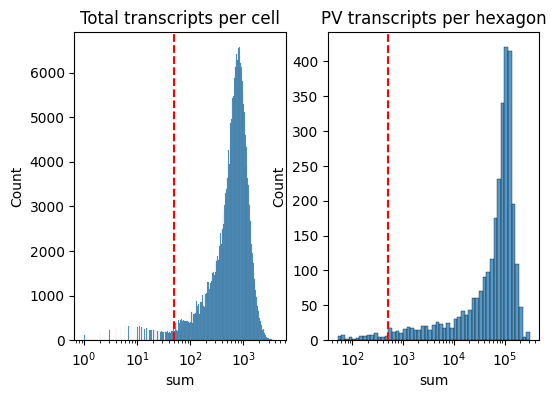

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


Processing fullres data


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Starting PCA
Starting leiden clustering
Processing pseudovisium data
Starting PCA


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Starting leiden clustering
Trying resolution: 0.01
Difference in number of clusters: 16
Trying resolution: 0.012
Difference in number of clusters: 16
Trying resolution: 0.0144
Difference in number of clusters: 15
Trying resolution: 0.01728
Difference in number of clusters: 15
Trying resolution: 0.020736
Difference in number of clusters: 14
Trying resolution: 0.0248832
Difference in number of clusters: 14
Trying resolution: 0.02985984
Difference in number of clusters: 14
Trying resolution: 0.035831808
Difference in number of clusters: 14
Trying resolution: 0.0429981696
Difference in number of clusters: 14
Trying resolution: 0.05159780351999999
Difference in number of clusters: 13
Trying resolution: 0.06191736422399999
Difference in number of clusters: 13
Trying resolution: 0.07430083706879999
Difference in number of clusters: 13
Trying resolution: 0.08916100448255998
Difference in number of clusters: 11
Trying resolution: 0.10699320537907198
Difference in number of clusters: 11
Trying r

  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Fullres calculation - Time: 804.09
Pseudovisium calculation - Time: 6.61
Geary's C


  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Fullres calculation - Time: 778.67
Pseudovisium calculation - Time: 6.01
GSEA


/usr/local/lib/python3.10/dist-packages/gseapy/msigdb.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(resp.text)[0]
/usr/local/lib/python3.10/dist-packages/gseapy/msigdb.py:72: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(resp.text)[0]


  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Fullres calculation - Time: 157.63
Pseudovisium calculation - Time: 1.65


<ipython-input-129-87c2c2693c59>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  closest_hex_leiden.append(adata_pseudov.obs[col2][closest_hex])


ARI: 0.38652474811452664


/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


Markers
Sum of Squared Deviation: 15.695635446636578
Corrs
Intercept: 0.0008906272476900927
Slope: 1.1932895667579588
{'CosMx_Pancreas': {'time_pv': 598.4020304679871, 'csv_size': 5190178246, 'keep': False, 'loading_time_fr': 454.41038179397583, 'loading_time_pv': 0.4177536964416504, 'fullres_time_to_leiden': 34.37382388114929, 'pv_time_to_leiden': 0.337507963180542, 'fullres_size': 852.3890609741211, 'pv_size': 175.25865936279297, 'fullres_size_dense': 8114.6397705078125, 'pv_size_dense': 51.14756393432617, 'moransi_r': 0.34459136764784193, 'moransi_p': 7.414128279424333e-57, 'moransi_time_fr': 126.88709259033203, 'moransi_time_pv': 3.365706205368042, 'gearyc_r': 0.31805392501348123, 'gearyc_p': 2.9971489771508154e-48, 'gearyc_time_fr': 128.3307957649231, 'gearyc_time_pv': 2.2060129642486572, 'ari': 0.08973504939914827, 'intercept_corr': 0.0494550352022754, 'slope_corr': 1.5894785023635811, 'ssd_coexp': 21.43886044513738}, 'CosMx_mouse_brain': {'time_pv': 1497.2922303676605, 'csv_size

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
<ipython-input-121-9b375f7d2363>:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_pv.obs["sum"]= np.array(np.sum(adata_pv.X,axis=1)).flatten()


Processing


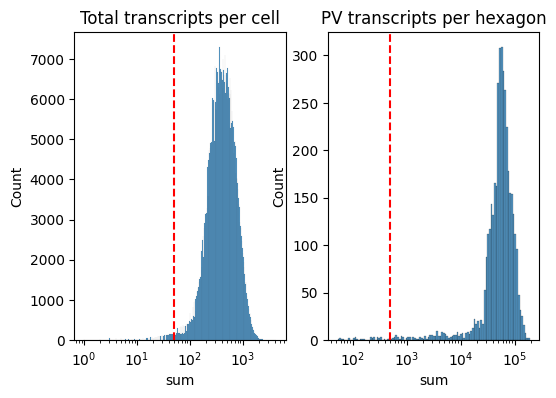

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


Processing fullres data


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Starting PCA
Starting leiden clustering
Processing pseudovisium data


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Starting PCA
Starting leiden clustering
Trying resolution: 0.01
Difference in number of clusters: 10
Trying resolution: 0.012
Difference in number of clusters: 10
Trying resolution: 0.0144
Difference in number of clusters: 10
Trying resolution: 0.01728
Difference in number of clusters: 9
Trying resolution: 0.020736
Difference in number of clusters: 9
Trying resolution: 0.0248832
Difference in number of clusters: 9
Trying resolution: 0.02985984
Difference in number of clusters: 9
Trying resolution: 0.035831808
Difference in number of clusters: 9
Trying resolution: 0.0429981696
Difference in number of clusters: 8
Trying resolution: 0.05159780351999999
Difference in number of clusters: 8
Trying resolution: 0.06191736422399999
Difference in number of clusters: 8
Trying resolution: 0.07430083706879999
Difference in number of clusters: 7
Trying resolution: 0.08916100448255998
Difference in number of clusters: 6
Trying resolution: 0.10699320537907198
Difference in number of clusters: 6
Trying

  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Fullres calculation - Time: 1463.28
Pseudovisium calculation - Time: 8.65
Geary's C


  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Fullres calculation - Time: 1400.96
Pseudovisium calculation - Time: 8.01
GSEA


/usr/local/lib/python3.10/dist-packages/gseapy/msigdb.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(resp.text)[0]
/usr/local/lib/python3.10/dist-packages/gseapy/msigdb.py:72: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(resp.text)[0]


  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Fullres calculation - Time: 118.80
Pseudovisium calculation - Time: 1.57


<ipython-input-129-87c2c2693c59>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  closest_hex_leiden.append(adata_pseudov.obs[col2][closest_hex])


ARI: 0.44930042094756495


/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


Markers
Sum of Squared Deviation: 18.77834333246485
Corrs
Intercept: 6.306825229107311e-05
Slope: 2.0021878019279487
{'CosMx_Pancreas': {'time_pv': 598.4020304679871, 'csv_size': 5190178246, 'keep': False, 'loading_time_fr': 454.41038179397583, 'loading_time_pv': 0.4177536964416504, 'fullres_time_to_leiden': 34.37382388114929, 'pv_time_to_leiden': 0.337507963180542, 'fullres_size': 852.3890609741211, 'pv_size': 175.25865936279297, 'fullres_size_dense': 8114.6397705078125, 'pv_size_dense': 51.14756393432617, 'moransi_r': 0.34459136764784193, 'moransi_p': 7.414128279424333e-57, 'moransi_time_fr': 126.88709259033203, 'moransi_time_pv': 3.365706205368042, 'gearyc_r': 0.31805392501348123, 'gearyc_p': 2.9971489771508154e-48, 'gearyc_time_fr': 128.3307957649231, 'gearyc_time_pv': 2.2060129642486572, 'ari': 0.08973504939914827, 'intercept_corr': 0.0494550352022754, 'slope_corr': 1.5894785023635811, 'ssd_coexp': 21.43886044513738}, 'CosMx_mouse_brain': {'time_pv': 1497.2922303676605, 'csv_size'

In [ ]:
names=[]
for i in range(len(datasets_to_use)-1,-1,-1):
  print(i)
  technology = datasets_to_use["Technology"].values[i]
  species = datasets_to_use["Species"].values[i]
  name=datasets_to_use["Name"].values[i]

  if name not in ["Visium_HD_pancreas_2um","Visium_HD_embryo_2um","Visium_HD_kidney_2um"]:
    continue
  #try:
  results = all_processing(results,technology,species,name)
  #except Exception as e:
  #  print(f"An error occurred while processing sample {name}: {str(e)}")

i = 1
while os.path.exists(f"results{i}.json"):
    i += 1
with open(f"results{i}.json", "w") as json_file:
    json.dump(results, json_file)

#Generate the plot for Fig 2

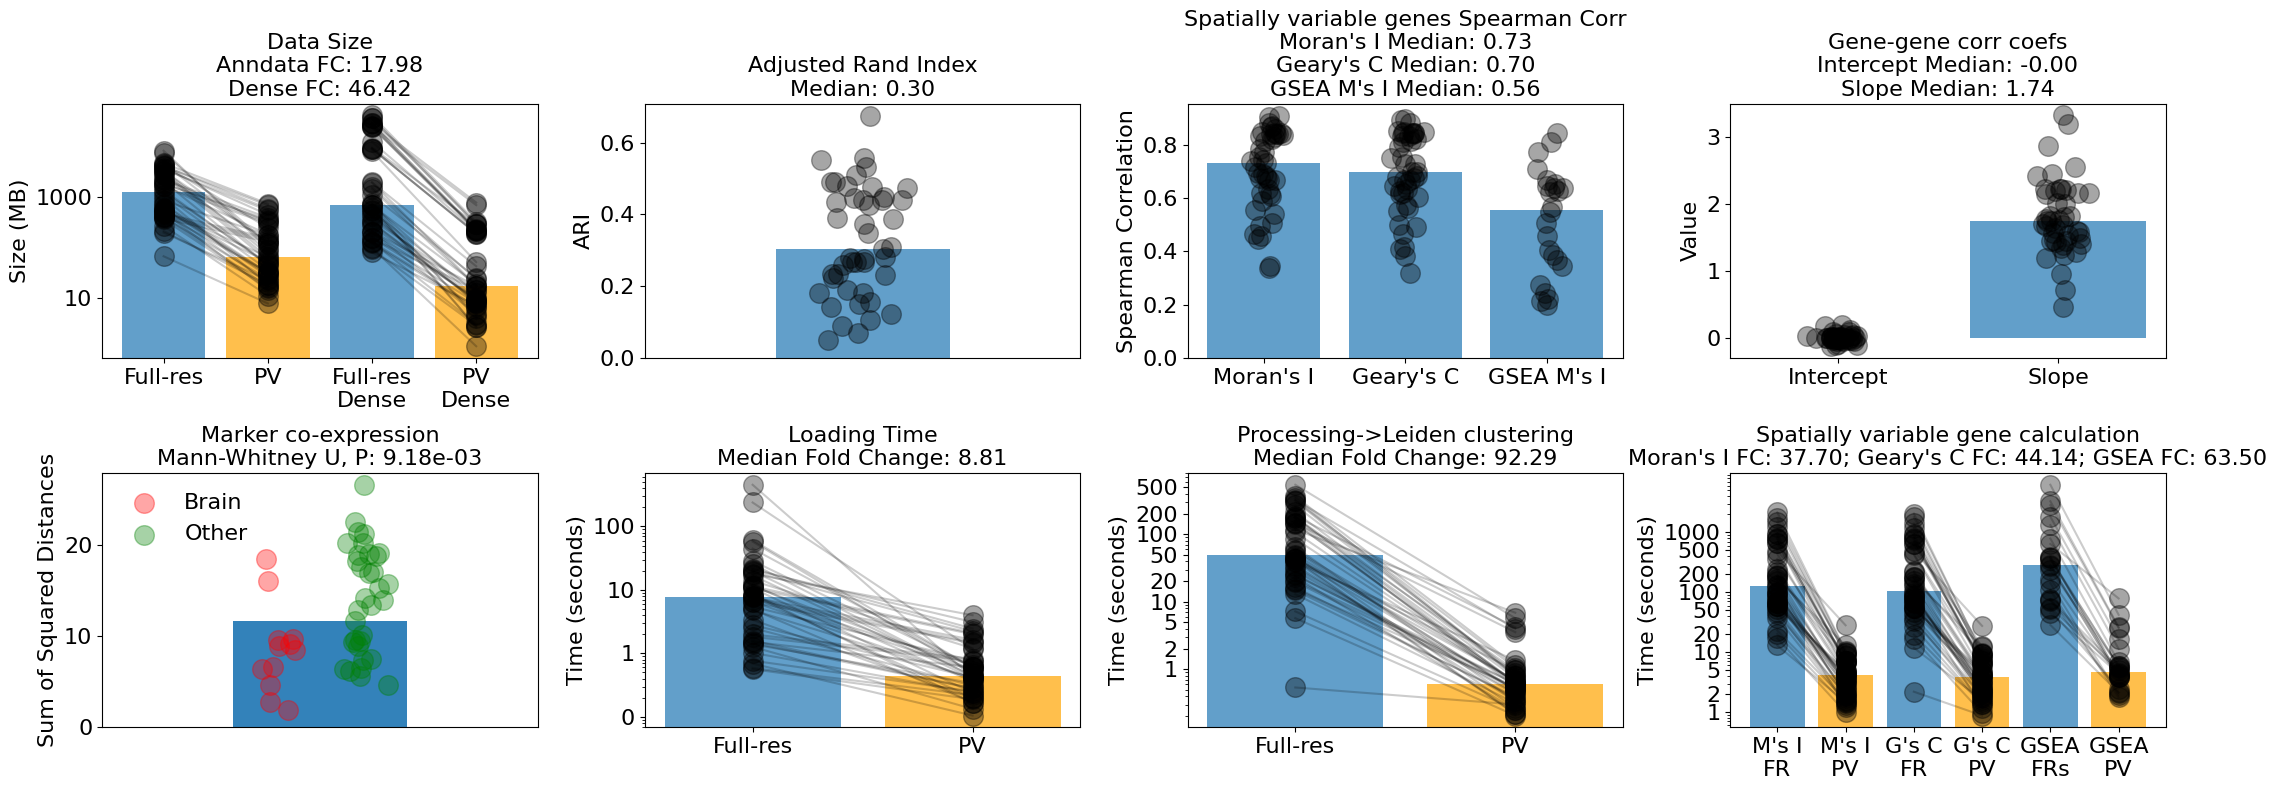

In [ ]:
data = results
plt.rcParams['font.family'] = 'Arial'  # Set Arial as the default font for all plots

loading_time_fr = [data[key]['loading_time_fr'] for key in data if 'loading_time_fr' in data[key]]
loading_time_pv = [data[key]['loading_time_pv'] for key in data if 'loading_time_pv' in data[key]]
fullres_time_to_leiden = [data[key]['fullres_time_to_leiden'] for key in data if 'fullres_time_to_leiden' in data[key]]
pv_time_to_leiden = [data[key]['pv_time_to_leiden'] for key in data if 'pv_time_to_leiden' in data[key]]
fullres_size = [data[key]['fullres_size'] for key in data if 'fullres_size' in data[key]]
pv_size = [data[key]['pv_size'] for key in data if 'pv_size' in data[key]]
fullres_size_dense = [data[key]['fullres_size_dense'] for key in data if 'fullres_size_dense' in data[key]]
pv_size_dense = [data[key]['pv_size_dense'] for key in data if 'pv_size_dense' in data[key]]
moransi_time_fr = [data[key]['moransi_time_fr'] for key in data if 'moransi_time_fr' in data[key]]
moransi_time_pv = [data[key]['moransi_time_pv'] for key in data if 'moransi_time_pv' in data[key]]
gearyc_time_fr = [data[key]['gearyc_time_fr'] for key in data if 'gearyc_time_fr' in data[key]]
gearyc_time_pv = [data[key]['gearyc_time_pv'] for key in data if 'gearyc_time_pv' in data[key]]
gsea_time_fr = [data[key]['gsea_time_fr'] for key in data if 'gsea_time_fr' in data[key]]
gsea_time_pv = [data[key]['gsea_time_pv'] for key in data if 'gsea_time_pv' in data[key]]
intercept_corr = [data[key]['intercept_corr'] for key in data if 'intercept_corr' in data[key]]
slope_corr = [data[key]['slope_corr'] for key in data if 'slope_corr' in data[key]]

ari = [data[key]['ari'] for key in data if 'ari' in data[key]]
moransi_r = [data[key]['moransi_r'] for key in data if 'moransi_r' in data[key]]
gearyc_r = [data[key]['gearyc_r'] for key in data if 'gearyc_r' in data[key]]
gsea_r = [data[key]['gsea_r'] for key in data if 'gsea_r' in data[key]]
ssd_coexp = [data[key]['ssd_coexp'] for key in data if 'ssd_coexp' in data[key]]

# Calculate mean fold changes
mean_fold_change_loading_time = np.median(np.array(loading_time_fr) / np.array(loading_time_pv))
mean_fold_change_leiden_time = np.median(np.array(fullres_time_to_leiden) / np.array(pv_time_to_leiden))
mean_fold_change_data_size = np.median(np.array(fullres_size) / np.array(pv_size))
mean_fold_change_moransi_time = np.median(np.array(moransi_time_fr) / np.array(moransi_time_pv))
mean_fold_change_gearyc_time = np.median(np.array(gearyc_time_fr) / np.array(gearyc_time_pv))
mean_fold_change_gsea_time = np.median(np.array(gsea_time_fr) / np.array(gsea_time_pv))
mean_fold_change_data_size_dense = np.median(np.array(fullres_size_dense) / np.array(pv_size_dense))

# Create a figure with eight subplots
fig, axs = plt.subplots(2, 4, figsize=(22, 8))

axs[0, 0].bar([0, 1, 2, 3], [np.median(fullres_size), np.median(pv_size), np.median(fullres_size_dense), np.median(pv_size_dense)], width=0.8, align='center', alpha=0.7, color=['#1f77b4', 'orange', '#1f77b4', 'orange'])
axs[0, 0].scatter([0] * len(fullres_size), fullres_size, color='black', marker='o', s=200, alpha=0.35)
axs[0, 0].scatter([1] * len(pv_size), pv_size, color='black', marker='o', s=200, alpha=0.35)
axs[0, 0].scatter([2] * len(fullres_size_dense), fullres_size_dense, color='black', marker='o', s=200, alpha=0.35)
axs[0, 0].scatter([3] * len(pv_size_dense), pv_size_dense, color='black', marker='o', s=200, alpha=0.35)
for i in range(len(fullres_size)):
    axs[0, 0].plot([0 , 1 ], [fullres_size[i], pv_size[i]], 'k-', alpha=0.2)
    axs[0, 0].plot([2 , 3 ], [fullres_size_dense[i], pv_size_dense[i]], 'k-', alpha=0.2)
axs[0, 0].set_xticks([0, 1, 2, 3])
axs[0, 0].set_xticklabels(['Full-res', 'PV', 'Full-res\nDense', 'PV\nDense'], rotation=0, ha='center', fontsize=16, fontname='Arial')
axs[0, 0].set_ylabel('Size (MB)', fontsize=16, fontname='Arial')
axs[0, 0].set_title(f'Data Size\nAnndata FC: {mean_fold_change_data_size:.2f}\nDense FC: {mean_fold_change_data_size_dense:.2f}', fontsize=16, fontname='Arial')
axs[0, 0].tick_params(axis='both', labelsize=16)
axs[0, 0].set_yscale('log')
axs[0, 0].yaxis.set_major_formatter(plt.ScalarFormatter())




# Extracting ARI values from data dictionary
ari_values = [v['ari'] for v in data.values() if 'ari' in v]
ari = np.array(ari_values)




# Extracting ARI values from data dictionary
ari_values = [v['ari'] for v in data.values() if 'ari' in v]
ari = np.array(ari_values)


jitter = np.random.normal(0, 0.05, len(ari))
axs[0,1].bar([0], [np.median(ari)], width=0.4, align='center', alpha=0.7, color='#1f77b4')
axs[0,1].scatter(jitter, ari, c='black', marker='o', s=200, alpha=0.35)
axs[0,1].set_xticks([])
axs[0,1].set_ylabel('ARI', fontsize=16, fontname='Arial')
axs[0,1].set_title(f'Adjusted Rand Index\nMedian: {np.median(ari):.2f}', fontsize=16, fontname='Arial')
axs[0,1].tick_params(axis='both', labelsize=16)
axs[0,1].set_xlim(-0.5, 0.5)



# Bar chart for Moran's I and Geary's C Spearman r with jitter
jitter_moransi = np.random.normal(0, 0.05, len(moransi_r))
jitter_gearyc = np.random.normal(1, 0.05, len(gearyc_r))
jitter_gsea = np.random.normal(2, 0.05, len(gsea_r))
axs[0, 2].bar([0, 1, 2], [np.median(moransi_r), np.median(gearyc_r), np.median(gsea_r)], width=0.8, align='center', alpha=0.7, color=['#1f77b4','#1f77b4', '#1f77b4'])
axs[0, 2].scatter(jitter_moransi, moransi_r, color='black', marker='o', s=200, alpha=0.35)
axs[0, 2].scatter(jitter_gearyc, gearyc_r, color='black', marker='o', s=200, alpha=0.35)
axs[0, 2].scatter(jitter_gsea, gsea_r, color='black', marker='o', s=200, alpha=0.35)
axs[0, 2].set_xticks([0, 1, 2])
axs[0, 2].set_xticklabels(['Moran\'s I', 'Geary\'s C', 'GSEA M\'s I'], rotation=0, ha='center', fontsize=16, fontname='Arial')
axs[0, 2].set_ylabel('Spearman Correlation', fontsize=16, fontname='Arial')
axs[0, 2].set_title(f'Spatially variable genes Spearman Corr\nMoran\'s I Median: {np.median(moransi_r):.2f}\nGeary\'s C Median: {np.median(gearyc_r):.2f}\nGSEA M\'s I Median: {np.median(gsea_r):.2f}', fontsize=16, fontname='Arial')
axs[0, 2].tick_params(axis='both', labelsize=16)



# Bar chart for intercept_corr and slope_corr with jitter
jitter_intercept = np.random.normal(0, 0.05, len(intercept_corr))
jitter_slope = np.random.normal(1, 0.05, len(slope_corr))
axs[0, 3].bar([0, 1], [np.median(intercept_corr), np.median(slope_corr)], width=0.8, align='center', alpha=0.7, color=['#1f77b4', '#1f77b4'])
axs[0, 3].scatter(jitter_intercept, intercept_corr, color='black', marker='o', s=200, alpha=0.35)
axs[0, 3].scatter(jitter_slope, slope_corr, color='black', marker='o', s=200, alpha=0.35)
axs[0, 3].set_xticks([0, 1])
axs[0, 3].set_xticklabels(['Intercept', 'Slope'], rotation=0, ha='center', fontsize=16, fontname='Arial')
axs[0, 3].set_ylabel('Value', fontsize=16, fontname='Arial')
axs[0, 3].set_title(f'Gene-gene corr coefs\nIntercept Median: {np.median(intercept_corr):.2f}\nSlope Median: {np.median(slope_corr):.2f}', fontsize=16, fontname='Arial')
axs[0, 3].tick_params(axis='both', labelsize=16)


axs[1, 0].bar([0], [np.median(ssd_coexp)], width=0.4, align='center', alpha=0.7, color='#1f77b4')

brain_data = []
other_data = []
for d in data:
    if 'ssd_coexp' in data[d]:
        if 'brain' in d.lower():
            brain_data.append(data[d]['ssd_coexp'])
        else:
            other_data.append(data[d]['ssd_coexp'])

# Add jitter to the scatter points
brain_jitter = np.random.normal(0, 0.025, len(brain_data))
other_jitter = np.random.normal(0, 0.025, len(other_data))
import numpy as np
import scipy.stats

# Extract sum of squared distances values and split into brain and non-brain groups
ssd_brain = np.array([data[d]['ssd_coexp'] for d in data if 'ssd_coexp' in data[d] and 'brain' in d.lower()])
ssd_nonbrain = np.array([data[d]['ssd_coexp'] for d in data if 'ssd_coexp' in data[d] and 'brain' not in d.lower()])

# Perform Mann-Whitney U test for sum of squared distances
ssd_mannwhitneyu = scipy.stats.mannwhitneyu(ssd_brain, ssd_nonbrain)

axs[1, 0].bar([0], [np.median(ssd_coexp)], width=0.4, align='center', alpha=0.7, color='#1f77b4')

axs[1, 0].scatter([0 - 0.1] + brain_jitter, brain_data, c='red', marker='o', s=200, alpha=0.35, label='Brain')
axs[1, 0].scatter([0 + 0.1] + other_jitter, other_data, c='green', marker='o', s=200, alpha=0.35, label='Other')

axs[1, 0].set_xticks([])
axs[1, 0].set_ylabel('Sum of Squared Distances', fontsize=16, fontname='Arial')
axs[1, 0].set_title(f'Marker co-expression\nMann-Whitney U, P: {ssd_mannwhitneyu.pvalue:.2e}', fontsize=16, fontname='Arial')
axs[1, 0].tick_params(axis='both', labelsize=16)
axs[1, 0].set_xlim(-0.5, 0.5)

# Add the legend to the plot
axs[1, 0].legend(loc='upper left', fontsize=16, frameon=False)



# Strip-bar plot for loading_time_fr and loading_time_pv
axs[1, 1].bar([0, 1], [np.median(loading_time_fr), np.median(loading_time_pv)], width=0.8, align='center', alpha=0.7, color=['#1f77b4', 'orange'])
axs[1, 1].scatter([0] * len(loading_time_fr), loading_time_fr, color='black', marker='o', s=200, alpha=0.35)
axs[1, 1].scatter([1] * len(loading_time_pv), loading_time_pv, color='black', marker='o', s=200, alpha=0.35)
for i in range(len(loading_time_fr)):
    axs[1, 1].plot([0, 1], [loading_time_fr[i], loading_time_pv[i]],  'k-', alpha=0.2)
axs[1, 1].set_xticks([0, 1])
axs[1, 1].set_xticklabels(['Full-res', 'PV'], rotation=0, ha='center', fontsize=16, fontname='Arial')
axs[1, 1].set_ylabel('Time (seconds)', fontsize=16, fontname='Arial')
axs[1, 1].set_title(f'Loading Time\nMedian Fold Change: {mean_fold_change_loading_time:.2f}', fontsize=16, fontname='Arial')
axs[1, 1].tick_params(axis='both', labelsize=16)
axs[1, 1].set_yscale('log')
axs[1, 1].yaxis.set_major_formatter(plt.ScalarFormatter())




# Strip-bar plot for fullres_time_to_leiden and pv_time_to_leiden
axs[1, 2].bar([0, 1], [np.median(fullres_time_to_leiden), np.median(pv_time_to_leiden)], width=0.8, align='center', alpha=0.7, color=['#1f77b4', 'orange'])
axs[1, 2].scatter([0] * len(fullres_time_to_leiden), fullres_time_to_leiden, color='black', marker='o', s=200, alpha=0.35)
axs[1, 2].scatter([1] * len(pv_time_to_leiden), pv_time_to_leiden, color='black', marker='o', s=200, alpha=0.35)
for i in range(len(fullres_time_to_leiden)):
    axs[1, 2].plot([0, 1], [fullres_time_to_leiden[i], pv_time_to_leiden[i]],  'k-', alpha=0.2)
axs[1, 2].set_xticks([0, 1])
axs[1, 2].set_xticklabels(['Full-res', 'PV'], rotation=0, ha='center', fontsize=16, fontname='Arial')
axs[1, 2].set_ylabel('Time (seconds)', fontsize=16, fontname='Arial')
axs[1, 2].set_title(f'Processing->Leiden clustering\nMedian Fold Change: {mean_fold_change_leiden_time:.2f}', fontsize=16, fontname='Arial')
axs[1, 2].tick_params(axis='both', labelsize=16)
axs[1, 2].set_yscale('log')
axs[1, 2].set_yticks([1,2,5,10,20, 50, 100,200, 500])
axs[1, 2].yaxis.set_major_formatter(plt.ScalarFormatter())


# Strip-bar plot for moransi_time_fr and moransi_time_pv, gearyc_time_fr and gearyc_time_pv
axs[1, 3].bar([0, 1, 2, 3,4,5], [np.median(moransi_time_fr), np.median(moransi_time_pv), np.median(gearyc_time_fr), np.median(gearyc_time_pv),  np.median(gsea_time_fr), np.median(gsea_time_pv)], width=0.8, align='center', alpha=0.7, color=['#1f77b4', 'orange','#1f77b4', 'orange','#1f77b4', 'orange'])
axs[1, 3].scatter([0] * len(moransi_time_fr), moransi_time_fr, color='black', marker='o', s=200, alpha=0.35)
axs[1, 3].scatter([1] * len(moransi_time_pv), moransi_time_pv, color='black', marker='o', s=200, alpha=0.35)
axs[1, 3].scatter([2] * len(gearyc_time_fr), gearyc_time_fr, color='black', marker='o', s=200, alpha=0.35)
axs[1, 3].scatter([3] * len(gearyc_time_pv), gearyc_time_pv, color='black', marker='o', s=200, alpha=0.35)
axs[1, 3].scatter([4] * len(gsea_time_fr), gsea_time_fr, color='black', marker='o', s=200, alpha=0.35)
axs[1, 3].scatter([5] * len(gsea_time_pv), gsea_time_pv, color='black', marker='o', s=200, alpha=0.35)
for i in range(len(moransi_time_fr)):
    axs[1, 3].plot([0 , 1 ], [moransi_time_fr[i], moransi_time_pv[i]], 'k-', alpha=0.2)
    axs[1, 3].plot([2 , 3 ], [gearyc_time_fr[i], gearyc_time_pv[i]], 'k-', alpha=0.2)
for i in range(len(gsea_time_fr)):
    axs[1, 3].plot([4 , 5 ], [gsea_time_fr[i], gsea_time_pv[i]], 'k-', alpha=0.2)
axs[1, 3].set_xticks([0, 1, 2, 3,4,5])
axs[1, 3].set_xticklabels(['M\'s I\nFR', 'M\'s I\nPV', 'G\'s C\nFR', 'G\'s C\nPV', 'GSEA\nFRs', 'GSEA\nPV'], rotation=0, ha='center', fontsize=16, fontname='Arial')
axs[1, 3].set_ylabel('Time (seconds)', fontsize=16, fontname='Arial')
axs[1, 3].set_title(f'Spatially variable gene calculation\nMoran\'s I FC: {mean_fold_change_moransi_time:.2f}; Geary\'s C FC: {mean_fold_change_gearyc_time:.2f}; GSEA FC: {mean_fold_change_gsea_time:.2f}', fontsize=16, fontname='Arial')
axs[1, 3].tick_params(axis='both', labelsize=16)
axs[1, 3].set_yscale('log')
axs[1, 3].set_yticks([1,2,5,10,20, 50, 100,200, 500,1000])
axs[1, 3].yaxis.set_major_formatter(plt.ScalarFormatter())

# Adjust the spacing between subplots
plt.tight_layout()

Get additional datasets, not used above, but valuable for the cross technology comparisons.


In [ ]:
datasets = pd.read_excel("/content/Datasets_all.xlsx")
datasets_to_use = datasets[(datasets["Comparing_all_tech"]==1)&(datasets["PV_workflow_comparison"]!=1)]
#remove those without link
datasets_to_use = datasets_to_use[~datasets_to_use["Onedrive_link"].isna()]
datasets_to_use.reset_index(drop=True,inplace=True)
datasets_to_use

,Author,Year,Paper_DOI,Link_to_dataset,Onedrive_link,Name,Technology,Tissue,Species,Visium_xenium_notebook,Allen_Brain_Merfish,PV_workflow_comparison,Comparing_all_tech,Pulmonary Xenium,Cosmx_lung,Dataset_merge_visium,Brain case study,Just Visium example
0,Denisenko et al.,2024.0,DOI: 10.1038/s41467-024-47271-y,NaN,https://cw1oqa.bl.files.1drv.com/y4ms839bushVl...,CosMx_ovarian,CosMx,Ovarian_cancer,Human,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
1,Denisenko et al.,2024.0,DOI: 10.1038/s41467-024-47271-y,NaN,https://zm1oqa.bl.files.1drv.com/y4mg6GhhT2pXj...,Visium_ovarian,Visium,Ovarian_cancer,Human,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
2,Janesick et al.,2023.0,https://doi.org/10.1038/s41467-023-43458-x,NaN,https://cpl1ng.bl.files.1drv.com/y4mDMy6l7qZvS...,Visium_breast_Sample_1,Visium,Breast cancer,Human,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN
3,Vizgen,NaN,NaN,https://www.nature.com/articles/s41586-024-071...,https://9gwjhw.bl.files.1drv.com/y4mrCNSO11NsO...,Vizgen_heart_1,Vizgen,Heart,Human,NaN,NaN,0.0,1.0,NaN,0.0,0.0,NaN,NaN
4,Vizgen,NaN,NaN,https://www.nature.com/articles/s41586-024-071...,https://x2ozbw.bl.files.1drv.com/y4mtovAhc1ZfV...,Vizgen_heart_2,Vizgen,Heart,Human,NaN,NaN,0.0,1.0,NaN,0.0,0.0,NaN,NaN
5,Vizgen,NaN,NaN,https://www.nature.com/articles/s41586-024-071...,https://kyhkwq.bl.files.1drv.com/y4mJqLlLYInNy...,Vizgen_heart_3,Vizgen,Heart,Human,NaN,NaN,0.0,1.0,NaN,0.0,0.0,NaN,NaN
6,Vizgen,NaN,NaN,https://www.nature.com/articles/s41586-024-071...,https://cg1lba.bl.files.1drv.com/y4mQfVBPq-hZA...,Vizgen_heart_4,Vizgen,Heart,Human,NaN,NaN,0.0,1.0,NaN,NaN,0.0,NaN,NaN
7,Wu et al.,2024.0,https://doi.org/10.1111/acel.14109,GSM5773453,https://jcgr5w.bl.files.1drv.com/y4mdpOjO3J91P...,Visium_GSM5773453,Visium,Brain,Mouse,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0
8,Wu et al.,2024.0,https://doi.org/10.1111/acel.14109,GSM5773457,https://kd25iq.bl.files.1drv.com/y4m0bQ8gUOcrd...,Visium_GSM5773457,Visium,Brain,Mouse,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0
9,10X,2024.0,NaN,https://www.10xgenomics.com/datasets/adult-mou...,https://kyhnwq.bl.files.1drv.com/y4mVei1sn6_3j...,Visium_olf_bulb,Visium,Olfactory bulb,Mouse,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Create a thread pool with a maximum of 10 threads
with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
    # Submit download and unzip tasks to the thread pool
    futures = [executor.submit(download_and_unzip, row.to_dict()) for _, row in datasets_to_use.reset_index(drop=True).iterrows()]

    # Wait for all tasks to complete
    concurrent.futures.wait(futures)

Processing dataset: CosMx_ovarian
Download link: https://cw1oqa.bl.files.1drv.com/y4ms839bushVlMVuUlw2uCByO4VXwsgOAhy-ao2lOPumNVphhoXv8NQ0zocupGBLVlySH2HjkoXHCGQccXR2LS7uhQr5AaYLncBdQAN3z_5i98WcQ_tvnSCAzYmTetN5zbtIikutZzU7MpVjq1ffQBx_vcfNc3NVZSAyJHbuj9jiBC93D_iyTR_Cz1vvnFD4PtzfmS6NPpY-3nYYEmJaIfOWA
Processing dataset: Visium_ovarian
Download link: https://zm1oqa.bl.files.1drv.com/y4mg6GhhT2pXjR8Z07n6MfT1x_8KfVoMGXyqQVY6Iz2ttKka4oSddm8j-6D6BR2BZbaYurMp-0piwHKUNbMXyvmQYZA7o08bKmWgqmS6UZjMMKkU0gUayVX0Q1nWzF3EUg61_KZyFhsZ6pHZEWW68_4bU6E0MzUfykQl8VC1B8K2ZlJ3oNvoV3aDwuE7rUr-44eOixp552swhUzAwpfVHJTNQ
Processing dataset: Visium_breast_Sample_1
Download link: https://cpl1ng.bl.files.1drv.com/y4mDMy6l7qZvSj1vUyjQfT5QyCqN64u8WQ5thldxVgUVI2llYdJyeqSdUXYa-xom8upo_Z4AuhrFPqQDcMrBg9yk1VSMYpI8QiMqwU-lVLzPoiJ5j4tdLE4TFOx4T3xX06kUjjX-HjbSwPR8X6ADx74gE7eY8Dhu611om1LaLD-8OBESU5TENz8l_f7TQXoCp6kV93n6H1feyMeZhaH2jqJeA
Processing dataset: Vizgen_heart_1
Download link: https://9gwjhw.bl.files.1drv.com/y4mrCNS

In [ ]:
!rm /content/CosMx_ovarian/SP5_Run5452_S2/CXC10_tx_file.csv
!rm /content/CosMx_ovarian/SP5_Run5452_S2/CXCR3_tx_file.csv

In [ ]:
#results = {}

In [ ]:
datasets_to_use = datasets_to_use[datasets_to_use["Technology"]!="Visium"]
datasets_to_use.reset_index(drop=True,inplace=True)
datasets_to_use

,Author,Year,Paper_DOI,Link_to_dataset,Onedrive_link,Name,Technology,Tissue,Species,Visium_xenium_notebook,Allen_Brain_Merfish,PV_workflow_comparison,Comparing_all_tech,Pulmonary Xenium,Cosmx_lung,Dataset_merge_visium,Brain case study,Just Visium example
0,Denisenko et al.,2024.0,DOI: 10.1038/s41467-024-47271-y,NaN,https://cw1oqa.bl.files.1drv.com/y4ms839bushVl...,CosMx_ovarian,CosMx,Ovarian_cancer,Human,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
1,Vizgen,NaN,NaN,https://www.nature.com/articles/s41586-024-071...,https://9gwjhw.bl.files.1drv.com/y4mrCNSO11NsO...,Vizgen_heart_1,Vizgen,Heart,Human,NaN,NaN,0.0,1.0,NaN,0.0,0.0,NaN,NaN
2,Vizgen,NaN,NaN,https://www.nature.com/articles/s41586-024-071...,https://x2ozbw.bl.files.1drv.com/y4mtovAhc1ZfV...,Vizgen_heart_2,Vizgen,Heart,Human,NaN,NaN,0.0,1.0,NaN,0.0,0.0,NaN,NaN
3,Vizgen,NaN,NaN,https://www.nature.com/articles/s41586-024-071...,https://kyhkwq.bl.files.1drv.com/y4mJqLlLYInNy...,Vizgen_heart_3,Vizgen,Heart,Human,NaN,NaN,0.0,1.0,NaN,0.0,0.0,NaN,NaN
4,Vizgen,NaN,NaN,https://www.nature.com/articles/s41586-024-071...,https://cg1lba.bl.files.1drv.com/y4mQfVBPq-hZA...,Vizgen_heart_4,Vizgen,Heart,Human,NaN,NaN,0.0,1.0,NaN,NaN,0.0,NaN,NaN


In [ ]:
from Pseudovisium.pseudovisium_generate import generate_pv
output_path="/content/"
hexagon_size=50
max_workers=16
errors=[]
for i in range(len(datasets_to_use)):
    try:
      start_pv = time.time()
      technology = datasets_to_use["Technology"].values[i]
      name=datasets_to_use["Name"].values[i]
      tissue = datasets_to_use["Tissue"].values[i]
      h5_x_colname="Raw_Slideseq_X"
      h5_y_colname="Raw_Slideseq_Y"
      if technology != "Visium_HD" and technology != "Curio":
        csv_file = find_csv_with_transcript("/content/"+name+"/")
        print(csv_file)
        visium_hd_folder=None
      elif technology == "Visium_HD":
        csv_file = None
        visium_hd_folder = find_any_file_within_folder("/content/"+name+"/","filtered_feature_bc_matrix.h5").split("filtered_feature_bc_matrix.h5")[0]
      elif technology == "Curio":
        csv_file = None
        visium_hd_folder = find_any_file_within_folder("/content/"+name+"/","h5ad").split("Puck")[0]
        if tissue == "Ovary":
          visium_hd_folder = find_any_file_within_folder("/content/"+name+"/","h5ad").split("GSM")[0]
          h5_x_colname="x"
          h5_y_colname="y"
      if "heart" in name:
        csv_file = find_any_file_within_folder("/content/"+name+"/","_barcodes.csv")

      if technology == "CosMx":
        ctu= 0.12028
      elif technology == "CosMx_prototype":
        ctu=0.18
        technology = "CosMx"
      else:
        ctu=1

      print("CTU: ", ctu)

      if technology == "CosMx":
      #getting unique cell names for old SMI data
        df = pd.read_csv(csv_file)
        if 'cell' not in df.columns:
          # Create a new column called 'cell' by concatenating 'fov' and 'cell_ID' columns
          df['cell'] = df['fov'].astype(str) + '_' + df['cell_ID'].astype(str)

          # Save the updated DataFrame back to the original CSV file
          df.to_csv(csv_file, index=False)
          print("cell column added!")

      print(technology)
      print(visium_hd_folder)

      quality_filter = True if technology=="Xenium" else False

      generate_pv(csv_file=csv_file,
                  visium_hd_folder=visium_hd_folder,
                  hexagon_size=hexagon_size,
                  output_path=output_path,
                  batch_size=2000000,
                  technology=technology,
                  max_workers=max_workers,
                  quality_filter=quality_filter,
                  project_name=name,

                  coord_to_um_conversion=ctu,
                  h5_x_colname=h5_x_colname, #this is just here for the Curio samples
                  h5_y_colname=h5_y_colname) #this is just here for the Curio samples


      end_pv = time.time()
      time_pv = end_pv-start_pv
      csv_file = find_csv_with_transcript("/content/"+name+"/")
      if "heart" in name:
        csv_file = find_any_file_within_folder("/content/"+name+"/","_barcodes.csv")
      results[name]={}
      results[name]["time_pv"]=time_pv
      results[name]["csv_size"] = os.path.getsize(csv_file)
      print(results)
    except:
      errors.append(name)
      print(errors)


None
CTU:  1
Vizgen
None
You are using version:  ['Pseudovisium==0.0.41']
Date:  2024-06-19
Technology is Vizgen. Going forward with default column names.
Quality filter is set to False
Quality counting per hexagon is set to False
Quality counting per probe is set to False
Created temporary directory /tmp/tmp_hexahn0xt17i
Now creating batches
Created batch 1
Created batch 2
Created batch 3
Created batch 4
Created batch 5
Created batch 6
Created batch 7
Created batch 8
Created batch 9
Created batch 10
Created batch 11
Created batch 12
Created batch 13
Created batch 14
Created batch 15
Created batch 16
Created batch 17
Created batch 18
Created batch 19
Created batch 20
Created batch 21
Created batch 22
Created batch 23
Finished preprocessing. Total batches created: 23
Processing batches using 16 processes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Processing batches: 100%|██████████| 23/23 [00:42<00:00,  1.83s/batch]


Creating pseudovisium folder in output path:/content//pseudovisium/Vizgen_heart_1
Using already existing folder: /content//pseudovisium/
Creating scalefactors_json.json file in spatial folder.
Creating barcodes.tsv.gz file in spatial folder.
Creating tissue_positions_list.csv file in spatial folder.
No cell information provided. Skipping cell information files.
No quality information provided. Skipping quality information files.
No quality information provided. Skipping quality information files.
Creating features.tsv.gz file in spatial folder.
Putting together the matrix.mtx file
Total matrix count: 44717174.0
Number of unique hexagons: 2870
Creating matrix.mtx.gz file in spatial folder.
Putting together the filtered_feature_bc_matrix.h5 file
No image file provided. Drawing tissue positions on a white background.
Creating arguments.json file in output path.
Time taken: 344.2608766555786 seconds
Searching for temporary batch files in: /tmp
No remaining temporary batch files found.
['Vi

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Processing batches: 100%|██████████| 12/12 [00:21<00:00,  1.77s/batch]


Creating pseudovisium folder in output path:/content//pseudovisium/Vizgen_heart_2
Using already existing folder: /content//pseudovisium/
Creating scalefactors_json.json file in spatial folder.
Creating barcodes.tsv.gz file in spatial folder.
Creating tissue_positions_list.csv file in spatial folder.
No cell information provided. Skipping cell information files.
No quality information provided. Skipping quality information files.
No quality information provided. Skipping quality information files.
Creating features.tsv.gz file in spatial folder.
Putting together the matrix.mtx file
Total matrix count: 23820923.0
Number of unique hexagons: 1256
Creating matrix.mtx.gz file in spatial folder.
Putting together the filtered_feature_bc_matrix.h5 file
No image file provided. Drawing tissue positions on a white background.
Creating arguments.json file in output path.
Time taken: 180.94075202941895 seconds
Searching for temporary batch files in: /tmp
No remaining temporary batch files found.
['V

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Processing batches: 100%|██████████| 26/26 [00:46<00:00,  1.80s/batch]


Creating pseudovisium folder in output path:/content//pseudovisium/Vizgen_heart_3
Using already existing folder: /content//pseudovisium/
Creating scalefactors_json.json file in spatial folder.
Creating barcodes.tsv.gz file in spatial folder.
Creating tissue_positions_list.csv file in spatial folder.
No cell information provided. Skipping cell information files.
No quality information provided. Skipping quality information files.
No quality information provided. Skipping quality information files.
Creating features.tsv.gz file in spatial folder.
Putting together the matrix.mtx file
Total matrix count: 51294403.0
Number of unique hexagons: 3019
Creating matrix.mtx.gz file in spatial folder.
Putting together the filtered_feature_bc_matrix.h5 file
No image file provided. Drawing tissue positions on a white background.
Creating arguments.json file in output path.
Time taken: 386.81802320480347 seconds
Searching for temporary batch files in: /tmp
No remaining temporary batch files found.
['V

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Processing batches: 100%|██████████| 37/37 [01:05<00:00,  1.78s/batch]


Creating pseudovisium folder in output path:/content//pseudovisium/Vizgen_heart_4
Using already existing folder: /content//pseudovisium/
Creating scalefactors_json.json file in spatial folder.
Creating barcodes.tsv.gz file in spatial folder.
Creating tissue_positions_list.csv file in spatial folder.
No cell information provided. Skipping cell information files.
No quality information provided. Skipping quality information files.
No quality information provided. Skipping quality information files.
Creating features.tsv.gz file in spatial folder.
Putting together the matrix.mtx file
Total matrix count: 72795387.0
Number of unique hexagons: 3232
Creating matrix.mtx.gz file in spatial folder.
Putting together the filtered_feature_bc_matrix.h5 file
No image file provided. Drawing tissue positions on a white background.
Creating arguments.json file in output path.
Time taken: 543.9175724983215 seconds
Searching for temporary batch files in: /tmp
No remaining temporary batch files found.
['Vi

Also add csv sizes!


In [ ]:
from Pseudovisium.pseudovisium_generate import generate_pv
output_path="/content/"
hexagon_size=50
max_workers=16
errors=[]
for i in range(len(datasets_to_use)):
    #try:

      name=datasets_to_use["Name"].values[i]
      csv_file = find_csv_with_transcript("/content/"+name+"/")
      if "heart" in name:
        csv_file = find_any_file_within_folder("/content/"+name+"/","_barcodes.csv")
      results[name]["csv_size"] = os.path.getsize(csv_file)
      print(results)
    #except:
     # errors.append(name)
     # print(errors)

{'CosMx_Pancreas': {'time_pv': 598.4020304679871, 'csv_size': 5190178246, 'keep': False, 'loading_time_fr': 454.41038179397583, 'loading_time_pv': 0.4177536964416504, 'fullres_time_to_leiden': 34.37382388114929, 'pv_time_to_leiden': 0.337507963180542, 'fullres_size': 852.3890609741211, 'pv_size': 175.25865936279297, 'fullres_size_dense': 8114.6397705078125, 'pv_size_dense': 51.14756393432617, 'moransi_r': 0.34459136764784193, 'moransi_p': 7.414128279424333e-57, 'moransi_time_fr': 126.88709259033203, 'moransi_time_pv': 3.365706205368042, 'gearyc_r': 0.31805392501348123, 'gearyc_p': 2.9971489771508154e-48, 'gearyc_time_fr': 128.3307957649231, 'gearyc_time_pv': 2.2060129642486572, 'ari': 0.08973504939914827, 'intercept_corr': 0.0494550352022754, 'slope_corr': 1.5894785023635811, 'ssd_coexp': 21.43886044513738}, 'CosMx_mouse_brain': {'time_pv': 1497.2922303676605, 'csv_size': 7149608009, 'keep': True, 'loading_time_fr': 4.934450626373291, 'loading_time_pv': 0.16774845123291016, 'fullres_ti

In [ ]:
import os
import shutil

# Set the directory path
directory = "/content/pv_qc_2024-05-18"

# Create a new zip file with the same name as the directory
zip_filename = os.path.basename(directory) + ".zip"

# Check if the directory exists
if os.path.isdir(directory):
    # Create the zip archive
    shutil.make_archive(zip_filename[:-4], "zip", base_dir=directory)
    print(f"Zip file created: {zip_filename}")
else:
    print(f"Directory '{directory}' does not exist.")

Zip file created: pv_qc_2024-05-18.zip


In [ ]:
import os

# Specify the directory path
directory = "/content/pseudovisium/"

# Get a list of all subfolders in the directory with their full paths
folders = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]

folders.append("/content/Visium_brain/V1_Adult_Mouse_Brain")
folders.append("/content/Visium_breast_cancer/Visium_Human_Breast_Cancer")
folders.append("/content/Visium_embryo/CytAssist_11mm_FFPE_Mouse_Embryo")
folders.append("/content/Visium_kidney_human/CytAssist_11mm_FFPE_Human_Kidney")
folders.append("/content/Visium_kidney_mouse/Visium_FFPE_Mouse_Kidney")
folders.append("/content/Visium_olf_bulb/Visium_Mouse_Olfactory_Bulb")
folders.append("/content/Visium_ovarian_cancer/Visium_FFPE_Human_Ovarian_Cancer")



# Print the list of subfolders with their full paths
for subfolder in folders:
    print(subfolder)





/content/pseudovisium/Visium_HD_embryo_2um
/content/pseudovisium/Xenium_colon
/content/pseudovisium/Curio_ovary_11hr
/content/pseudovisium/Vizgen_heart_4
/content/pseudovisium/Xenium_melanoma
/content/pseudovisium/Xenium_ovarian
/content/pseudovisium/Xenium_colorectal
/content/pseudovisium/Curio_brain_3
/content/pseudovisium/Xenium_breast_Sample_2
/content/pseudovisium/Vizgen_ovarian_cancer_pt1
/content/pseudovisium/CosMx_glioma
/content/pseudovisium/Vizgen_brain_allen_12
/content/pseudovisium/Xenium_skin
/content/pseudovisium/Curio_brain_2
/content/pseudovisium/Vizgen_liver_2
/content/pseudovisium/CosMx_ovarian
/content/pseudovisium/Vizgen_brain_allen_4
/content/pseudovisium/CosMx_nsclc_9_1
/content/pseudovisium/CosMx_nsclc_5_1
/content/pseudovisium/Xenium_tonsil
/content/pseudovisium/Xenium_whole_mouse_pup
/content/pseudovisium/Xenium_breast_Sample_1_rep1
/content/pseudovisium/Xenium_glioma
/content/pseudovisium/Curio_ovary_6hr
/content/pseudovisium/Vizgen_heart_2
/content/pseudovisi

In [ ]:
#from Pseudovisium.pseudovisium_qc import generate_qc_report
from Pseudovisium.pseudovisium_qc import generate_qc_report
output_folder="/content/"
gene_names=["Ace2"]
generate_qc_report(folders,
                   output_folder,
                   gene_names,
                   include_morans_i=True,
                   max_workers=16,
                   normalisation=True,
                   save_plots=True,
                   squidpy=True)

Plots will be saved
Going ahead with the squidpy implementation. Only worth doing for large datasets.
Loading squidpy and scanpy


Processing folders:   0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Not enough negative control probes found, skipping Moran's I calculation


Processing folders:   2%|▏         | 1/59 [06:32<6:19:26, 392.53s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.095923931250582e-11' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val


folder /content/pseudovisium/Xenium_colon/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:   3%|▎         | 2/59 [07:26<3:03:44, 193.42s/it]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: Runti

folder /content/pseudovisium/Curio_ovary_11hr/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:   5%|▌         | 3/59 [11:13<3:14:41, 208.60s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.009620045792349985' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df

folder /content/pseudovisium/Vizgen_heart_4/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.99444887e-08]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:   7%|▋         | 4/59 [11:35<2:03:37, 134.87s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1102230246251565e-16' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_

folder /content/pseudovisium/Xenium_melanoma/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


/usr/local/lib/python3.10/dist-packages/scanpy/metrics/_common.py:62: UserWarning: 1 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.28262417e-10]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:   8%|▊         | 5/59 [11:51<1:22:58, 92.19s/it] /usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.91402449445377e-13' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df

folder /content/pseudovisium/Xenium_ovarian/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


/usr/local/lib/python3.10/dist-packages/scanpy/metrics/_common.py:62: UserWarning: 1 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  10%|█         | 6/59 [12:15<1:00:55, 68.98s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: 

folder /content/pseudovisium/Xenium_colorectal/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  12%|█▏        | 7/59 [12:47<49:18, 56.89s/it]  /usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a futu

folder /content/pseudovisium/Curio_brain_3/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


/usr/local/lib/python3.10/dist-packages/scanpy/metrics/_common.py:62: UserWarning: 1 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  14%|█▎        | 8/59 [23:23<3:25:03, 241.24s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219:

folder /content/pseudovisium/Xenium_breast_Sample_2/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


/usr/local/lib/python3.10/dist-packages/scanpy/metrics/_common.py:62: UserWarning: 5 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  15%|█▌        | 9/59 [23:49<2:24:56, 173.93s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.2039631693958626e-05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_

folder /content/pseudovisium/Vizgen_ovarian_cancer_pt1/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  17%|█▋        | 10/59 [25:55<2:10:05, 159.29s/it]/usr/local/lib/python3.10/dist-packages/libpysal/weights/distance.py:153: Us

folder /content/pseudovisium/CosMx_glioma/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


/usr/local/lib/python3.10/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[6.66133815e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  19%|█▊        | 11/59 [26:09<1:31:38, 114.56s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.004423749245711539' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_d

folder /content/pseudovisium/Vizgen_brain_allen_12/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  20%|██        | 12/59 [26:49<1:12:11, 92.16s/it] /usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2588531558055394e-05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot

folder /content/pseudovisium/Xenium_skin/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


/usr/local/lib/python3.10/dist-packages/scanpy/metrics/_common.py:62: UserWarning: 96 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  22%|██▏       | 13/59 [27:09<53:52, 70.28s/it]  /usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a fut

folder /content/pseudovisium/Curio_brain_2/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  24%|██▎       | 14/59 [33:09<1:58:17, 157.73s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6620378164297047' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df[

folder /content/pseudovisium/Vizgen_liver_2/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.86859988e-10]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  25%|██▌       | 15/59 [34:03<1:32:35, 126.26s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219

folder /content/pseudovisium/CosMx_ovarian/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  27%|██▋       | 16/59 [34:18<1:06:40, 93.04s/it] /usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.002365103120731904' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_d

folder /content/pseudovisium/Vizgen_brain_allen_4/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.75415238e-14]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  29%|██▉       | 17/59 [34:37<49:22, 70.53s/it]  /usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.22253998443500778' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df[

folder /content/pseudovisium/CosMx_nsclc_9_1/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  31%|███       | 18/59 [34:53<36:59, 54.13s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0011300007122873046' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df[

folder /content/pseudovisium/CosMx_nsclc_5_1/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  32%|███▏      | 19/59 [35:11<28:55, 43.38s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0002930241543768197' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df[

folder /content/pseudovisium/Xenium_tonsil/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  34%|███▍      | 20/59 [36:39<37:00, 56.93s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.3425705819590803e-14' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df

folder /content/pseudovisium/Xenium_whole_mouse_pup/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  36%|███▌      | 21/59 [42:29<1:31:37, 144.66s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219

folder /content/pseudovisium/Xenium_breast_Sample_1_rep1/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  37%|███▋      | 22/59 [43:04<1:08:54, 111.74s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.79585252119341e-13' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_d

folder /content/pseudovisium/Xenium_glioma/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  39%|███▉      | 23/59 [44:03<57:42, 96.19s/it]   /usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a fu

folder /content/pseudovisium/Curio_ovary_6hr/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  41%|████      | 24/59 [48:14<1:23:02, 142.35s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.007229852498416678' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_d

folder /content/pseudovisium/Vizgen_heart_2/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0004386]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  42%|████▏     | 25/59 [48:19<57:22, 101.26s/it]  /usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWa

Not enough negative control probes found, skipping Moran's I calculation


Processing folders:  44%|████▍     | 26/59 [1:00:27<2:39:12, 289.46s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0949463558063144e-11' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val


folder /content/pseudovisium/CosMx_mouse_brain/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  46%|████▌     | 27/59 [1:01:33<1:58:28, 222.15s/it]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: Ru

Not enough negative control probes found, skipping Moran's I calculation


Processing folders:  47%|████▋     | 28/59 [1:06:37<2:07:28, 246.73s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.913700308331459' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val


folder /content/pseudovisium/CosMx_nsclc_13/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.33066907e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  49%|████▉     | 29/59 [1:06:53<1:28:50, 177.67s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:12

folder /content/pseudovisium/Xenium_brain_1/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  51%|█████     | 30/59 [1:07:19<1:03:53, 132.18s/it]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Not enough negative control probes found, skipping Moran's I calculation


Processing folders:  53%|█████▎    | 31/59 [1:11:31<1:18:29, 168.18s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0033849602829810754' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val


folder /content/pseudovisium/Vizgen_heart_3/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.92152407e-08]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  54%|█████▍    | 32/59 [1:11:52<55:47, 123.97s/it]  /usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.518257364367507e-05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plo

folder /content/pseudovisium/Xenium_pulmonary_GSM7990553/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


/usr/local/lib/python3.10/dist-packages/scanpy/metrics/_common.py:62: UserWarning: 20 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  56%|█████▌    | 33/59 [1:11:59<38:27, 88.73s/it] /usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219

folder /content/pseudovisium/Vizgen_liver_1/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[9.40992617e-10]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  58%|█████▊    | 34/59 [1:13:39<38:27, 92.29s/it]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a fut

folder /content/pseudovisium/CosMx_human_brain/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  59%|█████▉    | 35/59 [1:40:15<3:37:18, 543.26s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:12

folder /content/pseudovisium/Vizgen_brain_allen_0/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  61%|██████    | 36/59 [1:40:32<2:27:44, 385.40s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8920732221785856' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_d

folder /content/pseudovisium/Vizgen_brain_2_1/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  63%|██████▎   | 37/59 [1:41:20<1:44:11, 284.15s/it]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Not enough negative control probes found, skipping Moran's I calculation


Processing folders:  64%|██████▍   | 38/59 [1:46:41<1:43:20, 295.24s/it]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1106469984830174' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val


folder /content/pseudovisium/Curio_brain_1/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  66%|██████▌   | 39/59 [1:58:12<2:17:59, 413.99s/it]/usr/local/lib/python3.10/dist-packages/libpysal/weights/distance.py:153: 

folder /content/pseudovisium/CosMx_Pancreas/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  68%|██████▊   | 40/59 [2:01:49<1:52:21, 354.82s/it]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: Ru

folder /content/pseudovisium/Curio_ovary_1hr/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  69%|██████▉   | 41/59 [2:05:39<1:35:14, 317.47s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.786618618590204e-05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plo

folder /content/pseudovisium/Vizgen_liver_cancer_pt1/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7.38392323e-07]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  71%|███████   | 42/59 [2:09:54<1:24:38, 298.72s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:12

folder /content/pseudovisium/Xenium_lymph_node_2/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


/usr/local/lib/python3.10/dist-packages/scanpy/metrics/_common.py:62: UserWarning: 2 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  73%|███████▎  | 43/59 [2:10:15<57:26, 215.41s/it]  /usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0010560157561814165' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plo

folder /content/pseudovisium/Vizgen_brain_allen_13/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  75%|███████▍  | 44/59 [2:11:04<41:23, 165.56s/it]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Not enough negative control probes found, skipping Moran's I calculation


Processing folders:  76%|███████▋  | 45/59 [2:19:52<1:04:00, 274.31s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.296954900899323e-09' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val


folder /content/pseudovisium/Xenium_lymph_node/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


/usr/local/lib/python3.10/dist-packages/scanpy/metrics/_common.py:62: UserWarning: 1790 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  78%|███████▊  | 46/59 [2:24:28<59:30, 274.66s/it]  /usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: Ru

Not enough negative control probes found, skipping Moran's I calculation


Processing folders:  80%|███████▉  | 47/59 [2:34:09<1:13:18, 366.55s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.298402617981424e-06' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val


folder /content/pseudovisium/Vizgen_colon_pt2/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.01316677e-09]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  81%|████████▏ | 48/59 [2:38:05<1:00:02, 327.52s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:12

folder /content/pseudovisium/Xenium_pulmonary_GSM7990536/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


/usr/local/lib/python3.10/dist-packages/scanpy/metrics/_common.py:62: UserWarning: 5 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  83%|████████▎ | 49/59 [2:38:20<38:57, 233.72s/it]  /usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00021521766877907744' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[pl

folder /content/pseudovisium/Vizgen_uterine_tumor/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  85%|████████▍ | 50/59 [2:40:36<30:40, 204.48s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.125462992911945e-05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_

folder /content/pseudovisium/Xenium_pancreas/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


/usr/local/lib/python3.10/dist-packages/scanpy/metrics/_common.py:62: UserWarning: 27 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  86%|████████▋ | 51/59 [2:40:55<19:50, 148.82s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.008661863024142291' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_d

folder /content/pseudovisium/Vizgen_heart_1/
Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[8.20272328e-09]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  88%|████████▊ | 52/59 [2:41:15<12:50, 110.12s/it]/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3244289909372775' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df[

folder /content/Visium_brain/V1_Adult_Mouse_Brain/


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


/usr/local/lib/python3.10/dist-packages/scanpy/metrics/_common.py:62: UserWarning: 10336 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders:  92%|█████████▏| 54/59 [2:53:47<19:52, 238.46s/it]

Not enough negative control probes found, skipping Moran's I calculation


Processing folders:  93%|█████████▎| 55/59 [3:13:37<34:55, 523.85s/it]

Not enough negative control probes found, skipping Moran's I calculation


Processing folders:  95%|█████████▍| 56/59 [3:25:06<28:39, 573.33s/it]

Not enough negative control probes found, skipping Moran's I calculation


Processing folders:  97%|█████████▋| 57/59 [3:30:01<16:19, 489.89s/it]

Not enough negative control probes found, skipping Moran's I calculation


/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1219: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.57779779650344' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val


folder /content/Visium_olf_bulb/Visium_Mouse_Olfactory_Bulb/


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Filtering genes and cells
Normalizing and logging data
Calculating spatial neighbors
Calculating Moran's I


/usr/local/lib/python3.10/dist-packages/scanpy/metrics/_common.py:62: UserWarning: 12953 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_qc.py:1416: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.11022302e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df["gene"]==gene, "p"] = p_val
Processing folders: 100%|██████████| 59/59 [3:40:25<00:00, 224.17s/it]

Not enough negative control probes found, skipping Moran's I calculation
        Consider removing these datasets from analysis: ['Vizgen_heart_4', 'Vizgen_ovarian_cancer_pt1', 'Vizgen_brain_allen_12', 'Vizgen_liver_2', 'Vizgen_brain_allen_4', 'Vizgen_heart_2', 'Vizgen_heart_3', 'Vizgen_liver_1', 'Vizgen_brain_allen_0', 'Vizgen_brain_2_1', 'Vizgen_liver_cancer_pt1', 'Vizgen_brain_allen_13', 'Vizgen_colon_pt2', 'Vizgen_uterine_tumor', 'Vizgen_heart_1', 'V1_Adult_Mouse_Brain', 'Visium_Human_Breast_Cancer', 'CytAssist_11mm_FFPE_Mouse_Embryo', 'CytAssist_11mm_FFPE_Human_Kidney', 'Visium_FFPE_Mouse_Kidney', 'Visium_Mouse_Olfactory_Bulb', 'Visium_FFPE_Human_Ovarian_Cancer']
        Consider removing these datasets from analysis: ['Visium_HD_embryo_2um', 'Xenium_colon', 'Curio_ovary_11hr', 'Vizgen_heart_4', 'Xenium_melanoma', 'Xenium_ovarian', 'Xenium_colorectal', 'Curio_brain_3', 'Xenium_breast_Sample_2', 'Vizgen_ovarian_cancer_pt1', 'CosMx_glioma', 'Vizgen_brain_allen_12', 'Xenium_skin', 'C

include_morans_i:  True
quality_per_hexagon:  False
quality_per_probe:  False
cell_info:  False
You are using version:  ['Pseudovisium==0.0.41']
Date:  2024-06-19
HTML file generated successfully!


# Generating Fig 6 of the paper

<ipython-input-160-dba8bcbf2ceb>:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tech_medians_counts_per_gene = data.groupby('technology')['Median counts per hexagon per number of gene'].median()
<ipython-input-160-dba8bcbf2ceb>:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tech_data_counts_per_gene = data.groupby('technology')['Median counts per hexagon per number of gene'].apply(list)
<ipython-input-160-dba8bcbf2ceb>:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True t

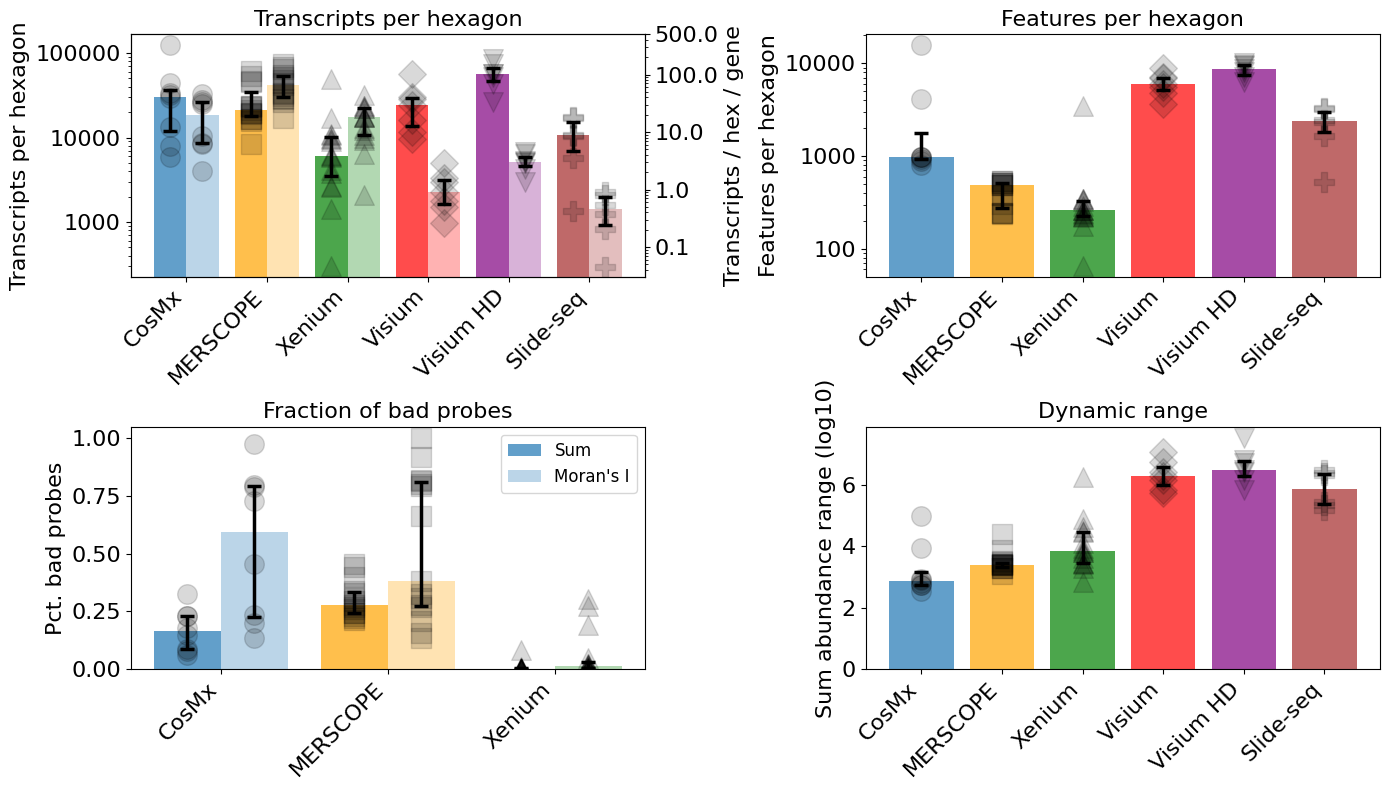

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("/content/pv_qc_2024-06-19/metrics_table.csv")

# Assign technology based on dataset name
data['Dataset'] = data['Dataset'].str.lower()
data['technology'] = data['Dataset'].apply(lambda x: 'Xenium' if 'xenium' in x
                                                 else 'CosMx' if 'cosmx' in x
                                                 else 'MERSCOPE' if 'vizgen' in x
                                                 else 'Visium HD' if 'hd' in x
                                                 else 'Slide-seq' if 'curio' in x
                                                 else 'seqFISH' if 'kidney_' in x
                                                 else 'Visium')


#divide Number of bad probes (Sum) by Number of genes
data ['Number of bad probes (Sum)'] = data ['Number of bad probes (Sum)'] / data ['Number of genes']
data ['Number of bad probes (Morans I)'] = data ['Number of bad probes (Morans I)'] / data ['Number of genes']


#generate barplots for Total transcripts, Number of genes in at least 5% of hexagons, Number of bad probes (Sum), Median pct unassigned

#reorder things as CosMx, MERSCOPE, Xenium, Visium, Visium HD, Slide-seq

colors = ['#1f77b4', 'orange', 'green', 'red', 'purple', 'brown']
markers = ['o', 's', '^', 'D', 'v', 'P']

# Define the desired order of technologies
tech_order = ['CosMx', 'MERSCOPE', 'Xenium', 'Visium', 'Visium HD', 'Slide-seq']

# Reorder the data based on the desired technology order
data['technology'] = pd.Categorical(data['technology'], categories=tech_order, ordered=True)
data = data.sort_values('technology')

#create new column for Median counts per hexagon per number of gene
data['Median counts per hexagon per number of gene'] = data['Median counts per hexagon'] / data['Number of genes']
tech_medians_counts_per_gene = data.groupby('technology')['Median counts per hexagon per number of gene'].median()
tech_data_counts_per_gene = data.groupby('technology')['Median counts per hexagon per number of gene'].apply(list)



fig, axs = plt.subplots(2, 2, figsize=(14, 8))


# Strip-bar plot for Total transcripts
tech_medians = data.groupby('technology')['Median counts per hexagon'].median()
tech_data = data.groupby('technology')['Median counts per hexagon'].apply(list)

bar_width = 0.4
opacity = 0.7

axs[0, 0].bar(range(len(tech_medians)), tech_medians, bar_width, alpha=opacity, color=colors, label='Transcripts per hexagon')

for i, tech in enumerate(tech_medians.index):
    axs[0, 0].scatter([i] * len(tech_data[tech]), tech_data[tech], color='black', marker=markers[i], s=200, alpha=0.15)

    # Add error bars
    q1 = data[data['technology'] == tech]['Median counts per hexagon'].quantile(0.25)
    q3 = data[data['technology'] == tech]['Median counts per hexagon'].quantile(0.75)
    axs[0, 0].errorbar(i, tech_medians[tech], yerr=[[tech_medians[tech] - q1], [q3 - tech_medians[tech]]],
                       fmt='none', ecolor='black', capsize=5, elinewidth=2.5, capthick=2.5)

axs[0, 0].set_xticks([x + bar_width/2 for x in range(len(tech_medians))])
axs[0, 0].set_xticklabels(tech_medians.index, rotation=45, ha='right', fontsize=16, fontname='Arial')
axs[0, 0].set_ylabel('Transcripts per hexagon', fontsize=16, fontname='Arial')
axs[0, 0].set_title('Transcripts per hexagon', fontsize=16, fontname='Arial')
axs[0, 0].tick_params(axis='both', labelsize=16)
axs[0, 0].set_yscale('log')  # Set the y-axis to logarithmic scale
axs[0, 0].yaxis.set_major_formatter(plt.ScalarFormatter())

# Create a second y-axis (axs2) for Transcripts per hexagon per gene
axs2 = axs[0, 0].twinx()

# Strip-bar plot for Transcripts per hexagon per gene on axs2
axs2.bar([x + bar_width for x in range(len(tech_medians_counts_per_gene))], tech_medians_counts_per_gene, bar_width, alpha=0.3, color=colors, label='Transcripts per hexagon per gene')

for i, tech in enumerate(tech_medians_counts_per_gene.index):
    axs2.scatter([i + bar_width] * len(tech_data_counts_per_gene[tech]), tech_data_counts_per_gene[tech], color='black', marker=markers[i], s=200, alpha=0.15)

    # Add error bars
    q1 = data[data['technology'] == tech]['Median counts per hexagon per number of gene'].quantile(0.25)
    q3 = data[data['technology'] == tech]['Median counts per hexagon per number of gene'].quantile(0.75)
    axs2.errorbar(i + bar_width, tech_medians_counts_per_gene[tech], yerr=[[tech_medians_counts_per_gene[tech] - q1], [q3 - tech_medians_counts_per_gene[tech]]],
                  fmt='none', ecolor='black', capsize=5, elinewidth=2.5, capthick=2.5)


# Set the y-axis to logarithmic scale for the secondary y-axis
axs2.set_yscale('log')

# Set the tick positions and labels for the secondary y-axis
axs2.set_yticks([0.1, 1, 10, 100, 500])  # Adjust the tick positions as needed
axs2.set_yticklabels(['0.1', '1', '10', '100', '500'])  # Adjust the tick labels as needed

axs2.set_ylabel('Transcripts / hex / gene', fontsize=16, fontname='Arial')
axs2.tick_params(axis='both', labelsize=16)
axs2.yaxis.set_major_formatter(plt.ScalarFormatter())



# Strip-bar plot for Number of genes in at least 5% of hexagons
tech_medians = data.groupby('technology')['Median features per hexagon'].median()
tech_data = data.groupby('technology')['Median features per hexagon'].apply(list)

for i, tech in enumerate(tech_medians.index):
    axs[0, 1].bar(i, tech_medians[tech], width=0.8, align='center', alpha=0.7, color=colors[i])
    axs[0, 1].scatter([i] * len(tech_data[tech]), tech_data[tech], color='black', marker=markers[i], s=200, alpha=0.15)

    # Add error bars
    q1 = data[data['technology'] == tech]['Median features per hexagon'].quantile(0.25)
    q3 = data[data['technology'] == tech]['Median features per hexagon'].quantile(0.75)
    axs[0, 1].errorbar(i, tech_medians[tech], yerr=[[tech_medians[tech] - q1], [q3 - tech_medians[tech]]],
                       fmt='none', ecolor='black', capsize=5, elinewidth=2.5, capthick=2.5)

axs[0, 1].set_xticks(range(len(tech_medians)))
axs[0, 1].set_xticklabels(tech_medians.index, rotation=45, ha='right', fontsize=16, fontname='Arial')
axs[0, 1].set_ylabel('Features per hexagon', fontsize=16, fontname='Arial')
axs[0, 1].set_title('Features per hexagon', fontsize=16, fontname='Arial')
axs[0, 1].tick_params(axis='both', labelsize=16)
axs[0, 1].set_yscale('log')
axs[0, 1].yaxis.set_major_formatter(plt.ScalarFormatter())

#remove bars for Curio and Visium here
data_old = data.copy()
data = data[data['technology'] != 'Slide-seq']
data = data[data['technology'] != 'Visium']
data = data[data['technology'] != 'Visium HD']

colors = ['#1f77b4', 'orange', 'green']
markers = ['o', 's', '^']

# Strip-bar plot for Number of bad probes (Sum)
tech_medians = data.groupby('technology')['Number of bad probes (Sum)'].median()
tech_data = data.groupby('technology')['Number of bad probes (Sum)'].apply(list)
tech_medians_mi = data.groupby('technology')["Number of bad probes (Morans I)"].median()
tech_data_mi = data.groupby('technology')["Number of bad probes (Morans I)"].apply(list)

#remove resulting nans
tech_medians = tech_medians.dropna()
tech_data = tech_data.dropna()

bar_width = 0.4  # Adjust the bar width to create space between sum and Moran's I bars

for i, tech in enumerate(tech_medians.index):
    axs[1, 0].bar(i - bar_width/2, tech_medians[tech], width=bar_width, align='center', alpha=0.7, color=colors[i], label='Sum' if i == 0 else '')
    axs[1, 0].scatter([i - bar_width/2] * len(tech_data[tech]), tech_data[tech], color='black', marker=markers[i], s=200, alpha=0.15)

    # Add error bars for "Number of bad probes (Sum)"
    q1 = data[data['technology'] == tech]['Number of bad probes (Sum)'].quantile(0.25)
    q3 = data[data['technology'] == tech]['Number of bad probes (Sum)'].quantile(0.75)
    axs[1, 0].errorbar(i - bar_width/2, tech_medians[tech], yerr=[[tech_medians[tech] - q1], [q3 - tech_medians[tech]]],
                       fmt='none', ecolor='black', capsize=5, elinewidth=2.5, capthick=2.5)

    axs[1, 0].bar(i + bar_width/2, tech_medians_mi[tech], width=bar_width, align='center', alpha=0.3, color=colors[i], label="Moran's I" if i == 0 else '')
    axs[1, 0].scatter([i + bar_width/2] * len(tech_data_mi[tech]), tech_data_mi[tech], color='black', marker=markers[i], s=200, alpha=0.15)

    # Add error bars for "Number of bad probes (Morans I)"
    q1_mi = data[data['technology'] == tech]["Number of bad probes (Morans I)"].quantile(0.25)
    q3_mi = data[data['technology'] == tech]["Number of bad probes (Morans I)"].quantile(0.75)
    axs[1, 0].errorbar(i + bar_width/2, tech_medians_mi[tech], yerr=[[tech_medians_mi[tech] - q1_mi], [q3_mi - tech_medians_mi[tech]]],
                       fmt='none', ecolor='black', capsize=5, elinewidth=2.5, capthick=2.5)

axs[1, 0].legend(fontsize=12)  # Add a legend to indicate sum and Moran's I

axs[1, 0].set_xticks(range(len(tech_medians)))
axs[1, 0].set_xticklabels(tech_medians.index, rotation=45, ha='right', fontsize=16, fontname='Arial')
axs[1, 0].set_ylabel('Pct. bad probes', fontsize=16, fontname='Arial')
axs[1, 0].set_title('Fraction of bad probes', fontsize=16, fontname='Arial')
axs[1, 0].tick_params(axis='both', labelsize=16)
axs[1, 0].yaxis.set_major_formatter(plt.ScalarFormatter())

data = data_old.copy()

colors = ['#1f77b4', 'orange', 'green', 'red', 'purple', 'brown']
markers = ['o', 's', '^', 'D', 'v', 'P']

# Strip-bar plot for Median pct unassigned
tech_medians = data.groupby('technology')['Sum abundance range (log10)'].median()
tech_data = data.groupby('technology')['Sum abundance range (log10)'].apply(list)

for i, tech in enumerate(tech_medians.index):
    axs[1, 1].bar(i, tech_medians[tech], width=0.8, align='center', alpha=0.7, color=colors[i])
    axs[1, 1].scatter([i] * len(tech_data[tech]), tech_data[tech], color='black', marker=markers[i], s=200, alpha=0.15)

    # Add error bars
    q1 = data[data['technology'] == tech]['Sum abundance range (log10)'].quantile(0.25)
    q3 = data[data['technology'] == tech]['Sum abundance range (log10)'].quantile(0.75)
    axs[1, 1].errorbar(i, tech_medians[tech], yerr=[[tech_medians[tech] - q1], [q3 - tech_medians[tech]]],
                       fmt='none', ecolor='black', capsize=5, elinewidth=2.5, capthick=2.5)

axs[1, 1].set_xticks(range(len(tech_medians)))
axs[1, 1].set_xticklabels(tech_medians.index, rotation=45, ha='right', fontsize=16, fontname='Arial')
axs[1, 1].set_ylabel('Sum abundance range (log10)', fontsize=16, fontname='Arial')
axs[1, 1].set_title('Dynamic range', fontsize=16, fontname='Arial')
axs[1, 1].tick_params(axis='both', labelsize=16)
axs[1, 1].yaxis.set_major_formatter(plt.ScalarFormatter())
plt.tight_layout()

In [ ]:
import os
import zipfile

# Specify the folder path
folder_path = "/content/pv_qc_2024-06-19"

# Create a ZipFile object
zip_filename = "pv_qc_2024-06-19.zip"
with zipfile.ZipFile(zip_filename, "w", zipfile.ZIP_DEFLATED) as zip_file:
    # Iterate over all the files in the folder
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Get the full path of the file
            file_path = os.path.join(root, file)

            # Add the file to the zip archive
            zip_file.write(file_path, os.path.relpath(file_path, folder_path))

print(f"Folder '{folder_path}' has been zipped successfully as '{zip_filename}'.")

Folder '/content/pv_qc_2024-06-19' has been zipped successfully as 'pv_qc_2024-06-19.zip'.


In [ ]:
from google.colab import files

# Specify the path to your zip file
zip_file_path = '/content/pv_qc_2024-06-19.zip'

# Download the zip file
files.download(zip_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import subprocess

# Run the pip freeze command to get a list of installed packages
output = subprocess.check_output(['pip', 'freeze']).decode('utf-8').strip().split('\n')

print("Installed packages:")
for package in output:
    print(package)

Installed packages:
absl-py==1.4.0
access==1.1.9
adjustText==1.1.1
affine==2.4.0
aiobotocore==2.5.4
aiohttp==3.9.5
aioitertools==0.11.0
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
altair==4.2.2
anndata==0.10.7
annotated-types==0.6.0
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_api_compat==1.7.1
array_record==0.5.1
arviz==0.15.1
asciitree==0.3.3
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.15.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.5.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.4
botocore==1.31.17
bqplot==0.12.43
branca==0.7.2
build==1.2.1
CacheControl==0.14.0
cachetools==5.3.3
catalogue==2.0.10
certifi==2024.2.2
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.16.0
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.2
colorcet==3.